In [1]:
#Primary stage Parameters - not affected by Beam Initial Energy
p = 1.77
alpha = 0.0022
beta = 0.012
gamma = 0.6
epsilon = 0 #ranges 0.0 to 0.2
e_2 = 997 # density of the medium 
sd = 0.01

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import scipy as sp
import scipy.special.cython_special 
import math as math
import pandas as pd
import itertools as it

from scipy.misc import derivative as dv #unsurprisingly is the derivative function 
from scipy import integrate
from scipy.optimize import minimize
from scipy.optimize import lsq_linear

import sympy as sym

import numpy.ma as ma #this was for the joint curves but not implemented anymore 

import statistics as stat #used for shorthand standard deviation and mean calculation (yes im that lazy to calculate mean)
plt.style.use('default')

def CalculateXAxis(eZero): # Send in a single eZero Value, returns the x-axis to scale

    rZeroMax = alpha*(eZero**p) 
    z = np.arange(0,rZeroMax*1.1,0.1) #multiply by 1.1 to allow the plot to have greater range (visually nicer).
    
    return(z)

def CalculateXAxisList(eZeroList): # Send in a multiple eZero Values in List/tuple... returns the x-axis to scale 

    eZeroMax = int(max(eZeroList)) # Seleceting the greatest eZero to allow for all curves to be shown in plot 
    rZeroMax = alpha*((eZeroMax**p))
    z = np.arange(0,rZeroMax*1.1,0.1) #multiply by 1.1 to allow the plot to have greater range (visually nicer).
    
    return(z)

def CalculateSecondary(eZero,z): 
    # Send in eZero and the specific x axis, returns all calculated values and dict for df visualisation later
        
    #Secondary Stage Parameters
    rZero = alpha*(pow(eZero,p))
    sigE0 = 0.01*eZero
    sigMono = beta*(rZero**0.935)
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -z)/sigma
    phiZero = 1 + beta*(rZero)
    
    #Parabolic Cylinder Function 
    curlyD,derivCurlyD = scipy.special.pbdv((1-p), (-1*eta))
    curlyD2,deivCurlyD2 = scipy.special.pbdv(((-1/p)-1),(-1*eta))
    
    #Appending few data to dictionary for DataFrame use 
    secondaryData = {"eZero":eZero, "rZero": rZero,"sigma":sigma,
                     "phiZero":phiZero}
    
    return(secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)


def CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2): 
    # Send in Values calculated in CalculateSecondary(...), returns the curve function (set of discrete points).
    
    curve =  (phiZero)*np.exp((-1*(eta)**2)/4)*(sigma**(1/p))*(math.gamma(1/p))*(
    1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
    ((1/sigma)*(curlyD))+((beta/p)+(gamma*beta)+epsilon/rZero)*curlyD2)

    return(curve)
def CalculateSingularPBC(eZero,df): #Send in MeV, returns curve and Dataframe with information about the curve.
    
    #Predefined Variables
    z = CalculateXAxis(eZero)
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    #storing data in Dataframe
    beamData = pd.Series(data = secondaryData,index = secondaryData.keys())
    df = pd.concat([df, beamData.to_frame().T], ignore_index=True)
    
    return(curve,df)

def CalculateMultiplePBC(eZero,z,df): #Send in MeV, returns curve values.
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    #storing data in Dataframe
    beamData = pd.Series(data = secondaryData,index = secondaryData.keys())
    df = pd.concat([df, beamData.to_frame().T], ignore_index=True)
    
    return(curve,df)

def CalculateSingularPBCNoDF(eZero): #Send in MeV, returns curve and Dataframe with information about the curve.
    
    #Predefined Variables
    z = CalculateXAxis(eZero)
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    
    return(curve)

def CalculateMultiplePBCNoDF(eZero,z): #Send in MeV, returns curve values.
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    return(curve)

def PlotCurve(eZero): # Send in ONE eZero, Calculates individual PBC and Plots, returns nothing. 
    CurveData = pd.DataFrame()
    curve, CurveData = CalculateSingularPBC(eZero,CurveData)
    z = CalculateXAxis(eZero)
    plt.plot(z,curve, label = (str(eZero)+ "MeV"))
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Individual Bragg Curve Plot")
    
    plt.legend(loc='best')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
    
def PlotCumulativeCurve(eZero): # Send in MULTIPLE eZero, Calculates individual PBC'S and Plots, returns nothing. 
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    z = CalculateXAxisList(eZero)
    
    for i in eZero:
        curve,CurveData = CalculateMultiplePBC(i,z, CurveData)
        curveList.append(curve)
        
    cumulativeCurve = sum(curveList)
    plt.plot(z,cumulativeCurve, label = "Cumulative Curve", color = "k")
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Cumulative Proton Beam Curve Plot")
    
    plt.legend(loc='upper left')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
    
    
def PlotCumulativeCurveAndInd(eZero): # Send in MULTIPLE eZero, Calculates individual PBC'S and Plots, returns nothing. 
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    z = CalculateXAxisList(eZero)
    
    for i in eZero:
        curve,CurveData = CalculateMultiplePBC(i,z,CurveData)
        curveList.append(curve)
        plt.plot(z,curve, label = (str(i)+ "MeV"))
        
    cumulativeCurve = sum(curveList)
    plt.plot(z,cumulativeCurve, label = "Cumulative Curve", color = "k")
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Cumulative and Individual Proton Beam Curve Plot")
    
    plt.legend(loc='upper left')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
    
def InteractivePlot():

    text = ""
    while text != 4:
        eZeroList = []
    
        text = int(input("Menu. Choose Menu item: \n 1: Plot Individual PBC(s)"
             +"\n 2: Plot Only Cumulative Curve \n 3: Plot Cumulative Curve and Individual PBC(s)"
             +"\n 4: Quit \n"))
    
        if text ==1 or text ==2 or text ==3:
            amountOfCurves = int(input("Enter amount of Curves: "))
            for i in range(amountOfCurves):
                eZero = int(input("Enter eZero number "+ str(i+1)+ ": "))
                if text ==1:
                    PlotCurve(eZero)
                eZeroList.append(eZero)
            plt.show()
            
            if text ==2:
                PlotCumulativeCurve(eZeroList)
                plt.show()
            elif text ==3:
                PlotCumulativeCurveAndInd(eZeroList)
                plt.show()
def PlotSimpleBox(): 
    #takes no aguments, plots dashed lines of tumour range and doseage required
    plt.hlines(y=0.1,xmin = 12,xmax = 15, color='r', linestyles='dashed')
    plt.vlines(x=12,ymin = 0,ymax = 0.1, color='r', linestyles='dashed')
    plt.vlines(x=15,ymin = 0,ymax = 0.1, color='r', linestyles='dashed', label = "Target Range")

def PlotCustomBox(upper,lower,dose):
    # takes three aguments. Upper and lower dispalcement values and target doseage value.
    # plots dashed lines of tumour range and doseage required
    plt.hlines(y=dose,xmin = lower,xmax = upper, color='r', linestyles='dashed')
    plt.vlines(x=lower,ymin = 0,ymax = dose, color='r', linestyles='dashed')
    plt.vlines(x=upper,ymin = 0,ymax = dose, color='r', linestyles='dashed') #, label = "Target Range"'
    

def CalculateMaxCurves(dose, upper, energyData):
    df = energyData[(energyData["rMax"] <= upper)]
    eZero = max(df.eZero)
    curve,df = CalculateSingularPBC(eZero,df)
    eInitial = curve[0]
    
    maxCurves = int((dose // eInitial)+1)
    
    return(maxCurves)
def RestrictDfRanges(df, lower,upper):
    # takes energyData DataFrame, lower bound and upper bound of the target range as arguments.
    # Returns a new trimmed DataFrame restricted to the rMax values greaters than or equal to lower bound
    # and less than or equal to upper bound.

    df2 = energyData[(energyData["rMax"] >= lower)]
    df2 = df2[(df2["rMax"] <= upper)]

    return(df2)
def CalculateInfo(dose,lower, upper, SOBP):
    # Takes targetDose, lower bound and upper bound of target range and the SOBP curve as arguments.
    # Returns Standard Deviation, Average Distance of curve to target dose, Percentage of the SOBP Above Dose Line.
    
    lower = int(lower)
    upper = int(upper)
    avgDistList = []
    z2 = np.arange(lower,upper,0.1)
    regionOfCurve = SOBP[lower*10:upper*10] #times 10 as z has 0.1 increments 
    
    stdDev = np.std(regionOfCurve)
    
    #Calculating the average distance away from the curve in the y axis and percentageAboveDose 
    counter = 0
    
    for i in regionOfCurve:
        avgDist = dose-i
        if avgDist<=0:
            counter = counter +1
            avgDist = abs(avgDist)
        avgDistList.append(avgDist)
    avgDist = sum(avgDistList)/len(avgDistList)
    
    percentageAboveDose = counter/len(SOBP[lower*10:upper*10])
    
    return(stdDev, avgDist, percentageAboveDose)
    
def Optimiser(): 
    # Takes no arguments, returns DataFrame of SOBP curves in rank order.
    
    option = int(input("Choose Simple Box? \n 1:yes \n 0:no \n"))

    if option == 0:
        upper = round(float(input( "upper Bound Value (float): ")),2)
        lower = round(float(input( "lower Bound Value (float): ")),2)
        dose = round(float(input( "Dose Value (float): ")),2)
        PlotCustomBox(upper,lower,dose)
    
    elif option == 1:
        PlotSimpleBox()
        upper = 15
        lower = 12
        dose = 0.1 
        
    mxNo = CalculateMaxCurves(dose, upper, energyData) #max # of curves i should use to get the SOBP else dosage too high
    print("Your given doseage has upper bound number of curves needed as " + str(mxNo))
    r = int(input("Number of curves to use (maximum is 5)? :")) # change to the optimised version later
    
    #trim the range of energyValues()
    df = RestrictDfRanges(energyData,lower,upper)
    
    #defining variables:
    cdf = pd.DataFrame() #dataFrame to contain the energy Values and stats about the SOBP 
    
    eZeroOne = None
    eZeroTwo = None
    eZeroThree = None
    eZeroFour = None
    eZeroFive = None
    curveList = []
    eZeroList = [] # list used to hold all eZero values
    
    #Combinations
    n = len(df.eZero) # the amount of eZero values to iterate through 
    print(" r = "+str(r)+ "\n n = "+ str(n))
    
   
    for i in range(n-1):
        eZeroList.append(df.eZero.iloc[i])
    # eZeroList now hold all eZero values
    
    combList = list(it.combinations_with_replacement(eZeroList,r))
    #comb list now holds all the combinations of values in eZeroList.
    
    print("Total amount of combinations = " + str(len(combList))) 

    for combo in combList:
        curveList =[] 
        z = CalculateXAxisList(combo)
            
        for eZero in combo:
            curve,df = CalculateMultiplePBC(eZero,z, df) # Calculate individual PBC
            curveList.append(curve) 

        sobp = sum(curveList) # Calculate SOBP
            
        stdDev, avgDist, percentageAboveDose= CalculateInfo(dose,lower, upper,sobp) # Calculate the info for the df later

        #append data to cdf
        if r == 2:
            eZeroOne = combo[0];eZeroTwo = combo[1]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r == 3:
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r == 4: 
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2];eZeroFour = combo[3];

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree ,"eZeroFour":eZeroFour,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r ==5:
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2];eZeroFour = combo[3];eZeroFive = combo[4]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree ,"eZeroFour":eZeroFour,
                     "eZeroFive": eZeroFive,"standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,
                     "percentageAboveDoseLine":percentageAboveDose}

        beamData = pd.Series(data = datum,index = datum.keys())
        cdf = pd.concat([cdf, beamData.to_frame().T], ignore_index=True)


    #sort the df by percentageAboveDoseLine values
    df2 = cdf.sort_values(by = ['percentageAboveDoseLine','averageDisplacementFromDose'], ascending = [False,True])
    
    for j in range(3): #for the top 3 curves  
        eVals = []          
        for i in range(r): # take the n curves that make the sobp
            eVals.append(df2.iloc[j][i]) #add the eZeros to a list 
        print("BEST CURVE NUMBER "+str(j+1))
        PlotCumulativeCurveAndInd(eVals) #Plot the List 
        PlotCustomBox(upper,lower,dose)
        plt.show()
    return(df2)
def CalculateSecondaryNorm(eZero,z, theta):
    
    phi = np.random.normal(0,theta,1)
    #Secondary Stage Parameters
    rZero = alpha*(eZero**p)
    sigE0 = 0.01*eZero
    sigMono = beta*(rZero**0.935)
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -(z+phi))/sigma
    phiZero = 1 + beta*(rZero)
    
    #Parabolic Cylinder Function 
    curlyD,derivCurlyD = scipy.special.pbdv((1-p), (-1*eta))
    curlyD2,deivCurlyD2 = scipy.special.pbdv(((-1/p)-1),(-1*eta))
    
    #Appending few data to dictionary for DataFrame use 
    secondaryData = {"eZero":eZero, "rZero": rZero,"theta":theta,
                     "phi":round(float(phi),2)}
    
    
    
    return(secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2,z)
def CalculateSingularPBCNorm(eZero,df,theta): #Send in MeV, returns curve and Dataframe with information about the curve.
    
    #Predefined Variables
    z = CalculateXAxis(eZero)
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2,z = CalculateSecondaryNorm(eZero,z,theta)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    #storing data in Dataframe
    beamData = pd.Series(data = secondaryData,index = secondaryData.keys())
    df = pd.concat([df, beamData.to_frame().T], ignore_index=True)
    
    return(curve,df)

def CalculateMultiplePBCNorm(eZero,z,df,theta): 
    # Send in eZero, rnage of dispalceent Valeus, DataFrame to contain data, and Standard eviation.
    # Returns curve values.
    
    #Calculating the Curve parameters
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2,z = CalculateSecondaryNorm(eZero,z,theta)
    
    #Using parameters to calculate curve 
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    
    #storing data in Dataframe
    beamData = pd.Series(data = secondaryData,index = secondaryData.keys())
    df = pd.concat([df, beamData.to_frame().T], ignore_index=True)
    
    return(curve,df)
def PlotCurveNorm(eZero,theta): # Send in ONE eZero, Calculates individual PBC and Plots, returns nothing. 
    
    CurveData = pd.DataFrame()
    curve, CurveData = CalculateSingularPBCNorm(eZero,CurveData,theta)
    z = CalculateXAxis(eZero)
    plt.plot(z,curve, label = (str(eZero)+ "MeV"))
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Individual Proton Beam Curve Plot WITH uncertainty")
    
    plt.legend(loc='best')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
    
def PlotCumulativeCurveNorm(eZero,theta): # Send in MULTIPLE eZero, Calculates individual PBC'S and Plots, returns nothing. 
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    z = CalculateXAxisList(eZero)
    
    for i in eZero:
        curve,CurveData = CalculateMultiplePBCNorm(i,z, CurveData,theta)
        curveList.append(curve)
        
    cumulativeCurve = sum(curveList)
    plt.plot(z,cumulativeCurve, label = "Cumulative Curve", color = "k")
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Cumulative Proton Beam Curve Plot WITH uncertainty")
    
    plt.legend(loc='upper left')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
    
    
def PlotCumulativeCurveAndIndNorm(eZero,theta): # Send in MULTIPLE eZero, Calculates individual PBC'S and Plots, returns nothing. 
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    z = CalculateXAxisList(eZero)
    
    for i in eZero:
        curve,CurveData = CalculateMultiplePBCNorm(i,z,CurveData,theta)
        curveList.append(curve)
        plt.plot(z,curve, label = (str(i)+ "MeV"))
        
    cumulativeCurve = sum(curveList)
    plt.plot(z,cumulativeCurve, label = "Cumulative Curve", color = "k")
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Cumulative and Individual Proton Beam Curve Plot WITH uncertainty")
    
    plt.legend(loc='upper left')
    plt.grid(True)
    
    #Displaying CurveData
    print(CurveData.head())
def InteractivePlotNorm():

    text = ""
    while text != 4:
        eZeroList = []
    
        text = int(input("Menu. Choose Menu item: \n 1: Plot Individual PBC(s) with Uncertainty"
             +"\n 2: Plot Only Cumulative Curve with Uncertainty \n 3: Plot Cumulative Curve and Individual PBC(s) with Uncertainty"
             +"\n 4: Quit \n"))
    
        if text ==1 or text ==2 or text ==3:
            amountOfCurves = int(input("Enter amount of Curves: "))
            theta = float(input("Enter value for Theta: "))
            for i in range(amountOfCurves):
                eZero = int(input("Enter eZero number "+ str(i+1)+ ": "))
                if text ==1:
                    PlotCurveNorm(eZero,theta)
                eZeroList.append(eZero)
            plt.show()
            
            if text ==2:
                PlotCumulativeCurveNorm(eZeroList,theta)
                plt.show()
            elif text ==3:
                PlotCumulativeCurveAndIndNorm(eZeroList,theta)
                plt.show()
def PlotVisualisations(eZero,n, theta):
#Predefined Variables
    curveList = []
#Start:

    PlotCurveNorm(eZero,0)

#retrieve all the energies first to work out max range for final plot
    z = CalculateXAxis(eZero)
    for i in range(n): 

    
    #Calculating Data
        secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2,z = CalculateSecondaryNorm(eZero,z,theta)
        curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
        curveList.append(curve)
    
    #plotting
        plt.plot(z,curve, color = "pink",alpha = 0.02)
#details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Proton Beam Curve with "+str(n)+ " samples of uncertain PBCs")
    plt.grid(True)
    plt.xlim([0,(z[len(z)-1] +theta*3)]) #restricting the area to upper bound it by 3 times the theta 
def PlotSingularPBCNormEB(eZero,nStdDev,theta):
    
    #Calculating Data
    z = CalculateXAxis(eZero)
    secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z);
    curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    #plotting
        #random colors
    r = round(float(np.random.uniform(0,1,1)),1)
    g = round(float(np.random.uniform(0,1,1)),1)
    b = round(float(np.random.uniform(0,1,1)),1)
    plt.plot(z,curve, label =  (str(eZero)+ "MeV"),color = (r,g,b))
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("Proton Beam Curve with Error bars of "+str(nStandardDeviations)+" Standard Deviations ")
    plt.legend(loc = "upper left")
    #error bar
    plt.errorbar(z,curve,xerr = nStandardDeviations*theta, elinewidth = 0.5,color = (r,g,b))
    plt.xlim(0,z[len(z)-1]+(nStandardDeviations*theta))
def PlotCumulativeCurveNormEB(eZero,nStdDev,theta):
    
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    amountOfCurves = len(eZero)
    #Calculating Data
    z = CalculateXAxisList(eZero)
     
    for i in eZero:
        curve,CurveData = CalculateMultiplePBC(i,z, CurveData)
        curveList.append(curve)
        
    cumulativeCurve = sum(curveList)
    
    #plotting 
    plt.plot(z,cumulativeCurve, color = "k", label = "Cumulative Curve")
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("SOBP with Error Bars of "+str(nStandardDeviations)+" Standard Deviations ")
    plt.legend(loc = "upper left")
    
    #error bar
    plt.errorbar(z,cumulativeCurve,xerr = nStandardDeviations*theta*amountOfCurves, color = "k", elinewidth = 0.5)
    plt.xlim(0,z[len(z)-1]+(nStandardDeviations*theta))
    plt.grid(True)
    plt.show()

def PlotCumulativeCurveAndIndNormEB(eZero, nStdDev, theta):
    CurveData = pd.DataFrame()
    curveList = []
    eZero = list(eZero)
    z = CalculateXAxisList(eZero)
    amountOfCurves = len(eZero)
    
    for i in eZero:
        
        #random colors
        r = round(float(np.random.uniform(0,1,1)),1)
        g = round(float(np.random.uniform(0,1,1)),1)
        b = round(float(np.random.uniform(0,1,1)),1)
        
        curve,CurveData = CalculateMultiplePBC(i,z,CurveData)
        curveList.append(curve)
        #plot
        plt.plot(z,curve, label = (str(i)+ "MeV"),color = (r,g,b))
        #error bar
        plt.errorbar(z,curve,xerr = nStandardDeviations*theta, elinewidth = 0.5, color = (r,g,b))
        
    cumulativeCurve = sum(curveList)
    
    #plotting
    plt.plot(z,cumulativeCurve, label = "Cumulative Curve", color = "k")
    
    
    #details
    plt.xlabel("displacement/cm")
    plt.ylabel("Dose per fluence")
    plt.title("SOBP and Individual Proton Beam Curve Plot with "+str(nStdDev)+" Error Bars")
    
    #error bar
    plt.errorbar(z,cumulativeCurve,xerr = nStandardDeviations*theta*amountOfCurves, color = "k", elinewidth = 0.5)
    
    plt.legend(loc='upper left')
    plt.grid(True)
def PlotCustomBoxError(upper,lower,dose):
    plt.vlines(x=lower,ymin = 0,ymax = dose, color='b', linestyles='dashed')
    plt.vlines(x=upper,ymin = 0,ymax = dose, color='b', linestyles='dashed')
def OptimiserWithUncertainty(): 
    # Takes no arguments, returns DataFrame of SOBP curves in rank order.
    
    theta = float(input("Theta value: "))
    nStnDev = int(input("Amount of standard deviations (1,2 OR 3): "))
    option = int(input("Choose Simple Box? \n 1:yes \n 0:no \n"))

    if option == 0:
        
        upper = round(float(input( "upper Bound Value (float): ")),2) 
        lower = round(float(input( "lower Bound Value (float): ")),2)
        dose = round(float(input( "Dose Value (float): ")),2)
        mxNo = CalculateMaxCurves(dose, upper, energyData) #max # of curves i should use to get the SOBP else dosage too high
        print("Your given doseage has upper bound number of curves needed as " + str(mxNo))
        r = int(input("Number of curves to use (maximum is 5)? :")) # change to the optimised version later

        upperErr = upper - r*nStnDev*theta
        lowerErr = lower + r*nStnDev*theta 
        
        
       
        
    
    elif option == 1:
        
        upper = 15
        lower = 12
        dose = 0.1 
        
        mxNo = CalculateMaxCurves(dose, upper, energyData) #max # of curves i should use to get the SOBP else dosage too high
        print("Your given doseage has upper bound number of curves needed as " + str(mxNo))
        r = int(input("Number of curves to use (maximum is 5)? :")) # change to the optimised version later
        
        upperErr = upper - r*nStnDev*theta
        lowerErr = lower + r*nStnDev*theta 
        
    
    elif (upper - lower)/(nStnDev*2) <= (theta):
        print("No solutions, Error range too large")
        return()
    
    #trim the range of energyValues()
    df = RestrictDfRanges(energyData,lowerErr,upperErr)
    
    #defining variables:
    cdf = pd.DataFrame() #dataFrame to contain the energy Values and stats about the SOBP 
    
    eZeroOne = None
    eZeroTwo = None
    eZeroThree = None
    eZeroFour = None
    eZeroFive = None
    curveList = [] # list used to hold all PBC in calculation for SOBP curve
    eZeroList = [] # list used to hold all eZero values
    uncerList = [] # list used to hold the uncertainty value for every curve
     
    #Combinations
    n = len(df.eZero) # the amount of eZero values to iterate through 
    print(" r = "+str(r)+ "\n n = "+ str(n))
    
   
    for i in range(n-1):
        eZeroList.append(df.eZero.iloc[i])
    # eZeroList now hold all eZero values
    
    combList = list(it.combinations_with_replacement(eZeroList,r))
    #comb list now holds all the combinations of values in eZeroList.
    
    print("Total amount of combinations = " + str(len(combList))) 

    for combo in combList:
        curveList =[] 
        z = CalculateXAxisList(combo)
            
        for eZero in combo:
            curve,df = CalculateMultiplePBC(eZero,z, df) # Calculate individual PBC
            curveList.append(curve) 

        sobp = sum(curveList) # Calculate SOBP
            
        stdDev, avgDist, percentageAboveDose= CalculateInfo(dose,lower, upper,sobp) # Calculate the info for the df later

        #append data to cdf
        if r == 2:
            eZeroOne = combo[0];eZeroTwo = combo[1]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r == 3:
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r == 4: 
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2];eZeroFour = combo[3];

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree ,"eZeroFour":eZeroFour,
                 "standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,"percentageAboveDoseLine":percentageAboveDose}

        elif r ==5:
            eZeroOne = combo[0];eZeroTwo = combo[1];eZeroThree = combo[2];eZeroFour = combo[3];eZeroFive = combo[4]

            datum = {"eZeroOne": eZeroOne,"eZeroTwo":eZeroTwo ,"eZeroThree":eZeroThree ,"eZeroFour":eZeroFour,
                     "eZeroFive": eZeroFive,"standardDeviation":stdDev,"averageDisplacementFromDose":avgDist,
                     "percentageAboveDoseLine":percentageAboveDose}
            
        uncerList.append(r*nStnDev*theta)
        beamData = pd.Series(data = datum,index = datum.keys())
        cdf = pd.concat([cdf, beamData.to_frame().T], ignore_index=True)


    #sort the df by percentageAboveDoseLine values
    cdf["TotalUncertainty"] = uncerList
    cdf = cdf.sort_values(by = ['percentageAboveDoseLine','averageDisplacementFromDose'], ascending = [False,True])
    
    for j in range(3): #for the top 3 curves  
        eVals = []          
        for i in range(r): # take the n curves that make the sobp
            eVals.append(cdf.iloc[j][i]) #add the eZeros to a list 
        print("BEST CURVE NUMBER "+str(j+1))
        PlotCumulativeCurveAndIndNormEB(eVals,nStnDev,theta) #Plot the List 
        PlotCustomBoxError(upperErr,lowerErr,dose)
        PlotCustomBox(upper,lower,dose)
        plt.show()
    return(cdf) 

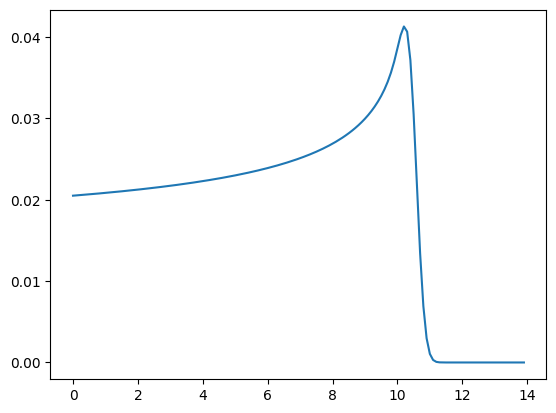

In [2]:
def Functionb(x,eZero):
    
    p = 1.77
    alpha = 0.0022
    beta = 0.012
    gamma = 0.6
    epsilon = 0 #ranges 0.0 to 0.2
    e_2 = 997 # density of the medium 
    sd = 0.01

    #secondaryData - variables that have used "primary" unchaning variables (rho included in primary)
    rZero = alpha*(pow(eZero,p))*1
        
    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -x)/sigma
    phiZero = 1 + beta*(rZero)

    #Parabolic Cylinder Function 
    curlyD,derivCurlyD = scipy.special.pbdv((1-p), (-1*eta))
    curlyD2,deivCurlyD2 = scipy.special.pbdv(((-1/p)-1),(-1*eta))
    
    #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    y =  (phiZero)*np.exp((-1*(eta)**2)/4)*(sigma**(1/p))*(math.gamma(1/p))*(
    1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
    ((1/sigma)*(curlyD))+((beta/p)+(gamma*beta)+epsilon/rZero)*curlyD2)
    return(y)


x = np.arange(0,14,0.1)
plt.plot(x,Functionb(x,120))



In [3]:
print(epsilon)

0


In [4]:
        
def Function3b(x,eZeroi,eZeroj): #used to fill M for the quadrature method.  
    a = FunctionH202(x,eZeroi)
    b = FunctionH202(x,eZeroj)
    c = a*b
    return(c)
    
def OptimiseLAb(lower, upper,dose, eVals): 
    # definine variables 
    n = len(eVals)
    if upper-lower  <= 4 and upper <5:
        z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.01)
    else:
        z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        
        for j in range(n): # for n evaleus 
            
            
            val,err = integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j]))
            m[i,j] = val
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        
        val,err = integrate.quad(FunctionH202 ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*FunctionH202(z,eVals[i]))) #collect the di's
        if i == 0:
            plt.plot(z,dList[i], label = "Bragg Curves", color = "blue", alpha = 0.4)
        else:
            plt.plot(z,dList[i], color = "blue", alpha = 0.4)



            
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(z,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Intensity Optimized SOBP Plot")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim([0,dose+0.3])
    #plt.xlim([0,18])
    
    return(m,omega,f,d)



def OptimiseLAbNoPlot(lower, upper,dose, eVals): 
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
    print("LENGTH OF Z ",len(z))
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 
            
            val,err = integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j]))
            m[i,j] = val
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        ###SeteValGlobal(eVals[j]) #Function(), Function4()
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        
        
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
   
    return(m,omega,f,d)
def OptimiseLARatioB(lower, upper,dose, eVals,theta,phi):
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 
             
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
            valCorrected = theta*valTarget + phi*(valUpper+ valLower)
            m[i,j] = valCorrected
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        ###SeteValGlobal(eVals[j]) #Function(), Function4()
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        plt.plot(z,dList[i], label = "Bragg Curve", color = "blue", alpha = 0.4)
        
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(z,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Intensity Optimized SOBP Plot. Phi = "+ str(phi))
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim([0,dose+0.3])
    plt.xlim([0,18])
    
    return(m,omega,f,d)
def GetDb(x,omega,eVals):
    lst = []
    for i in range(len(eVals)): # for every value
        
        lst.append(omega[i]*FunctionH202(x,eVals[i])) # hold data in list 
    continousD = sum(lst) # y = f(x)
    return(continousD)

In [5]:
scipy.special.pbdv(0.5,1)

(0.8422032440698389, -0.09456560868523928)

In [6]:
def CalculatePeakDoseZValue(curve,z): 
    # takes curve, as calculated from CalculateCurve() function, and range of which to plot the curve as arguments
    # returns Peak Dose and displacement of point of Peak Dose
    
    rMax = 0
    peakDose = max(curve)
    
    for i in range(len(z)):
            if curve[i] == peakDose:
                rMax = i/20
                return(peakDose,rMax)
            
def FindBestLowerUpperEZeros(lower, upper):
    eZeroValues = np.arange(120,150,0.05)
    z = np.arange(0,20,0.05)
    energyData2 = pd.DataFrame()
    for eZero in eZeroValues: 
        curve = FunctionH202(z,eZero)
        plt.plot(z,curve)
        peakDose,rMax = CalculatePeakDoseZValue(curve,z)
        datum = {"eZero": eZero, "peakDose":peakDose,"rMax": rMax}
        beamData = pd.Series(data = datum,index = datum.keys())
        energyData2 = pd.concat([energyData2, beamData.to_frame().T], ignore_index=True)
    energyData2.to_csv("energyData2")
    lowerdf = energyData2[(energyData2["rMax"] == lower)]
    upperdf = energyData2[(energyData2["rMax"] == upper)]
    print("lower df", lowerdf)
    print("upperdf", upperdf)
    eZeroLower = lowerdf.eZero.iloc[0]; 
    eZeroUpper = upperdf.eZero.iloc[len(upperdf)-1];
    return(eZeroLower,eZeroUpper)

In [7]:
def GetQuadratureTSqrt(omega,eVals):
    #lower = 12;upper = 15
    val,err = integrate.quad(GetDMinusOneNormedSquared,12,15,args=(omega,eVals))
    y = np.sqrt(val)
    return(y)
    

In [8]:
def FunctionDeriv(x,eVal):

    h = 0.00001
    deriv = (FunctionH202((x+h),eVal) - FunctionH202(x,eVal))/(h)
    
    return(deriv)
    
def FunctionDeriv3(x,eVals):
    a = FunctionDeriv(x,eVals[0])
    b = FunctionDeriv(x,eVals[1])
    return(a*b)

   
def PenalizeDerivaive(lower,upper,dose,eVals,theta,phi,psi):
    
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*2,0.1)
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 

            eValsij = [eVals[i],eVals[j]]
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
            valCorrected = theta*valTarget + phi*(valUpper+ valLower)
            
            valDeriv,err = integrate.quad(FunctionDeriv3,lower,upper,args = (eValsij))
            valCorrected = valCorrected + psi*(valDeriv)
            
            m[i,j] = valCorrected
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        plt.plot(z,dList[i], label = "Bragg Curve", color = "blue", alpha = 0.4)
        
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(z,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Intensity Optimized SOBP Plot")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim([0,2])
    plt.xlim([0,18])
    
    return(m,omega,f,d)

def TristanFunciton(x,eZeroij,p2):
    deriv = FunctionDeriv(x,eZeroij[0])
    absolute = abs(deriv)
    lamda = pow(absolute,(p2-2))
    rho = FunctionDeriv3(x,eZeroij)
    delta = lamda* rho
    
    return(delta)
def PenalizeDerivaiveMore(lower,upper,dose,eVals,theta,phi,psi,p2):
    
    # definine variables 
    n = len(eVals)
    z = np.arange(0,(alpha)*(max(eVals)**p)*1.2,0.1)
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 

            eValsij = [eVals[i],eVals[j]]
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            #print(valTarget)
            valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
            valCorrected = (theta*valTarget) + phi*(valUpper+ valLower)
            #print(valCorrected)
            valDeriv,err = integrate.quad(TristanFunciton,lower,upper,args = (eValsij,p2))
            valCorrected = valCorrected + psi*(valDeriv)
            #print(valCorrected)
            m[i,j] = valCorrected
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        val,err = integrate.quad(Functionb ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*Functionb(z,eVals[i]))) #collect the di's
        plt.plot(z,dList[i], label = "Bragg Curve", color = "blue", alpha = 0.4)
        
    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(z,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Intensity Optimized SOBP Plot")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = z[len(z)-1], color='r', linestyles='dashed')
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylim([0,2])
    #plt.xlim([0,18])
    
    return(m,omega,f,d)



def GetQuadratureTSqrtPlusPsi(omega,eVals,psi):
    lower = 12;upper = 15
    val,err = integrate.quad(GetDMinusOneNormedSquared,12,15,args=(omega,eVals)) 
    val2,err2 = integrate.quad(GetdPrimeNormSquared,12,15,args = (omega,eVals,psi))
    y = (val + val2)
    return(y)

def GetdPrimeNormSquared(x,omega,eVals,psi):
    dPrime = FunctionDeriv2(x,eVals,omega)
    y = psi*pow(abs(dPrime),2)
    
    return(y)
def FunctionDeriv2(x,eVals,omega):

    h = 0.001
    deriv = (GetDb((x+h),omega,eVals) - GetDb(x,omega,eVals))/(h)
    
    return(deriv)

def FunctionDPrimeNormSq(x,eZero,p2):
    dPrime = pow(abs(FunctionDeriv(x,eZero)),p2-2)
    dPrime = dPrime + TristanFunciton
    return(dPrime)


def TristanFunciton2(x,eZeroij,p2,eVals,omega):
    if p2 != 2:
        deriv = pow(abs(FunctionDeriv2(x,eVals,omega)),p2-2)
        rho = FunctionDeriv3(x,eZeroij)
        delta = deriv* rho
    else:
        deriv = 1
        rho = FunctionDeriv3(x,eZeroij)
        delta = deriv* rho
    
    return(delta)
def PenaliseDerivativeEvenMore(d,p2,lower,upper,dose,eVals,theta,phi,psi,oldOmega):
    
    # definine variables 
    n = len(eVals)
    
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    x = np.arange(0,30,0.1)
    #######################################################################################
    # QUADRATURE for N
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 

            eValsij = [eVals[i],eVals[j]]
            
            #### THETA
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            #print(valTarget)
            #### PHI
            #valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            #valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
        
            #### PSI
            valDeriv,err = integrate.quad(TristanFunciton2,lower,upper,args = (eValsij,p2,eVals,oldOmega),limit = 10)
            #print(valDeriv)
            
            valCorrected = theta*(valTarget)  + psi*(valDeriv) #+ phi*(valUpper+ valLower)
            #print("vc",valCorrected)
            m[i,j] = valCorrected
    
   
    ######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        val,err = integrate.quad(FunctionH202 ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*FunctionH202(x,eVals[i]))) #collect the di's
        if i == 0:
            plt.plot(x,dList[i], alpha = 0.2, color = "b",label = "b")
        else:
            plt.plot(x,dList[i], alpha = 0.2, color = "b")

        #plt.plot(x,d, label = "p_2:"+str(p2)+"psi:"+str(psi),color ="k") #plot


    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    r = round(float(np.random.uniform(0,1,1)),1)
    g = round(float(np.random.uniform(0,1,1)),1)
    b = round(float(np.random.uniform(0,1,1)),1)
    #plt.plot(x,d, label = "p_2:"+str(p2)+"psi:"+str(psi),color ="k") #plot
    plt.plot(x,d,label = "d",color ="k") #plot

    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    #plt.title("p_2 = "+str(p2)+". Psi = "+str(psi) +". Theta = "+ str(theta)+ "Phi = 0")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = x[len(x)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylim([0,1.25])
    #plt.xlim([0,18])
    
    
    return(d,m,omega,f)
def PenaliseDerivativeEvenMoreNoPlot(d,p2,lower,upper,dose,eVals,theta,phi,psi,oldOmega):
    
    # definine variables 
    n = len(eVals)
    
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for N
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 

            eValsij = [eVals[i],eVals[j]]
            
            #### THETA
            valTarget,err = (integrate.quad(Function3b,lower,upper, args = (eVals[i],eVals[j])))
            #print(valTarget)
            #### PHI
            #valLower,err = integrate.quad(Function3b,0,lower,args = (eVals[i],eVals[j]))
            #valUpper,err = integrate.quad(Function3b,upper,25,args = (eVals[i],eVals[j]))
        
            #### PSI
            valDeriv,err = integrate.quad(TristanFunciton2,lower,upper,args = (eValsij,p2,eVals,oldOmega),limit = 10)
            #print(valDeriv)
            
            valCorrected = theta*(valTarget)  + psi*(valDeriv) #+ phi*(valUpper+ valLower)
            #print("vc",valCorrected)
            m[i,j] = valCorrected
    
   
    ######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        val,err = integrate.quad(FunctionH202 ,lower,upper,args = (eVals[j]))
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x
    
    

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        dList.append((omega[i]*FunctionH202(x,eVals[i]))) #collect the di's
        #plt.plot(x,dList[i], alpha = 0.2, color = "b")

    
    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    
    return(d,m,omega,f)
def PlotErrorStagnation2(n,lower,upper,dose,eZeroLower,eZeroUpper):
    #deining variables 
    x = np.arange(0,30,0.1)
    theta = 1;phi = 0; psi = 1; p2 = 2
    
    psiList = list(np.linspace(10**-6,10**-2,41)) # psi values over the range we care about 
    print(psi)
    difference = eZeroUpper-eZeroLower
    eVals = []
    yValues = []
    x = 0
    #n = 8 # number of curves set to 10 as found by previous error Stagnation plot 

    #########################################################################
    # set evals
    for j in range(n-1):
        eVals.append(eZeroLower+(j)*difference/(n-1))
    eVals.append(eZeroUpper)
    
    #########################################################################
    #Error stagnation plot of (integral_t{|(d-1)|^2})^1/2
    
    for psi in psiList: # for every psi value we care about 
        #return the weights of d for some psi
        d,m,omega,f= PenaliseDerivativeEvenMoreNoPlot(0,p2,lower,upper,dose,eVals,theta,phi,psi,0) 
        # append the (Quadrature over the Target Range of |(d-1)|^2)^1/2
        yValues.append(GetQuadratureTSqrt(omega,eVals))
    
    #plot and details
    plt.plot(psiList,yValues)
    plt.yscale("log")
    plt.ylabel("Root Quadrature of Square Norm of (d-1)")
    plt.xlabel("Psi values used to make SOBP curve")
    plt.title("Error via PlotErrorStagnation. Log Log scale only")
    plt.grid(True)
    
    plt.show()
    
  
    #########################################################################
    #Error stagnation plot of (integral_t{|(d-1)|^2})^1/2 + psi(integral_t{|d|^2})

    yValues = []
    for psi in psiList:# for every psi value we care about 
        #return the weights of d for some psi
        d,m,omega,f= PenaliseDerivativeEvenMoreNoPlot(0,p2,lower,upper,dose,eVals,theta,phi,psi,0)
        # append the (Quadrature over the Target Range of |(d-1)|^2)^1/2 + psi(integral_t{psi(|d|^2)})
        yValues.append(GetQuadratureTSqrtPlusPsi(omega,eVals,psi))
    
    #plot and details
    plt.figure()
    plt.loglog(psiList,yValues)
    plt.ylabel("Full Functional")
    plt.xlabel("Psi values used to make SOBP curve")
    plt.title("Error via PlotErrorStagnation. Log y scale only")
    plt.grid(True)
    plt.show()
    
    return(eVals)

#####
#####
#####
# Function end

  # All Bragg peaks used
    plt.figure()
    x = np.arange(0,30,0.1)
    for i in eVals:
        plt.plot(x,FunctionH202(x,i), label = str(i)+ "MeV")
    plt.title("All Bragg Curves used with unit Intensity.")
    plt.vlines(x = lower, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k")
    plt.vlines(x = upper, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k", label = "Target bounds")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()
    print(eVals)
    #######################################################
    
    # All Bragg peaks Derivatives used
    plt.figure()
    x = np.arange(0,30,0.1)
    for i in eVals:
        plt.plot(x,FunctionDeriv(x,i), label = str(i)+ "MeV")
    plt.title("All Bragg Curves used with unit Intensity.")
    plt.vlines(x = lower, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k")
    plt.vlines(x = upper, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k", label = "Target bounds")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()
    print(eVals)
    

## first term



## psi term 
# def GetQuadratureTSqrtPlusPsi(omega,eVals,psi):
#     lower = 12;upper = 15
#     val,err = integrate.quad(GetDMinusOneNormedSquared,12,15,args=(omega,eVals)) 
#     val2,err2 = integrate.quad(GetdPrimeNormSquared,12,15,args = (omega,eVals,psi))
#     y = (val + val2)
#     return(y)

def GetDMinusOneNormedSquared(x,omega,eVals):
    d = GetDb(x,omega,eVals)
    y = pow(abs(d-1),2)
    return(y)

def GetdPrimeNormSquared(x,omega,eVals,psi):
    dPrime = FunctionDeriv2(x,eVals,omega)
    y = psi*pow(abs(dPrime),2)
    
    return(y)
def Functionc(x,eZero,factor):
    #eZero = eValueGlobal
    x = x*factor
    #secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
    rZero = alpha*(pow(eZero,p))*1.1
        
    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -x)/sigma
    phiZero = 1 + beta*(rZero)

    #Parabolic Cylinder Function 
    curlyD,derivCurlyD = scipy.special.pbdv((1-p), (-1*eta))
    curlyD2,deivCurlyD2 = scipy.special.pbdv(((-1/p)-1),(-1*eta))

    #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    y =  (phiZero)*np.exp((-1*(eta)**2)/4)*(sigma**(1/p))*(math.gamma(1/p))*(
    1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
    ((1/sigma)*(curlyD))+((beta/p)+(gamma*beta)+epsilon/rZero)*curlyD2)
    return(y)
    
def FunctionDensity(x,eZero,lower,upper,e_2new):
    y = []
    
    e_2 = 997 # standard
    
    for i in range(len(x)):
        if x[i] >= lower and x[i]<= upper:
            e_2= 1500
        else:
            e_2 = 997

        #secondaryData,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2 = CalculateSecondary(eZero,z)
        rZero = alpha*(pow(eZero,p))*1.1

        sigE0 = 0.01*eZero
        sigMono = beta*(pow(rZero,0.935))
        sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
        eta = (rZero -x[i])/sigma
        phiZero = 1 + beta*(rZero)

        #Parabolic Cylinder Function 
        curlyD,derivCurlyD = scipy.special.pbdv((1-p), (-1*eta))
        curlyD2,deivCurlyD2 = scipy.special.pbdv(((-1/p)-1),(-1*eta))

        #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
        y.append((phiZero)*np.exp((-1*(eta)**2)/4)*(sigma**(1/p))*(math.gamma(1/p))*(
        1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
        ((1/sigma)*(curlyD))+((beta/p)+(gamma*beta)+epsilon/rZero)*curlyD2))

    return(y)

def PlotErrorStagnation2NoPlot(n,lower,upper,dose,eZeroLower,eZeroUpper):
    #deining variables 
    x = np.arange(0,30,0.1)
    theta = 1;phi = 0; psi = 1; p2 = 2
    
    psiList = list(np.arange(10**-4,10**-2,0.0001)) # psi values over the range we care about 
    print(psi)
    difference = eZeroUpper-eZeroLower
    eVals = []
    yValues = []
    x = 0
    #n = 8 # number of curves set to 10 as found by previous error Stagnation plot 

    #########################################################################
    # set evals
    for j in range(n-1):
        eVals.append(eZeroLower+(j)*difference/(n-1))
    eVals.append(eZeroUpper)
    
    #########################################################################
    #Error stagnation plot of (integral_t{|(d-1)|^2})^1/2
    
    for psi in psiList: # for every psi value we care about 
        #return the weights of d for some psi
        d,m,omega,f= PenaliseDerivativeEvenMoreNoPlot(0,p2,lower,upper,dose,eVals,theta,phi,psi,0) 
        # append the (Quadrature over the Target Range of |(d-1)|^2)^1/2
        yValues.append(GetQuadratureTSqrt(omega,eVals))
    
    #plot and details
    #plt.plot(psiList,yValues)
    #plt.yscale("log")
    #plt.ylabel("Root Quadrature of Square Norm of (d-1)")
    #plt.xlabel("Psi values used to make SOBP curve")
    #plt.title("Error via PlotErrorStagnation. Log Log scale only")
    #plt.grid(True)
    
    #plt.show()
    
  
    #########################################################################
    #Error stagnation plot of integral_t{|(d-1)|^2}) + psi(integral_t{|d|^2})

    yValuesFullFunc = []
    for psi in psiList:# for every psi value we care about 
        #return the weights of d for some psi
        d,m,omega,f= PenaliseDerivativeEvenMoreNoPlot(0,p2,lower,upper,dose,eVals,theta,phi,psi,0)
        # append the (Quadrature over the Target Range of |(d-1)|^2)^1/2 + psi(integral_t{psi(|d|^2)})
        yValuesFullFunc.append(GetQuadratureTSqrtPlusPsi(omega,eVals,psi))
    
    #plot and details
    #plt.figure()
    #plt.loglog(psiList,yValues)
    #plt.ylabel("Full Functional")
    #plt.xlabel("Psi values used to make SOBP curve")
    #plt.title("Error via PlotErrorStagnation. Log y scale only")
    #plt.grid(True)
    #plt.show()
    
    #########################
    dList  = []
    yValuesDeriv = []
    for psi in psiList:# for every psi value we care about 
        #return the weights of d for some psi
        d,m,omega,f= PenaliseDerivativeEvenMoreNoPlot(0,p2,lower,upper,dose,eVals,theta,phi,psi,0)
        # append the (Quadrature over the Target Range of |(d-1)|^2)^1/2 + psi(integral_t{psi(|d|^2)})
        val, err = integrate.quad(GetdPrimeNormSquared,lower,upper,args = (omega, eVals, psi))
        yValuesDeriv.append(val)
        dList.append(d)
    
    ##########################################
  # All Bragg peaks used
  #  plt.figure()
   # x = np.arange(0,30,0.1)
   # for i in eVals:
   #     plt.plot(x,Functionb(x,i), label = str(i)+ "MeV")
   # plt.title("All Bragg Curves used with unit Intensity.")
   # plt.vlines(x = lower, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k")
   # plt.vlines(x = upper, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k", label = "Target bounds")

    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.grid(True)
    #plt.show()
    #print(eVals)
    #######################################################
    
    # All Bragg peaks Derivatives used
    #plt.figure()
    #x = np.arange(0,30,0.1)
    #for i in eVals:
     #   plt.plot(x,FunctionDeriv(x,i), label = str(i)+ "MeV")
    #plt.title("All Bragg Curves used with unit Intensity.")
    #plt.vlines(x = lower, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k")
    #plt.vlines(x = upper, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k", label = "Target bounds")

    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.grid(True)
    #plt.show()
    #print(eVals) 
    
    return(yValues,yValuesFullFunc, yValuesDeriv, psiList)
def PlotSubPlot(axs,dMinusOne,FullFunc,deriv,psiList):
    
    axs.loglog(psiList,dMinusOne)
    axs.loglog(psiList,FullFunc)
    axs.loglog(psiList,deriv)
    
def CalculateRZero(eZero): 

    rZeroMax = alpha*(eZero**p) 
    
    return(rZeroMax)



def SummaryErrorAndPlot(lower, upper, dose, theta, phi, psi):
    eZeroLower,eZeroUpper =FindBestLowerUpperEZeros(lower,upper)
    
    p2 = 2
    nCurves = [10,15,20]
    #nCurves = [2,3,4]
    x = np.arange(0,30,0.1)

    dMinusOneList = [];FullFuncList = []; derivList =[]; dList = []

    difference = eZeroUpper-eZeroLower



    for i in range(len(nCurves)):
        eVals = []
        for j in range(nCurves[i]-1):
            eVals.append(eZeroLower+(j)*difference/(nCurves[i]-1))
        eVals.append(eZeroUpper)

        dMinusOne, FullFunc,deriv, psiList = PlotErrorStagnation2NoPlot(nCurves[i],lower,upper,dose,eZeroLower,eZeroUpper)
        d,m,omega,f = PenaliseDerivativeEvenMore(0,p2,lower,upper,dose,eVals,theta,phi,psi,0)
        #d = GetDb(x,omega,eVals)
        dMinusOneList.append(dMinusOne);FullFuncList.append(FullFunc);derivList.append(deriv);#dList.append(d)
        bestPsiList = []

    for i in range(len(nCurves)):
        bestPsiList.append(min(FullFuncList[i]))
    for i in range(len(nCurves)):
        if bestPsiList[i] == FullFuncList[i][0]:
            bestPsiList[i] = 0
        else:
            for j in FullFuncList[i]:
                if bestPsiList[i] == j:
                    bestPsiList[i] = j
    for psi in bestPsiList:
        d,m,omega,f = PenaliseDerivativeEvenMore(0,p2,lower,upper,dose,eVals,theta,phi,psi,0)
        dList.append(d)


    #set axis 
    fig, axs = plt.subplots(2, 2,figsize=(10,7))

    #axs[0,0].sharex(axs[0,1])
    #axs[0,0].sharey(axs[1,0])
    #set title 
    axs[0,0].title.set_text('n = 10 Plot')
    axs[0,1].title.set_text('n = 15 Plot')
    axs[1,0].title.set_text('n = 20 Plot')
    axs[1,1].title.set_text('SOBP Plot')

    axs[0,0].set_ylabel('Cost Error')
    axs[0,1].set_ylabel('Cost Error')
    axs[1,0].set_ylabel('Cost Error')
    axs[1,1].set_ylabel('Dose Per Fluence')

    axs[0,0].set_xlabel('Psi')
    axs[0,1].set_xlabel('Psi')
    axs[1,0].set_xlabel('Psi')
    axs[1,1].set_xlabel('Depth')


    axs[0,0].loglog(psiList,dMinusOneList[0])
    
def CalculateRZero(eZero): 

    rZeroMax = alpha*(eZero**p) 
    
    return(rZeroMax)


def CalculateRZero(eZero): # Send in a single eZero Value, returns the x-axis to scale

    rZeroMax = alpha*(eZero**p) 
    
    return(rZeroMax)

In [9]:
def PlotErrorStagnation(lower,upper,dose,eZeroLower,eZeroUpper):
    n = eZeroUpper-eZeroLower
    eVals = []
    yValues = []
    errValues =[]
    x = np.linspace(0,30,25)

    for i in range(1,int(n+10)):
        #Evalues
        eVals = []
        for j in range(i):
            eVals.append(eZeroLower+(j)*n/i)
        eVals.append(eZeroUpper)
        
        #display
        print(str(len(eVals))+" Curves")
        print("eVals = "+ str(eVals))
        
        #find d 
        m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
        #print(len(d), "length of d")
        print("weights = "+ str(omega))
        
        #get % err 
        restricted = d[lower*10:upper*10]
        err = (abs(max(restricted)- min(restricted))/dose)*100
        #print(err)
        #print(restricted)
        plt.title("err = " + str(err))
        plt.show()
        
        #append to lists
        errValues.append(err)
        yValues.append(GetQuadratureTSqrt(omega,eVals))
    plt.show()#
    
    ## get the %err 
    
    
    
    
    x = np.arange(2,n+10)
    plt.figure()
    #Error stagnation plot
    plt.plot(x,yValues, color = "r", label = "d-1 term")
    plt.plot(x,errValues,color = "b", label = "Error")
    #print(yValues)
    plt.yscale('log')
    plt.ylabel("Root Quadrature of Square Norm of (d-1)")
    plt.xlabel("n Curves used to make SOBP curve")
    plt.title("Error via PlotErrorStagnation. Log y scale only")
    plt.xticks(x)
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    # All Bragg peaks used
    plt.figure()
    x = np.arange(0,20,0.05)
    for i in eVals:
        plt.plot(x,FunctionH202(x,i), label = str(i)+ "MeV")
    plt.title("All Bragg Curves used with unit Intensity.")
    plt.vlines(x = lower, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k")
    plt.vlines(x = upper, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k", label = "Target bounds")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()
    
   
    
    #finding best and other n for error plots  
    
    nMin = min(yValues)
    nmax = max(yValues)
    
    for i in range(len(yValues)):
        if yValues[i] == min(yValues):
            n = i+2
        
        elif yValues[i] == max(yValues):
            n3 = i+2
        
    yValues.remove(yValues[n-2])
    for i in range(len(yValues)):

        if yValues[i] == min(yValues):
            n2 = i+2
            
        
    
    difference = eZeroUpper-eZeroLower
    
    
    
     # Minimal error plot 
    plt.figure()
    print("n_least error = "+ str(n))
    eVals = []
    for j in range(n-1):
        eVals.append(eZeroLower+(j)*difference/n)
    eVals.append(eZeroUpper)
    print(len(eVals))
    m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
    print("w"+ str(omega))
    plt.title("Most Minimized Error Curve Plot, n = "+ str(n))
    plt.show()
    
    
    # Second best minimal error plot
    plt.figure()
    
    eVals = []
    for j in range(n2-1):
        eVals.append(eZeroLower+(j)*difference/n2)
        
    eVals.append(eZeroUpper)
    print(len(eVals))#
    m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
    plt.title("Second Most Minimized Error Plot, n = "+ str(n2))
    plt.show()
    return(yValues)



In [10]:
# lower = 1;upper=2;dose =1;
# energyData2 = FindBestLowerUpperEZeros(lower, upper)
# plt.show()

# lower = 1; upper = 2; dose = 1

# lowerdf = energyData2[(energyData2["rMax"] == lower)]
# upperdf = energyData2[(energyData2["rMax"] == upper)]
# eZeroLower = lowerdf.eZero.iloc[0]; 
# eZeroUpper = upperdf.eZero.iloc[len(upperdf)-1];


# x = np.arange(0,3,0.01)

# y1 = Functionb(x,eZeroLower)
# y2 = Functionb(x,eZeroUpper)
# PlotCustomBox(1,2,0.12)
# plt.plot(x,y1)
# plt.plot(x,y2)

## be aware of the incerments in the different functions - Plugging in any values will result in errors Consult Noel if needed.


In [11]:
def PanosPlotH20(yIndex):
  
    data = df.iloc[:,[1,yIndex]]
    eZero = int(str(df.columns[yIndex][0:3]))
    x = data.iloc[:,[0]]
    y1 = data.iloc[:,[1]]
    x = x.to_numpy()
    y1 = y1.to_numpy()
    #plt.plot(x,y1, label = "Panos Plot", color = "r")
    title = str(df.columns[yIndex][0:3])+ "Mev"

    y2 = FunctionH20(x,eZero)
    y2 = y2/6120000
    #plt.plot(x,y2,label = "Bortfeld Model")
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    return(x,y1,y2,title)


In [12]:
def FunctionH20(x,eZero):

    #secondaryData - variables that have used "primary" unchaning variables (rho included in primary)
    rZero = alpha*(pow(eZero,p))*1.005
        
    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    #sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    sigma = pow((sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2))),1/2)

    eta = (rZero -x)/sigma
    phiZero = (1+ 0.012*((rZero)**0.87))

    #Parabolic Cylinder Function 
    curlyD,derivCurlyD = scipy.special.pbdv((-0.98), (-1*(rZero-x)/sigma))
    curlyD2,deivCurlyD2 = scipy.special.pbdv((-0.445),(-1*(rZero-x)/sigma))

    #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    y =  (phiZero)*np.exp(((-1*(rZero-x)**2))/(4*(sigma**(2))))*sigma**(0.565)*(
    1/(1 + 0.012*rZero))*(
    ((11.26*(sigma**-1))*(curlyD))+((0.157+11.26*epsilon/rZero)*curlyD2))
    
    return(y)

# Panos Plot


In [13]:


# df = pd.read_csv("SOBP_Tristan.csv")
# data = df.iloc[:,[1,2]]
# #eZero = int(str(df.columns[2][0:3]))
# eZero = 120
# x = data.iloc[:,[0]]
# x = x.dropna()
# y1 = data.iloc[1:,[1]]

# x = x.to_numpy()
# y1 = y1.to_numpy()
# plt.plot(x,y1, label = "Panos Raw Data", color = "r")
# plt.title(str(df.columns[2][0:3])+ "Mev")

# y2 = np.array(Functionb(x,eZero))
# y2 = y2/500
# plt.plot(x,y2,label = "Bortfeld General Model Eq. 26")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title("Bortfield General Model vs Panos Raw Data Plot")
# plt.show()

In [14]:
def PanosPlot(yIndex):
  
    data = df.iloc[:,[1,yIndex]]
    eZero = int(str(df.columns[yIndex][0:3]))
    x = data.iloc[:,[0]]
    y1 = data.iloc[:,[1]]
    x = x.to_numpy()
    y1 = y1.to_numpy()
    #plt.plot(x,y1, label = "Panos Plot", color = "r")
    title = str(df.columns[yIndex][0:3])+ "Mev"

    y2 = Functionb(x,eZero)
    y2 = y2/500
    #plt.plot(x,y2,label = "Bortfeld Model")
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    return(x,y1,y2,title)


# Subplots of the differences 

In [15]:
# fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
# df = pd.read_csv("SOBP_Tristan.csv")

# for yIndex in range(2,len(df.columns)):
#     x,y1,y2, title_ = PanosPlot(yIndex)
#     ax1.plot(x, y1)
#     ax2.plot(x, y2)
  
# ax1.set_title("Panos Curve")
# ax2.set_title("Bortfeld Curve")

# plt.tight_layout()
# plt.show()


# Subplot of the Panos Data vs Bortfield H20 Model (eq 29)

In [16]:
# fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
# df = pd.read_csv("SOBP_Tristan.csv")
# epsilon = 997

# for yIndex in range(2,len(df.columns)):
#     x,y1,y2, title_ = PanosPlotH20(yIndex)
#     ax1.plot(x, y1)
#     ax2.plot(x, y2)
  
# ax1.set_title("Panos Curve")
# ax2.set_title("Bortfeld Curve")

# plt.tight_layout()
# plt.show()
# epsilon = 0

# Panos Plot 2

In [17]:
# epsilon = 997

# df = pd.read_csv("SOBP_Tristan.csv")
# data = df.iloc[:,[1,2]]
# eZero = int(str(df.columns[2][0:3]))
# x = data.iloc[:,[0]]
# y1 = data.iloc[:,[1]]
# x = x.to_numpy()
# y1 = y1.to_numpy()
# plt.plot(x,y1, label = "Panos Raw Data Plot", color = "r")
# plt.title(str(df.columns[2][0:3])+ "Mev")

# y2 = FunctionH20(x,eZero)
# y2 = y2/6700000
# plt.plot(x,y2,label = "Bortfeld H20 Model divided by constant")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.title("Bortfield H20 Model vs Panos Raw Data Plot")
# plt.show()
# epsilon = 0

# Panos Raw Data vs Noel's Model


In [18]:
def FunctionH202(x,eZero):

    epsilon =850
    #secondaryData - variables that have used "primary" unchaning variables (rho included in primary)
    rZero = alpha*(pow(eZero,p))*1.00
        
    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    #sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    sigma = pow((sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2))),1/2)

    eta = (rZero -x)/sigma
    phiZero = (1+ 0.012*((rZero)**0.87))

    #Parabolic Cylinder Function 
    curlyD,derivCurlyD = scipy.special.pbdv((-1), (-1*(rZero-x)/sigma))
    curlyD2,deivCurlyD2 = scipy.special.pbdv((-0.44),(-1*(rZero-x)/sigma))

    #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
    y =  (phiZero)*np.exp(((-1*(rZero-x)**2))/(4*(sigma**(2))))*sigma**(0.565)*(
    1/(1 + 0.012*rZero))*(
    ((11.26*(sigma**-1))*(curlyD))+((0.157+11.26*epsilon/rZero)*curlyD2))
    y = y/6200000
    epsilon = 0
    return(y)

In [19]:
def PanosPlotH202(yIndex):
  
    data = df.iloc[:,[1,yIndex]]
    eZero = int(str(df.columns[yIndex][0:3]))
    x = data.iloc[:,[0]]
    y1 = data.iloc[:,[1]]
    x = x.to_numpy()
    y1 = y1.to_numpy()
    #plt.plot(x,y1, label = "Panos Plot", color = "r")
    title = str(df.columns[yIndex][0:3])+ "Mev"

    y2 = FunctionH202(x,eZero)
    #y2 = y2/6090000
    #plt.plot(x,y2,label = "Bortfeld Model")
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    return(x,y1,y2,title)


In [20]:
# fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
# df = pd.read_csv("SOBP_Tristan.csv")

# for yIndex in range(2,len(df.columns)):
#     x,y1,y2, title_ = PanosPlotH202(yIndex)
#     ax1.plot(x, y1)
#     ax2.plot(x, y2)
  
# ax1.set_title("Panos Curve")
# ax2.set_title("Noel's Curve")

# plt.tight_layout()
# plt.show()


In [21]:
# df = pd.read_csv("SOBP_Tristan.csv")

# for yIndex in range(2,len(df.columns)):
#     plt.figure()
#     x,y1,y2, title_ = PanosPlotH202(yIndex)

#     plt.plot(x, y1, label = "Panos Curve", color = "blue")
#     plt.plot(x, y2, label = "Noel's Curve", color = "k")
#     plt.title(title_)
    
# plt.show()


In [22]:
# df = pd.read_csv("SOBP_Tristan.csv")
# data = df.iloc[:,[1,2]]
# eZero = int(str(df.columns[2][0:3]))
# x = data.iloc[:,[0]]
# y1 = data.iloc[:,[1]]
# x = x.to_numpy()
# y1 = y1.to_numpy()
# plt.plot(x,y1, label = "Panos Plot", color = "r")
# plt.title(str(df.columns[2][0:3])+ "Mev")

# y2 = FunctionH202(x,eZero)
# plt.plot(x,y2,label = "Noel Model")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# plt.show()
# #epsilon

In [23]:
# df = pd.read_csv("SOBP_Tristan.csv")

# for yIndex in range(2,len(df.columns)):
#     plt.figure()
#     x,y1,y2, title_ = PanosPlotH202(yIndex)

#     plt.plot(x, y1, label = "Panos Curve", color = "blue")
#     plt.plot(x, y2, label = "Noel Curve", color = "k")
#     plt.title(title_)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.ylim([0,0.00009])
#     plt.xlim([0,16])
    
# plt.show()


In [24]:
# lower = 12;upper = 15;dose = 1;eZeroLower,eZeroUpper = FindBestLowerUpperEZeros(lower,upper)
# print(eZeroLower,eZeroUpper)
# PlotErrorStagnation(lower,upper,dose,eZeroLower,eZeroUpper)

In [25]:
# n = eZeroUpper-eZeroLower;lower = 1; upper = 2; dose = 0.5
# print(n)
# eVals = []
# for i in range(1,int(n+1)):
#     eVals = []
#     for j in range(i):
#         eVals.append(eZeroLower+(j)*n/i)
#     eVals.append(eZeroUpper)
#     print(eVals)
#     m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
#     restricted = d
#     err = abs(max(restricted) - min(restricted)*100/dose)
#     plt.title("Number of Curves = "+ str(len(eVals)) +", % err = " + str(err))
    
#     plt.show()

# Panos Data


In [26]:
# eVals =[]
# difference = 141 - 124

# # for i in range(0,8): # how many iterations 
# #     #get Fractional eVals
# #     for j in rani()
# #     eVals.append(124+(i)*2.125)

# # print(eVals)

# for i in range(1,9): # how many iterations 
#     #get Fractional eVals
#     eVals = []
#     eVals.append(124)
#     for j in range(1,i):
#         eVals.append(eZeroLower+(j)*difference/i)
#     eVals.append(eZeroUpper)
#     print(eVals)

In [27]:
def PlotErrorStagnationPanos(lower,upper,dose,eZeroLower,eZeroUpper):
    #define vars 
    n = eZeroUpper-eZeroLower
    eVals = []; yValues = [] ;errValues =[]; df = pd.read_csv("SOBP_Tristan.csv") ;plt.show()
    #get x and clean
    x = df.iloc[:,[1]]
    x = x.dropna()
    x = x.to_numpy()
    x = np.reshape(x, -1)
    x = list(x)
    #trim x
    x2,lowerBoundIndex,upperBoundIndex  = TrimRange(x,lower,upper)
    
    #computation
    difference = 141 - 124
    for i in range(1,9): # how many iterations 
    #get Fractional eVals
        eVals = []
        eVals.append(124)
        for j in range(1,i):
            eVals.append(eZeroLower+(j)*difference/i)
        eVals.append(eZeroUpper)
        print(eVals)
        
        #display
        print(str(len(eVals))+" Curves")
        print("eVals = "+ str(eVals))
        
        #find d 
        m,omega,f,d =OptimiseLAbPanosData(lower,upper,dose,eVals,lowerBoundIndex,upperBoundIndex, x2)
        
        #print(len(d), "length of d")
        print("weights = "+ str(omega))
        
        #get % err 
        #restricted = d[lower*10:upper*10]
        #err = (abs(max(restricted)- min(restricted))/dose)*100
        #print(err)
        #print(restricted)
        #plt.title("err = " + str(err))
        plt.show()
        
        #Error Term
        y = df.iloc[:,1+i]
        y = y.dropna()
        y = list(y.to_numpy())
        y2 = y[lowerBoundIndex:upperBoundIndex]
        y2 = np.array(y2)
        ErrorTerm = pow(abs(y2-dose),2)
        #append to lists
        #errValues.append(err)
        print(ErrorTerm)
        ErrorTerm = np.trapz(ErrorTerm,x2)
        print("ErrorTerm",ErrorTerm)
        
        
        yValues.append(ErrorTerm)
    plt.show()#
    ## get the %err 
    
    #####################################################################################
    
    m = 9
    x = np.arange(2,m+2)
    plt.figure()
    #Error stagnation plot
    plt.plot(x,yValues, color = "r", label = "d-1 term")
    #plt.plot(x,errValues,color = "b", label = "Error")
    #print(yValues)
    plt.yscale('log')
    plt.ylabel("Root Quadrature of Square Norm of (d-1)")
    plt.xlabel("n Curves used to make SOBP curve")
    plt.title("Error via PlotErrorStagnation. Log y scale only")
    plt.xticks(x)
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    return(True)
    # All Bragg peaks used
    plt.figure()
    x = np.arange(0,20,0.05)
    for i in eVals:
        plt.plot(x,FunctionH202(x,i), label = str(i)+ "MeV")
    plt.title("All Bragg Curves used with unit Intensity.")
    plt.vlines(x = lower, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k")
    plt.vlines(x = upper, ymin = 0, ymax = 0.045,linestyle = "dashed", color = "k", label = "Target bounds")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()
    
   
    
    #finding best and other n for error plots  
    
    nMin = min(yValues)
    nmax = max(yValues)
    
    for i in range(len(yValues)):
        if yValues[i] == min(yValues):
            n = i+2
        
        elif yValues[i] == max(yValues):
            n3 = i+2
        
    yValues.remove(yValues[n-2])
    for i in range(len(yValues)):

        if yValues[i] == min(yValues):
            n2 = i+2
            
        
    
    difference = eZeroUpper-eZeroLower
    
    
    
     # Minimal error plot 
    plt.figure()
    print("n_least error = "+ str(n))
    eVals = []
    for j in range(n-1):
        eVals.append(eZeroLower+(j)*difference/n)
    eVals.append(eZeroUpper)
    print(len(eVals))
    m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
    print("w"+ str(omega))
    plt.title("Most Minimized Error Curve Plot, n = "+ str(n))
    plt.show()
    
    
    # Second best minimal error plot
    plt.figure()
    
    eVals = []
    for j in range(n2-1):
        eVals.append(eZeroLower+(j)*difference/n2)
        
    eVals.append(eZeroUpper)
    print(len(eVals))#
    m,omega,f,d =OptimiseLAb(lower,upper,dose,eVals)
    plt.title("Second Most Minimized Error Plot, n = "+ str(n2))
    plt.show()
    return(yValues)



In [28]:
def TrimRange(x,lower,upper):
    ##split x
    lowerBoundIndex = 0
    upperBoundIndex = 0
    for i in range(len(x)):
        if x[i] >= lower and lowerBoundIndex == 0:
            lowerBoundIndex = i
        
        elif x[i] >= upper and upperBoundIndex == 0:
            upperBoundIndex = i
    
    x2 = x[lowerBoundIndex:upperBoundIndex]
    return(x2,lowerBoundIndex,upperBoundIndex)

# Panos Data optimised 

In [29]:
def OptimiseLAbPanosData(lower, upper,dose, eVals,lowerBoundIndex, upperBoundIndex , xFull,x,df): 
    # definine variables 
    n = len(eVals)
#     if upper-lower  <= 4 and upper <5:
#         z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.01)
#     else:
#         z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
        
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 
            
            y_i = Function3bPanosData(eVals[i],eVals[j],lowerBoundIndex, upperBoundIndex,df)
            #print(y_i,x) 
            val = np.trapz(y_i,x)
            #val,err = integrate.quad(Function3bPanosData,lower,upper, args = ())
            m[i,j] = val
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        #GetPanosData
        y_i = GetPanosData(eVals[j],lowerBoundIndex,upperBoundIndex,df)
        val = np.trapz(y_i,x)
        #print("Val:", val)
        #val,err = integrate.quad(FunctionH202,lower,upper,args = (eVals[j]))
        #print("Val:",val)
        f[j] =val*dose
   
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    #omega = np.linalg.solve(m,f)
    omega = res.x

    
    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        #omega[i] * GetPanosData[eVals[i]]
        dList.append((omega[i]*GetPanosDataNotTrimmed(eVals[i],lowerBoundIndex,upperBoundIndex,df))) #collect the di's
        if i == 0:
            plt.plot(xFull,dList[i], label = "Bragg Curves", color = "blue", alpha = 0.4)
        else:
            plt.plot(xFull,dList[i], color = "blue", alpha = 0.4)

    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(xFull,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Panos Data Intensity Optimized SOBP Plot")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = x[len(x)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim([0,dose*1.3])
    #plt.xlim([0,18])
    
    return(m,omega,f,d)


In [30]:
# lower = 12;upper = 15;dose = 1; eZeroLower = 124;eZeroUpper = 141
# PlotErrorStagnationPanos(lower, upper,dose,eZeroLower,eZeroUpper)

In [31]:
def Function3bPanosData(eZeroi,eZeroj,lowerBoundIndex,upperBoundIndex,df): #used to fill M for the quadrature method.  
    #print("i,j",eZeroi,eZeroj)
    a = GetPanosData(eZeroi,lowerBoundIndex,upperBoundIndex,df)
    b = GetPanosData(eZeroj,lowerBoundIndex,upperBoundIndex,df)
    #print(type(a),type(b), eZeroj)
    c = a*b
    return(c)


In [32]:
def GetPanosData(eZero,lowerBoundIndex,upperBoundIndex,df):
    #df= pd.read_csv("Tristan_ChebNodesNEquals8.csv")
    for i in range(2,len(df.columns)):
        eZeroTitle = float(str(df.columns[i]))
        #print(eZeroTitle)
        if float(str(eZero)) == eZeroTitle:
            y = df.iloc[:,i]
            y = y.dropna()
            y = list(y.to_numpy())
            y = y[lowerBoundIndex:upperBoundIndex]
            y = np.array(y)
            return(y)
def GetPanosDataNotTrimmed(eZero,lowerBoundIndex,upperBoundIndex,df):
    #df= pd.read_csv("Tristan_ChebNodesNEquals8.csv")
    for i in range(2,len(df.columns)):
        eZeroTitle = float(str(df.columns[i]))
        #print(eZeroTitle)
        if float(str(eZero)) == eZeroTitle:
            y = df.iloc[:,i]
            y = y.dropna()
            y = list(y.to_numpy())
            #y = y[lowerBoundIndex:upperBoundIndex]
            y = np.array(y)
            return(y)


In [33]:
#  df = pd.read_csv("SOBP_Tristan.csv") 
# lower = 11.1; upper = 14;dose = 1;eVals = [124,126.125,128.25,130.375,132.5,134.625,136.750,138.875,141]
# x = df.iloc[:,[1]]
# x = x.dropna()
# x = x.to_numpy()
# x = np.reshape(x, -1)
# x = list(x)
# #trim x
# x2,lowerBoundIndex,upperBoundIndex  = TrimRange(x,lower,upper)

# m,omega,f,d =OptimiseLAbPanosData(lower, upper,dose, eVals,lowerBoundIndex, upperBoundIndex , x,x2,df)

# Comparing to H202 model 

In [34]:
# lower = 11.1; upper = 14;dose = 1;eVals = [124,126.125,128.25,130.375,132.5,134.625,136.750,138.875,141]
# d = []
# xi = np.arange(0,20,0.1)
# for i in range(len(eVals)):
#     plt.plot(xi,omega[i]*FunctionH202(xi,eVals[i]), color = "b", alpha = 0.4)
#     d.append(omega[i]*FunctionH202(xi,eVals[i]))
# plt.plot(x,sum(d), color = "k", label = "SOBP")
# plt.title("Optimial weights from Noel model applied to Panos Data")
# PlotCustomBox(lower,upper,dose)

peaks seem a little too hgih, time to adjust

# Now doing the reverse, taking OptimiseLAb, optimiseing with H202 model and feeding the weights to OptimiseLAbPanosData

In [35]:

# lower = 11.1; upper = 14;dose = 1;eVals = [124,126.125,128.25,130.375,132.5,134.625,136.750,138.875,141]
# x = df.iloc[:,[1]]
# x = x.dropna()
# x = x.to_numpy()
# x = np.reshape(x, -1)
# x = list(x)
# #trim x
# x2,lowerBoundIndex,upperBoundIndex  = TrimRange(x,lower,upper)
# m,omega,f,d =OptimiseLAb(lower, upper,dose, eVals)

In [36]:
# lower = 11.1; upper = 14;dose = 1;eVals = [124,126.125,128.25,130.375,132.5,134.625,136.750,138.875,141]
# d = []
# xi = np.arange(0,20,0.1)
# for i in range(len(eVals)):
#     plt.plot(x,omega[i]*GetPanosDataNotTrimmed(eVals[i], lowerBoundIndex, upperBoundIndex,df), color = "b", alpha = 0.4)
#     d.append(omega[i]*GetPanosDataNotTrimmed(eVals[i], lowerBoundIndex, upperBoundIndex,df))
# plt.plot(x,sum(d), color = "k", label = "SOBP")
# plt.title("Optimial weights from Panos Data applied to Noel Model")
# PlotCustomBox(lower,upper,dose)

My aproximation cleary over estimates and doesnt die odd as fast

# OptimisePanoMore - Penalise Derivative, nothing implemented here yet.

In [37]:
def OptimisePanoMore(lower, upper,dose, eVals,lowerBoundIndex, upperBoundIndex , xFull,x, theta, psi ): 
    # definine variables 
    n = len(eVals)
#     if upper-lower  <= 4 and upper <5:
#         z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.01)
#     else:
#         z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
        
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 
            y_i = Function3bPanosData(eVals[i],eVals[j],lowerBoundIndex, upperBoundIndex)
            val = np.trapz(y_i,x)
            #valDeriv,err = integrate.quad(TristanFunciton2,lower,upper,args = (eValsij,p2,eVals,oldOmega),limit = 10)
            valDeriv,err = integrate.quad(TristanFunciton2,lower,upper,args = (eValsij,p2,eVals,oldOmega),limit = 10)

            #val,err = integrate.quad(Function3bPanosData,lower,upper, args = ())
            m[i,j] = theta*val + psi*valDeriv
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        #GetPanosData
        y_i = GetPanosData(eVals[j],lowerBoundIndex,upperBoundIndex)
        val = np.trapz(y_i,x)
        #print("Val:", val)
        #val,err = integrate.quad(FunctionH202,lower,upper,args = (eVals[j]))
        #print("Val:",val)
        f[j] =val*dose
            
    
    ######################################################################################
    # MINIMISING

    res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = res.x

    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        #omega[i] * GetPanosData[eVals[i]]
        dList.append((omega[i]*GetPanosDataNotTrimmed(eVals[i],lowerBoundIndex,upperBoundIndex))) #collect the di's
        if i == 0:
            plt.plot(xFull,dList[i], label = "Bragg Curves", color = "blue", alpha = 0.4)
        else:
            plt.plot(xFull,dList[i], color = "blue", alpha = 0.4)

    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(xFull,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Panos Data Intensity Optimized SOBP Plot")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = x[len(x)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim([0,dose*1.3])
    #plt.xlim([0,18])
    
    return(m,omega,f,d)


In [38]:
def TristanFunciton2Panos(x,eZeroij,p2,eVals,omega): #yet to be altered 
    if p2 != 2:
        deriv = pow(abs(FunctionDeriv2(x,eVals,omega)),p2-2)
        rho = FunctionDeriv3(x,eZeroij)
        delta = deriv* rho
    else:
        deriv = 1
        rho = FunctionDeriv3(x,eZeroij)
        delta = deriv* rho

In [39]:
# no changes made here oting to go back to rho as I expect Tristan my want that completed first

### Other testing

In [40]:
# print("weights: ",omega)
# print("eValues: ",eVals)

In [41]:
# y = GetPanosDataNotTrimmed(124,lowerBoundIndex,upperBoundIndex)
# plt.plot(x,y)
# # x = np.array(x)
# plt.plot(x,FunctionH202(x,124))

In [42]:
# mx = max(y)
# for i in range(len(y)):
#     if y[i] == mx:
#         ans= i
# print(ans)

# Changing Densitiy of Medium

# Energy against Depth

In [43]:
def EnergyLeft(x,eZero):
    
    rZero = alpha*(pow(eZero,p))
    if type(x) == np.ndarray or type(x) == list:
        y = []
        for i in range(len(x)):
            if rZero>= x[i]:
                e = pow(((rZero- x[i])/alpha),(1/p))
                y.append(e)
            else:
                y.append(0.0000001)
    elif type(x) == int:
        y =0
        if rZero>= x:
            e = pow(((rZero- x)/alpha),(1/p))
            y=round(e,3)
        else:
            y = (0.0000001)
    y = np.array(y)
    return(y)

In [44]:

# y = EnergyLeft(x0,120)
# plt.plot(x0,y, label = "120MeV")
# plt.xlabel("Displacement")
# plt.ylabel("Total Energy Remaining In Beam")
# plt.title("Energy Remaining against Displacement")
# plt.grid(True)
# plt.legend(loc = "best")
# plt.show()

In [45]:
# Energy Left bit

phi1 = 3
phi2 = 4

x0 = np.arange(0,20,0.1)
x1 = np.arange(0,phi1,0.1)
x2 = np.arange(phi1,phi2,0.1)
x3 = np.arange(phi2,20,0.1)

rZero1 = alpha*(120**p)
rZero2 = alpha*(100**p)
rZero3 = alpha*(80**p)

yE =EnergyLeft(x1,120)
yE2 = EnergyLeft(x2,100)
yE3 = EnergyLeft(x3,80)

y0 =EnergyLeft(x0,120)
y02 = EnergyLeft(x0,100)
y03 = EnergyLeft(x0,80)




In [46]:
# plt.plot(x0,y0 ,alpha = 0.3,linestyle = "dashed", color = "b")
# plt.plot(x0,y02, alpha = 0.3,linestyle = "dashed", color = "y")
# plt.plot(x0,y03,alpha = 0.3,linestyle = "dashed", color = "g")

# # test = EnergyDeriv(x0,120)
# # test2 = EnergyDeriv(x0,100)
# # test3 = EnergyDeriv(x0,80)
# # plt.plot(x0,test, label = "120Mev")
# # plt.plot(x0,test2, label = "100MeV")
# # plt.plot(x0,test3,label = "80MeV")

# #plt.plot(x1,yE,label = "120MeV")
# #plt.plot(x2,yE2, label = "100MeV")
# #plt.plot(x3,yE3, label = "80MeV")

# plt.vlines(x = rZero1,ymin =0,ymax =max(yE), color = "b", linestyle = "--",alpha = 0.3,label = "limit of 120")
# plt.vlines(x = rZero2,ymin =0,ymax =max(yE), color = "y", linestyle = "--",alpha = 0.3,label = "limit of 100")
# plt.vlines(x = rZero3,ymin =0,ymax =max(yE), color = "g", linestyle = "--",alpha = 0.3,label = "limit of 80")

# plt.vlines(x = phi1,ymin =0,ymax =max(yE), color = "r", linestyle = ":",alpha = 0.6, label = "denisty change")
# plt.vlines(x = phi2,ymin =0,ymax =max(yE), color = "r", linestyle = ":",alpha = 0.6)


# plt.title("Energy against Depth")
# plt.xlabel("z")
# plt.ylabel("y")
# plt.legend(loc = "best")
# plt.show()

# Rate of Change of Energy

In [47]:
def EnergyDeriv(x,eZero):
    h = 0.01
    xPlusH = [i + h for i in x]
    firstTerm = np.array(EnergyLeft(xPlusH,eZero))
    yPrime = (EnergyLeft(xPlusH,eZero) - EnergyLeft(x,eZero))/h
    return(yPrime)

someY = EnergyDeriv(x0,120)

In [48]:
def FunctionbRho(x,eZero, rho):
    
    e_2 = rho
    
    #secondaryData - variables that have used "primary" unchaning variables (rho included in primary)
    rZero = alpha*(pow(eZero,p))*1
        
    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -x)/sigma
    phiZero = 1 + beta*(rZero)

    #Parabolic Cylinder Function 
    curlyD,derivCurlyD = scipy.special.pbdv((1-p), (-1*eta))
    curlyD2,deivCurlyD2 = scipy.special.pbdv(((-1/p)-1),(-1*eta))
    
    #print(curlyD[0])
    #print(curlyD2[0])
    #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2) *np.exp((-1*(eta)**2)/4)
    y =  (phiZero)*np.exp((-1*(eta)**2)/4)*(sigma**(1/p))*(math.gamma(1/p))*(
    1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
    ((1/sigma)*(curlyD))+((beta/p)+(gamma*beta)+epsilon/rZero)*curlyD2)
    return(y)

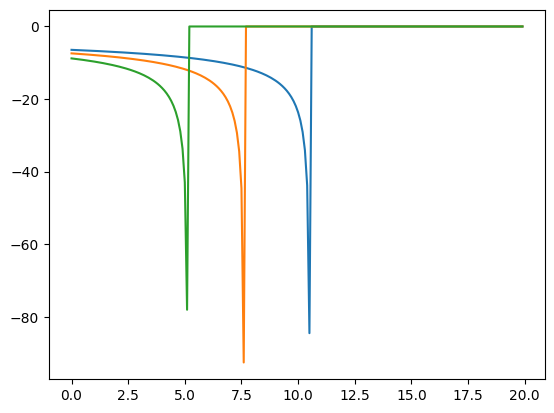

In [49]:
test = EnergyDeriv(x0,120)
test2 = EnergyDeriv(x0,100)
test3 = EnergyDeriv(x0,80)
plt.plot(x0,test)
plt.plot(x0,test2)
plt.plot(x0,test3)

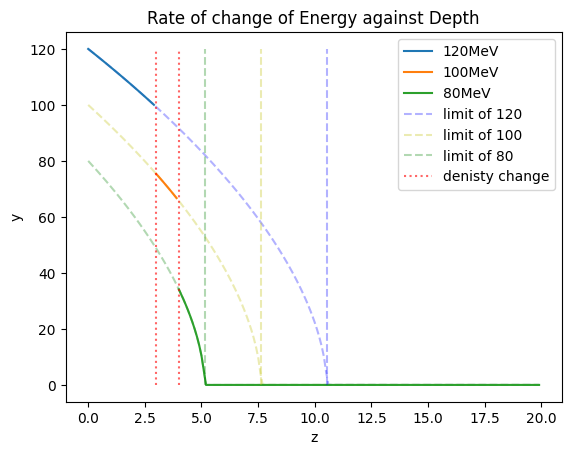

In [50]:
plt.plot(x0,y0 ,alpha = 0.3,linestyle = "dashed", color = "b")
plt.plot(x0,y02, alpha = 0.3,linestyle = "dashed", color = "y")
plt.plot(x0,y03,alpha = 0.3,linestyle = "dashed", color = "g")

# h = 0.001
# yPrime = (EnergyDeriv(x+h,120) - EnergyDeriv(x,120))/h
# print(yPrime)


plt.plot(x1,yE,label = "120MeV")
plt.plot(x2,yE2, label = "100MeV")
plt.plot(x3,yE3, label = "80MeV")

plt.vlines(x = rZero1,ymin =0,ymax =max(yE), color = "b", linestyle = "--",alpha = 0.3,label = "limit of 120")
plt.vlines(x = rZero2,ymin =0,ymax =max(yE), color = "y", linestyle = "--",alpha = 0.3,label = "limit of 100")
plt.vlines(x = rZero3,ymin =0,ymax =max(yE), color = "g", linestyle = "--",alpha = 0.3,label = "limit of 80")

plt.vlines(x = phi1,ymin =0,ymax =max(yE), color = "r", linestyle = ":",alpha = 0.6, label = "denisty change")
plt.vlines(x = phi2,ymin =0,ymax =max(yE), color = "r", linestyle = ":",alpha = 0.6)


plt.title("Rate of change of Energy against Depth")
plt.xlabel("z")
plt.ylabel("y")
plt.legend(loc = "best")
plt.show()

# make the iterations of alpha here and also stich the curves together no discontinous

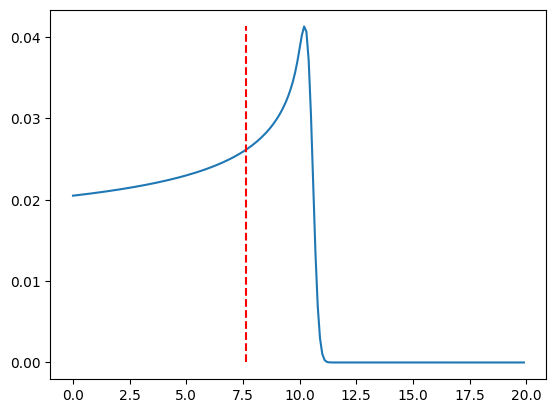

In [51]:
eZero = 100
rZero = alpha*(eZero**p)
p = 1.77
plt.figure()

y = FunctionbRho(x0,120,997)
plt.plot(x0,y)

plt.vlines(x = rZero,ymin =0,ymax =max(y), color = "r", linestyle = "dashed")

In [52]:
# rho1 = 997
# rho2 = 997*2
# rho3 = 997

# phi1Lim = 3
# phi2Lim = 4
# phi3Lim = 20

# x0 = np.arange(0,20,0.1)
# x1 = np.arange(0,phi1Lim,0.1)
# x2 = np.arange(phi1Lim -0.1,phi2Lim,0.1)
# x3 = np.arange(phi2Lim -0.1,phi3Lim,0.1)

# y0 = HomemadeRho(x0,120,rho1) #control 
# y1 = HomemadeRho(x1,120,rho1)
# e1 = int(EnergyLeft(phi1Lim,120))
# print(e1)
# y2 = HomemadeRho(x2,e1, rho2)
# print(y2)
# e2 = (EnergyLeft(phi2Lim,e1))
# print(e2)
# y3 = HomemadeRho(x3,e2, rho3)
# print(y3)
# plt.plot(x0,y0,color = "k", label = "control", linestyle = "dashed")
# plt.plot(x1,y1, label = "desity = "+ str(rho1))
# plt.plot(x2,y2, label = "desity = "+ str(rho2))
# plt.plot(x3,y3, label = "desity = "+ str(rho3))

# plt.vlines(phi1Lim,0,max(y0), linestyle = "dashed", color = "r", label = "Phi 1 Limit", alpha = 0.4)
# plt.vlines(phi2Lim,0,max(y0), linestyle = "dashed", color = "r", label = "Phi 2 Limit", alpha = 0.4)
# plt.vlines(phi3Lim,0,max(y0), linestyle = "dashed", color = "r", label = "Phi 3 Limit", alpha = 0.4)
# plt.vlines(0,0,max(y0), linestyle = "dashed", color = "r", alpha = 0)
# plt.legend(bbox_to_anchor =(1.3,1))

# plt.title("Rho Adv")
# plt.xlabel("")

# plt.fill_between(x0, 0, y0, alpha = 0.1)

# plt.show()

In [53]:
# RhoAdv()


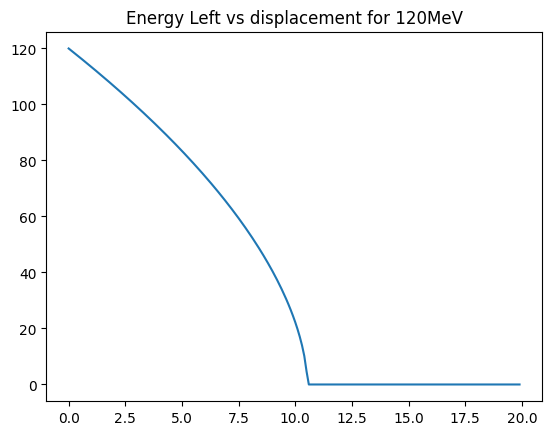

In [54]:
plt.figure()
x = np.arange(0,20,0.1)
plt.plot(x,EnergyLeft(x,120))
plt.title("Energy Left vs displacement for 120MeV")
plt.show()

In [55]:
def test(x,eZero, rho):
    
    epsilon = 0
    e_2 = rho
    p = 1.77
    #secondaryData - variables that have used "primary" unchaning variables (rho included in primary)
    rZero = alpha*(pow(eZero,p))*1

    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    sigma = 0.1085
    rZero = 10.5335
    eta = (rZero -x)/sigma
    phiZero = 1 + beta*(rZero)
    
    #Parabolic Cylinder Function 
    curlyD,derivCurlyD = scipy.special.pbdv((-1/p), (-1*eta))
    curlyD2,deivCurlyD2 = scipy.special.pbdv((-1/p-1),(-1*eta))
    
    print(curlyD[0])
    print(curlyD2[0])
    #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2) *np.exp((-1*(eta)**2)/4)
    y =  (phiZero)*np.exp((-1*(eta)**2)/4)*(sigma**(1/p))*(math.gamma(1/p))*(
    1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
    ((1/sigma)*(curlyD))+((beta/p)+(gamma*beta)+epsilon/rZero)*curlyD2)
    return(curlyD, eta)

In [56]:
# z = np.arange(0.1,20.1,0.1)
# a,eta = test(z,120,997)
# plt.plot(z,a)
# print(z)
# plt.figure()
# plt.plot(z,eta)

In [57]:
# def Tristan(z):
#     p = 1.77
#     sigma = 0.1085
#     rZero = 10.5335
#     eta = (rZero -z)/sigma
#     curlyD,derivCurlyD = scipy.special.pbdv((-1/p), (-1*eta))
#     curlyD2,deivCurlyD2 = scipy.special.pbdv((-1/p-1),(-1*eta))
#     return(curlyD2)

In [58]:
# z = np.arange(0,20,0.1)
# d = Tristan(z)
# plt.plot(z,d)


In [59]:
# rho1 = 997
# x0 = np.arange(0,20,0.1)
# y0 = FunctionbRho(x0,120,rho1) #control 
# plt.plot(x0,y0)

In [60]:
def RhoBasic():
    rho1 = 997
    rho2 = 997*2
    rho3 = 997

    phi1Lim = 7
    phi2Lim = 10
    phi3Lim = 20

    x0 = np.arange(0,20,0.1)
    x1 = np.arange(0,phi1Lim,0.1)
    x2 = np.arange(phi1Lim -0.1,phi2Lim,0.1)
    x3 = np.arange(phi2Lim -0.1,phi3Lim,0.1)

    y0 = FunctionbRho(x0,120,rho1) #control 
    y1 = FunctionbRho(x1,120,rho1)
    e1 = EnergyLeft(phi1Lim,120)
    y2 = FunctionbRho(x2,120, rho2)
    e2 = EnergyLeft(phi2Lim,120)
    y3 = FunctionbRho(x3,120+e2, rho3)

    plt.plot(x0,y0,color = "k", label = "control", linestyle = "dashed")
    plt.plot(x1,y1, label = "desity = "+ str(rho1))
    plt.plot(x2,y2, label = "desity = "+ str(rho2))
    plt.plot(x3,y3, label = "desity = "+ str(rho3))

    plt.vlines(phi1Lim,0,max(y0), linestyle = "dashed", color = "r", label = "Phi 1 Limit", alpha = 0.4)
    plt.vlines(phi2Lim,0,max(y0), linestyle = "dashed", color = "r", label = "Phi 2 Limit", alpha = 0.4)
    plt.vlines(phi3Lim,0,max(y0), linestyle = "dashed", color = "r", label = "Phi 3 Limit", alpha = 0.4)
    plt.vlines(0,0,max(y0), linestyle = "dashed", color = "r", alpha = 0)
    plt.legend(bbox_to_anchor =(1.3,1))
    
    plt.title("Rho Basic")
    plt.xlabel("")
    
    plt.fill_between(x0, 0, y0, alpha = 0.1)
    
    plt.show()

In [61]:
#RhoBasic()

# N = 8 vs N = 16

In [62]:
df16 = pd.read_csv("Tristan_ChebNodesNEquals16.csv")
df8 = pd.read_csv("Tristan_ChebNodesNEquals8.csv")

[0.1168, 0.1193, 0.1237, 0.1292, 0.1351, 0.1403, 0.1442, 0.1463]
0.000283284565
II 9.21e-05
lower,importantIndex,lowerBoundIndex 10.05 100 100
0.0002891082
0.0002994909
0.000312313665
0.0003259316
0.00033786556999999996
0.000346630245
0.00035172386500000003
II 7.48e-05


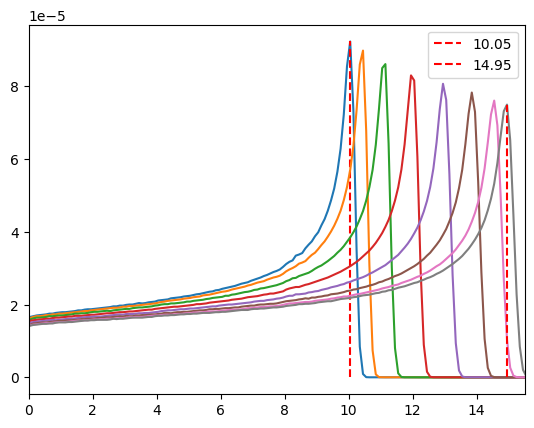

The unconstrained solution is optimal.
Final cost 3.7021e-39, first-order optimality 2.75e-28


Text(0.5, 1.0, 'n = 8, Tristan_ChebNodes Data Intensity Optimised SOBP Plot')

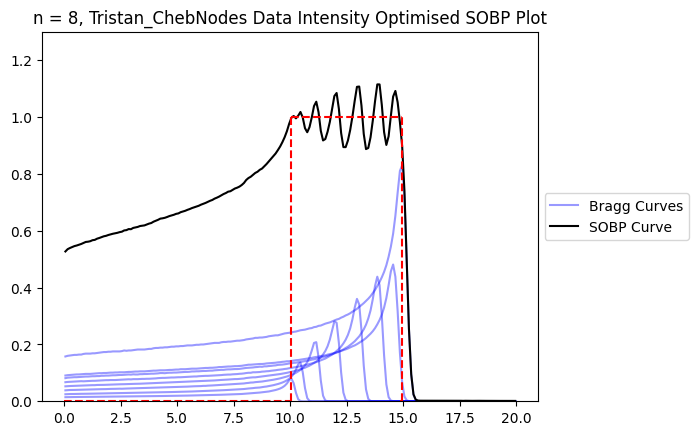

In [63]:
df8 = pd.read_csv("Tristan_ChebNodesNEquals8.csv")
df = df8.dropna()
n = 8 
dose = 1
#get evals

eVals = list(df.columns)[2:len(df.columns)]

#convert to float list

for i in range(len(eVals)):
    eVals[i] = float(eVals[i])
print(eVals)

#define x and clean

x = df.iloc[:,[1]].astype(float)
x = x.dropna()
x = x.to_numpy()
x = np.reshape(x, -1)
x = list(x)

#find max and hence upper lower
for i in range(n): # for all values
    #get y and clean 
    y = df.iloc[:,2+i].astype(float)
    #print(s(y.iloc[3]))
    y = y.dropna()
    y = y.to_numpy()
    plt.plot(x,y)
    
    val = np.trapz(y,x)
    print(val)

    
    
    if i ==0 or i == 7:
        importantIndexValue = max(y)
        print("II", importantIndexValue)
        for j in range(len(y)):
            if y[j] == importantIndexValue:
                importantIndex = j
                plt.vlines(x[importantIndex],0,max(y), linestyle = "dashed", color = "r", label = str(x[importantIndex]))
                if i == 0:
                    lower = x[importantIndex]
                    lowerBoundIndex = importantIndex
                    print("lower,importantIndex,lowerBoundIndex",lower,importantIndex,lowerBoundIndex)
                elif i == n-1:
                    upper = x[importantIndex]
                    upperBoundIndex = importantIndex

plt.legend()
plt.xlim([0,15.5])
plt.show()
#trim x
x2 = x[lowerBoundIndex:upperBoundIndex]#
#print(lower, upper,dose,lowerBoundIndex, upperBoundIndex , x,x2)
m,omega,f,d =OptimiseLAbPanosData(lower, upper,dose,eVals,lowerBoundIndex, upperBoundIndex ,x,x2,df)
plt.title("n = 8, Tristan_ChebNodes Data Intensity Optimised SOBP Plot")

In [64]:
print("weights:",omega)

weights: [  866.83808812  1517.55954473  2420.69216575  3394.63744292
  4473.89728001  5610.88120061  6337.22212758 11100.17605344]


In [65]:
def T(df,n):
    df = df.dropna()
    dose = 1
    #get evals

    eVals = list(df.columns)[2:len(df.columns)]

    #convert to float list

    for i in range(len(eVals)):
        eVals[i] = float(eVals[i])
    print(eVals)

    #define x and clean

    x = df.iloc[:,[1]].astype(float)
    x = x.dropna()
    x = x.to_numpy()
    x = np.reshape(x, -1)
    x = list(x)

    #find max and hence upper lower
    for i in range(n): # for all values
        #get y and clean 
        y = df.iloc[:,2+i].astype(float)
        y = y.dropna()
        y = y.to_numpy()
        plt.plot(x,y)
        if i ==0 or i == n-1:
            importantIndexValue = max(y)
            print("II", importantIndexValue)
            for j in range(len(y)):
                if y[j] == importantIndexValue:
                    importantIndex = j
                    plt.vlines(x[importantIndex],0,max(y), linestyle = "dashed", color = "r", label = str(x[importantIndex]))
                    if i == 0:
                        lower = x[importantIndex]
                        lowerBoundIndex = importantIndex
                        #print("lower,importantIndex,lowerBoundIndex",lower,importantIndex,lowerBoundIndex)
                    elif i == n-1:
                        upper = x[importantIndex+1]
                        upperBoundIndex = importantIndex

    plt.legend()
    plt.xlim([0,15.5])
    plt.show()
    #trim x
    x2 = x[lowerBoundIndex:upperBoundIndex]#
    #print(lower, upper,dose,lowerBoundIndex, upperBoundIndex , x,x2)
    m,omega,f,d =OptimiseLAbPanosData(lower, upper,dose,eVals,lowerBoundIndex, upperBoundIndex ,x,x2,df)
    plt.title("n = "+str(n)+", Tristan_ChebNodes Data Intensity Optimised SOBP Plot")

    return(m,omega,f,d)

In [66]:
# m,omega,f,d =T(df8,8)
# print("weights:",omega)

In [67]:
# m,omega,f,d =T(df16,16)
# print("weights:",omega)

In [68]:
print("omega:", omega) 

omega: [  866.83808812  1517.55954473  2420.69216575  3394.63744292
  4473.89728001  5610.88120061  6337.22212758 11100.17605344]


# Removing positive definite constraint on Linear system

In [69]:
# for i in range((8)):
#     plt.plot(x,GetPanosDataNotTrimmed(eVals[i], lowerBoundIndex, upperBoundIndex,df), color = "b", alpha = 0.4)
#     d.append(omega[i]*GetPanosDataNotTrimmed(eVals[i], lowerBoundIndex, upperBoundIndex,df))
# plt.plot(x,sum(d), color = "k", label = "SOBP")
# PlotCustomBox(lower,upper,dose)

In [70]:
def TNegative(df,n):
    df = df.dropna()
    dose = 1
    #get evals

    eVals = list(df.columns)[2:len(df.columns)]

    #convert to float list

    for i in range(len(eVals)):
        eVals[i] = float(eVals[i])
    print(eVals)

    #define x and clean

    x = df.iloc[:,[1]].astype(float)
    x = x.dropna()
    x = x.to_numpy()
    x = np.reshape(x, -1)
    x = list(x)

    #find max and hence upper lower
    for i in range(n): # for all values
        #get y and clean 
        y = df.iloc[:,2+i].astype(float)
        y = y.dropna()
        y = y.to_numpy()
        plt.plot(x,y)
        if i ==0 or i == n-1:
            importantIndexValue = max(y)
            print("II", importantIndexValue)
            for j in range(len(y)):
                if y[j] == importantIndexValue:
                    importantIndex = j
                    plt.vlines(x[importantIndex],0,max(y), linestyle = "dashed", color = "r", label = str(x[importantIndex]))
                    if i == 0:
                        lower = x[importantIndex]
                        lowerBoundIndex = importantIndex
                        #print("lower,importantIndex,lowerBoundIndex",lower,importantIndex,lowerBoundIndex)
                    elif i == n-1:
                        upper = x[importantIndex+1]
                        upperBoundIndex = importantIndex

    plt.legend()
    plt.xlim([0,15.5])
    plt.show()
    #trim x
    x2 = x[lowerBoundIndex:upperBoundIndex]#
    #print(lower, upper,dose,lowerBoundIndex, upperBoundIndex , x,x2)
    m,omega,f,d =OptimiseLAbPanosDataNegativeWeights(lower, upper,dose,eVals,lowerBoundIndex, upperBoundIndex ,x,x2,df)
    plt.title("n = "+str(n)+", Tristan_ChebNodes Data Intensity Optimised SOBP Plot WITH NEGATIVE WEIGHTS ALLOWED")

    return(m,omega,f,d)

In [71]:
def OptimiseLAbPanosDataNegativeWeights(lower, upper,dose, eVals,lowerBoundIndex, upperBoundIndex , xFull,x,df): 
    # definine variables 
    n = len(eVals)
#     if upper-lower  <= 4 and upper <5:
#         z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.01)
#     else:
#         z = np.arange(0,(alpha)*(max(eVals)**p)*1.3,0.1)
        
    m = np.zeros((n,n), dtype = float) #empty matrix 
    dList = [] #stores d_i's
    f = np.arange(n, dtype = float)
    #set f to 0
    for i in range(len(f)):
        f[i]= 0
    
    #######################################################################################
    # QUADRATURE for m
    
    for i in range(n): # for n evalues 
        for j in range(n): # for n evaleus 
            
            y_i = Function3bPanosData(eVals[i],eVals[j],lowerBoundIndex, upperBoundIndex,df)
            #print(y_i,x) 
            val = np.trapz(y_i,x)
            #val,err = integrate.quad(Function3bPanosData,lower,upper, args = ())
            m[i,j] = val
    
   
    #######################################################################################
    # QUADRATURE for f 
    for j in range(n): # for all the eValues
        #GetPanosData
        y_i = GetPanosData(eVals[j],lowerBoundIndex,upperBoundIndex,df)
        val = np.trapz(y_i,x)
        #print("Val:", val)
        #val,err = integrate.quad(FunctionH202,lower,upper,args = (eVals[j]))
        #print("Val:",val)
        f[j] =val*dose
   
    
    ######################################################################################
    # MINIMISING

    #res = lsq_linear(m, f, bounds=np.array([(0,np.inf) for i in range(n)]).T, lsmr_tol='auto', verbose=1)
    omega = np.linalg.solve(m,f)
    #omega = res.x

    
    ######################################################################################
    # PLOTTING INDIVIDUAL BRAGG PEAKS
    
    for i in range(len(omega)):  #for all the weights 
        #omega[i] * GetPanosData[eVals[i]]
        dList.append((omega[i]*GetPanosDataNotTrimmed(eVals[i],lowerBoundIndex,upperBoundIndex,df))) #collect the di's
        if i == 0:
            plt.plot(xFull,dList[i], label = "Bragg Curves", color = "blue", alpha = 0.4)
        else:
            plt.plot(xFull,dList[i], color = "blue", alpha = 0.4)

    #######################################################################################
    # PLOTTING SPREAD OUT BRAGG PEAK and extras 
    
    d = sum(dList) #sum the di's
    plt.plot(xFull,d, label = "SOBP Curve", color = "k") #plot
    
    #details
    PlotCustomBox(upper,lower,dose) # plot target box
    plt.title("Panos Data Intensity Optimized SOBP Plot")
    plt.hlines(y=0,xmin = 0,xmax = lower, color='r', linestyles='dashed')
    plt.hlines(y=0,xmin = upper,xmax = x[len(x)-1], color='r', linestyles='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim([0,dose*1.3])
    #plt.xlim([0,18])
    
    return(m,omega,f,d)


In [72]:
# m,omega,f,d = TNegative(df16,16)

In [73]:
# print("weights:", omega)

# Testing

In [74]:
# x = np.arange(0,20,0.1)
# y = FunctionbRho(x,120,997)
# plt.plot(x,y)

# Implementing the New "Homemade" Parabolic Cylinder Function 

In [75]:
def HyperG(a,b,z):
    epsi = 0.00001
    hypergeom = 1
    term_i = 1
    for i in range(1,1000):
        term_i = term_i*(a+i-1)*z/(b+i-1)/i
        hypergeom = hypergeom + term_i
        if(abs(term_i) <= epsi*hypergeom):
            out = hypergeom
            return(out)
    return("No convergence in HyperG")


In [76]:
def Cyl_Gauss(a,z):
    asympt = 0
    asympt_2 = 0 
    branch = 4
    nterm = 6
    if ((a >= 0.) | (a <= -2.)):
        return("param out of range")
    elif(abs(z) >= branch):
        
        z_square = z*z;
        nterm_2 = int(nterm*branch/abs(z));

        asympt = 1.;
        term_i = 1.;
        u = a;
        for i in range(1,nterm):
            term_i = term_i * u*(1-u)/(2*i*z_square)
            asympt = asympt + term_i
            u = a
        if z >= 0:
            out = np.exp(-z_square/2)* z**a * asympt
        else:
            asympt_2 = 1
            term_i = 1
            u = a + 1
        
        for i in range(1,nterm_2):
            term_i = term_i * u*(1-u)/(2*i*z_square)
            asympt_2 = asympt_2 + term_i
            u = u + 2
            
        out = math.cos(math.pi*a)* math.exp(-z_square/2)* (-z)**a * asympt + math.sqrt(2.*math.pi) / math.gamma(-a) * (-z)**(-a-1.) * asympt_2;
        #out = cos(pi*a) * exp(-z_square/2.) * (-z)**a * asympt + sqrt(2.*pi) / gamma(-a) * (-z)**(-a-1.) * asympt_2;
    else:    # use Taylor series
        c1 = 0.5;
        c2 = 1.5;
        term1 = math.sqrt(math.pi)/math.gamma((1.-a)/2.) * HyperG(c1+a/2.,c1,-z**2/2.);
        term2 = math.sqrt(2.*math.pi)*z/math.gamma(-a/2.) * HyperG(c2+(a-1.)/2.,c2,-z**2/2.);
        out = 2**(a/2.) * (term1-term2);
    return(out)

In [77]:
# eta

In [78]:
# a = []
# for i in range(len(eta)):
#     a.append(Cyl_Gauss(-1/p,-eta[i]))
# plt.plot(z,a)

# Example of Difference Between the old and new Parabolic Cylinder Functions

C:\Users\noelh\AppData\Local\Temp\ipykernel_22868\4178746248.py:32: RuntimeWarning: invalid value encountered in scalar power
  out = math.cos(math.pi*a)* math.exp(-z_square/2)* (-z)**a * asympt + math.sqrt(2.*math.pi) / math.gamma(-a) * (-z)**(-a-1.) * asympt_2;


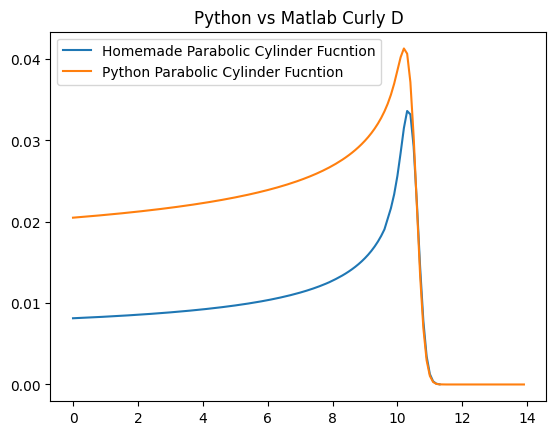

In [79]:
def HomemadeCurlyD(x,eZero):
    a = []
    b = []
    y = []
    
    p = 1.77
    alpha = 0.0022
    beta = 0.012
    gamma = 0.6
    epsilon = 0 #ranges 0.0 to 0.2
    e_2 = 997 # density of the medium 
    sd = 0.01

    #secondaryData - variables that have used "primary" unchaning variables (rho included in primary)
    rZero = alpha*(pow(eZero,p))*1
        
    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -x)/sigma
    phiZero = 1 + beta*(rZero)

    #Parabolic Cylinder Function 
    #curlyD,derivCurlyD = scipy.special.pbdv((1-p), (-1*eta))
    #curlyD2,deivCurlyD2 = scipy.special.pbdv(((-1/p)-1),(-1*eta))
    for i in range(len(eta)):
        a.append(Cyl_Gauss(-1/p,-eta[i]))
        b.append(Cyl_Gauss(((-1/p)-1),(-1*eta[i])))
        curlyD = a[i]
        curlyD2 = b[i]
        #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
        y.append((phiZero)*(sigma**(1/p))*(math.gamma(1/p))*(
        1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
        ((1/sigma)*(Cyl_Gauss(-1/p,-eta[i])))+((beta/p)+(gamma*beta)+epsilon/rZero)*
        Cyl_Gauss(((-1/p)-1),(-1*eta[i]))))
    
    return(y)


x = np.arange(0,14,0.1)
plt.plot(x,HomemadeCurlyD(x,120), label = "Homemade Parabolic Cylinder Fucntion")
plt.plot(x,Functionb(x,120),label = "Python Parabolic Cylinder Fucntion")
plt.title("Python vs Matlab Curly D")
plt.legend(loc = "best")


# Change Of Density Differences with New and Old Parabolic cylinder Fucntion Method

In [80]:
def HomemadeRho(x,eZero, rho):
    #print("x",x,"eZero",eZero,"rho",rho)
    
    a = []
    b = []
    y = []
    
    e_2 = rho
    
    #secondaryData - variables that have used "primary" unchaning variables (rho included in primary)
    rZero = alpha*(pow(eZero,p))*1
        
    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -x)/sigma
    phiZero = 1 + beta*(rZero)
    
    for i in range(len(eta)):
        a.append(Cyl_Gauss(-1/p,-eta[i]))
        b.append(Cyl_Gauss(((-1/p)-1),(-1*eta[i])))
        curlyD = a[i]
        curlyD2 = b[i]
        #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
        y.append((phiZero)*(sigma**(1/p))*(math.gamma(1/p))*(
        1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
        ((1/sigma)*(Cyl_Gauss(-1/p,-eta[i])))+((beta/p)+(gamma*beta)+epsilon/rZero)*
        Cyl_Gauss(((-1/p)-1),(-1*eta[i]))))
    
    return(y)

In [81]:

def Functionb(x,eZero, rho):
    a = []
    b = []
    y = []
    
    e_2 = rho
    
    #secondaryData - variables that have used "primary" unchaning variables (rho included in primary)
    rZero = alpha*(pow(eZero,p))*1
        
    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -x)/sigma
    phiZero = 1 + beta*(rZero)
    
    for i in range(len(eta)):
        a.append(Cyl_Gauss(-1/p,-eta[i]))
        b.append(Cyl_Gauss(((-1/p)-1),(-1*eta[i])))
        curlyD = a[i]
        curlyD2 = b[i]
        #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
        #print("Functionb, CylGaus:",Cyl_Gauss(((-1/p)-1),(-eta[i])))
        y.append((phiZero)*(sigma**(1/p))*(math.gamma(1/p))*(
        1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
        ((1/sigma)*(Cyl_Gauss(-1/p,-eta[i])))+((beta/p)+(gamma*beta)+epsilon/rZero)*
        Cyl_Gauss(((-1/p)-1),(-eta[i]))))
    
    return(y)

In [82]:
# rho1 = 997
# rho2 = 997*2

# phi1Lim = 7
# phi2Lim = 10


# x1 = np.arange(0,phi1Lim,0.1)
# x2 = np.arange(phi1Lim -0.1,phi2Lim,0.1)

# y1 = HomemadeRho(x1,120,rho1)
# e1 = int(EnergyLeft(phi1Lim,120))

# print(x2)
# y2 = HomemadeRho(x2,e1, rho2)


# plt.plot(x1,y1)
# plt.plot(x2,y2)
# plt.ylim([0,0.012])

In [83]:
def RhoAdv():
    rho1 = 997
    rho2 = 997*2
    rho3 = 997

    phi1Lim = 7
    phi2Lim = 10
    phi3Lim = 20

    x0 = np.arange(0,20,0.1)
    x1 = np.arange(0,phi1Lim,0.1)
    x2 = np.arange(phi1Lim -0.1,phi2Lim,0.1)
    x3 = np.arange(phi2Lim -0.1,phi3Lim,0.1)

    y0 = HomemadeRho(x0,120,rho1) #control 
    y1 = HomemadeRho(x1,120,rho1)
    e1 = int(EnergyLeft(phi1Lim,120))
    print("e1",e1)
    y2 = HomemadeRho(x2,120, rho2)
    print(y2)
    e2 = (EnergyLeft(phi2Lim,e1))
    y3 = HomemadeRho(x3,120, rho3)

    plt.plot(x0,y0,color = "k", label = "control", linestyle = "dashed")
    plt.plot(x1,y1, label = "desity = "+ str(rho1))
    plt.plot(x2,y2, label = "desity = "+ str(rho2))
    plt.plot(x3,y3, label = "desity = "+ str(rho3))

    plt.vlines(phi1Lim,0,max(y0), linestyle = "dashed", color = "r", label = "Phi 1 Limit", alpha = 0.4)
    plt.vlines(phi2Lim,0,max(y0), linestyle = "dashed", color = "r", label = "Phi 2 Limit", alpha = 0.4)
    plt.vlines(phi3Lim,0,max(y0), linestyle = "dashed", color = "r", label = "Phi 3 Limit", alpha = 0.4)
    plt.vlines(0,0,max(y0), linestyle = "dashed", color = "r", alpha = 0)
    plt.legend(bbox_to_anchor =(1.3,1))
    
    plt.title("Rho Adv")
    plt.xlabel("")
    
    plt.fill_between(x0, 0, y0, alpha = 0.1)
    
    plt.show()

# New Function

C:\Users\noelh\AppData\Local\Temp\ipykernel_22868\4178746248.py:32: RuntimeWarning: invalid value encountered in scalar power
  out = math.cos(math.pi*a)* math.exp(-z_square/2)* (-z)**a * asympt + math.sqrt(2.*math.pi) / math.gamma(-a) * (-z)**(-a-1.) * asympt_2;


e1 64
[0.0055897088074617456, 0.00564513894514754, 0.005703076748664533, 0.005763706594951357, 0.005827232401124616, 0.005893880375255188, 0.005963902256621891, 0.006037579151984655, 0.006115226102141027, 0.006197197549229415, 0.0062838939229290635, 0.00637990862513517, 0.006477960704167756, 0.006582380101311984, 0.006693867250893995, 0.006813236118588295, 0.006941439182715643, 0.00707959952570077, 0.007229052573469045, 0.007391401132960752, 0.007568358236816262, 0.007762695736447996, 0.007977191816317218, 0.00821557343027932, 0.008482684895425743, 0.008784700888702337, 0.009130015012727952, 0.009530179158116443, 0.010175796055400206, 0.010831775948457951, 0.011687040365081832]


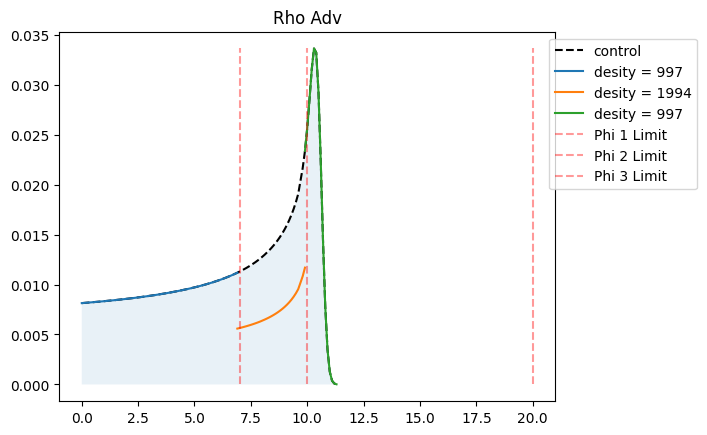

In [84]:

RhoAdv()

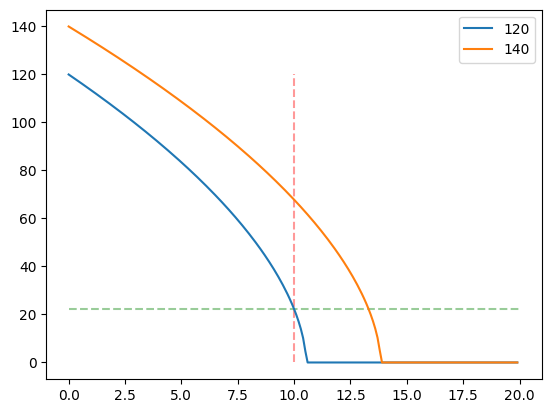

In [85]:
y = EnergyLeft(x0,120)
y3 = EnergyLeft(x0,140)
plt.vlines(10,0,max(y),linestyles="dashed", color = "r", alpha = 0.4)
plt.hlines(22.249,0,20,linestyles="dashed", color = "g", alpha = 0.4)


plt.plot(x0,y,label = "120")
plt.plot(x0,y3, label = "140")
plt.legend(loc = "best")

40.399


C:\Users\noelh\AppData\Local\Temp\ipykernel_22868\4178746248.py:32: RuntimeWarning: invalid value encountered in scalar power
  out = math.cos(math.pi*a)* math.exp(-z_square/2)* (-z)**a * asympt + math.sqrt(2.*math.pi) / math.gamma(-a) * (-z)**(-a-1.) * asympt_2;


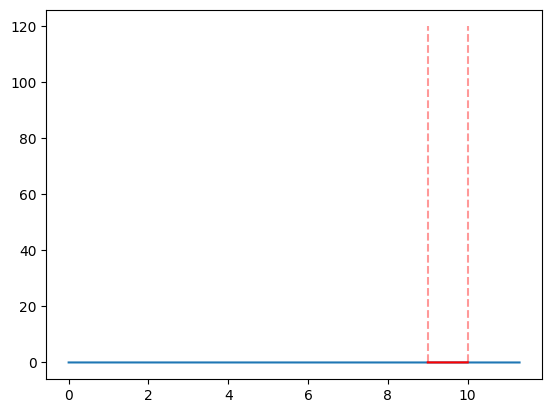

In [86]:
e1 = 64 #as found from the cell above x2
y = HomemadeRho(x0,120,997)
plt.plot(x0,y)
e2 = EnergyLeft(9,120)
x1 = np.arange(9,10.1,0.1)
y1 = HomemadeRho(x1,120,997)

plt.vlines(9,0,max(y0), linestyle = "dashed", color = "r", label = "10", alpha = 0.4)
plt.vlines(10,0,max(y0), linestyle = "dashed", color = "r", label = "11", alpha = 0.4)


plt.plot(x1,y1,color = "r")

print(e2)

Now find the Value of e2 worth of energy in the next curve

C:\Users\noelh\AppData\Local\Temp\ipykernel_22868\4178746248.py:32: RuntimeWarning: invalid value encountered in scalar power
  out = math.cos(math.pi*a)* math.exp(-z_square/2)* (-z)**a * asympt + math.sqrt(2.*math.pi) / math.gamma(-a) * (-z)**(-a-1.) * asympt_2;


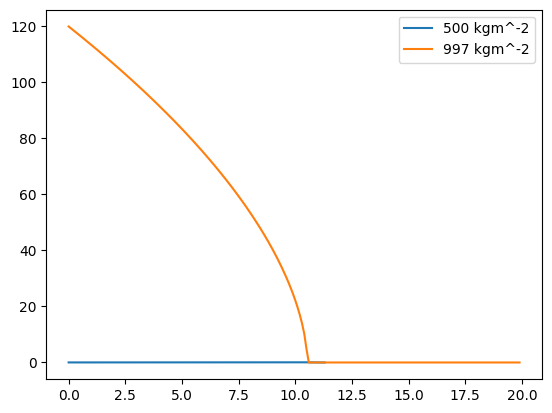

In [87]:
density = 500
y1 = HomemadeRho(x0,120,density)
plt.plot(x0,y1,label = str(density)+ " kgm^-2")
plt.plot(x0,y0,label = "997 kgm^-2")
plt.legend(loc = "best")

Remember Density is just a constant at the start of the equation. We need to change our p, alpha etc hence we need a different eZero in there instead of the same, and the eZero effectively changes if the alpha and p change

C:\Users\noelh\AppData\Local\Temp\ipykernel_22868\4178746248.py:32: RuntimeWarning: invalid value encountered in scalar power
  out = math.cos(math.pi*a)* math.exp(-z_square/2)* (-z)**a * asympt + math.sqrt(2.*math.pi) / math.gamma(-a) * (-z)**(-a-1.) * asympt_2;


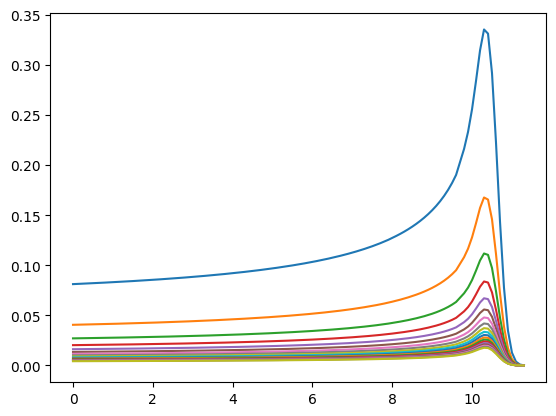

In [88]:
densityList = np.arange(100,2000,100)

for i in densityList:
    y_i = HomemadeRho(x0,120,i)
    plt.plot(x0,y_i, label = str(i)+ "kgm^-2")

above is the proof that the density is just a scaler relation.
Moving on, we must show the last "k" MeV. So as can be seen in the Green hline, we must us the end of the curve past the interception of the curve on the right in this plot


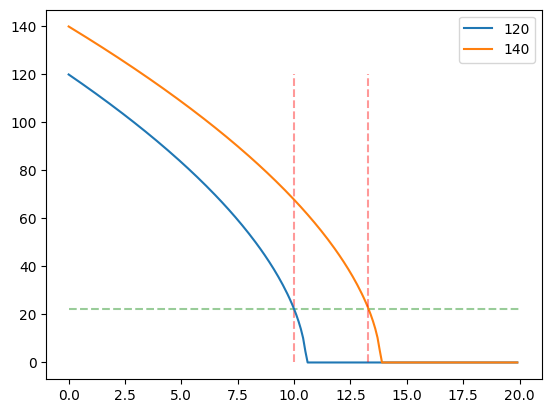

In [89]:
y = EnergyLeft(x0,120)
y3 = EnergyLeft(x0,140)
plt.vlines(10,0,max(y),linestyles="dashed", color = "r", alpha = 0.4)
plt.hlines(22.249,0,20,linestyles="dashed", color = "g", alpha = 0.4)


plt.plot(x0,y,label = "120")
plt.plot(x0,y3, label = "140")
plt.legend(loc = "best")

target = 22.249 
y3Target = abs(y3 - target)
closestAns = min(y3Target) + target
for i in range(len(y3)):
    if closestAns == y3[i]:
        importantIndexValue = i/10

plt.vlines(importantIndexValue,0,max(y),linestyles="dashed", color = "r", alpha = 0.4)

All Together ...

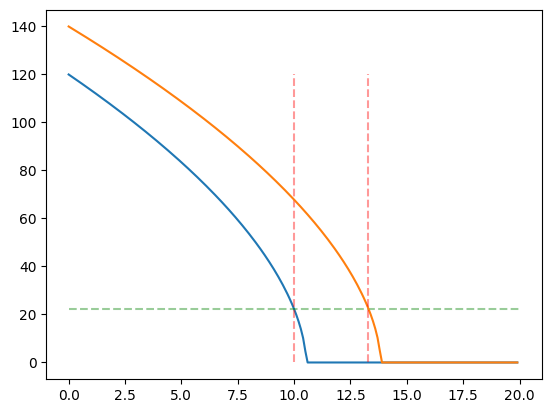

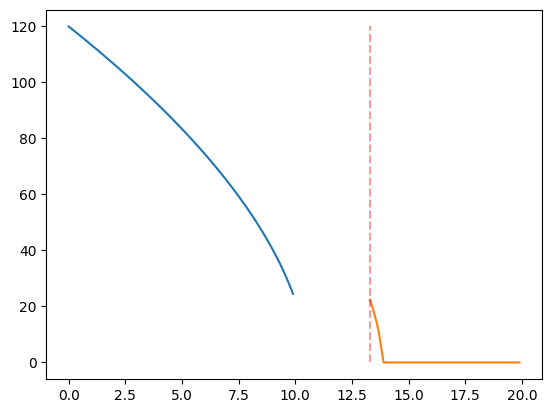

In [90]:
x0 = np.arange(0,20,0.1)
y0 = EnergyLeft(x0,120)
plt.plot(x0,y0)
phi1Lim = 10
plt.vlines(phi1Lim,0,max(y),linestyles="dashed", color = "r", alpha = 0.4)
e1 = EnergyLeft(phi1Lim,120)
plt.hlines(e1,0,20,linestyles="dashed", color = "g", alpha = 0.4)

## second curve aka secodn density 
phi2Lim = phi1Lim + 1
y1 = EnergyLeft(x0,140)
plt.plot(x0,y1)
#find the energy value

target = e1
y3Target = abs(y3 - target)
closestAns = min(y3Target) + target
for i in range(len(y3)):
    if closestAns == y3[i]:
        importantIndexValue = i/10

plt.vlines(importantIndexValue,0,max(y),linestyles="dashed", color = "r", alpha = 0.4)
plt.show()

#all together 
plt.figure()
x1 = np.arange(0,phi1Lim,0.1)
x2 = np.arange(importantIndexValue,20,0.1)
y1 = EnergyLeft(x1,120)
y2 = EnergyLeft(x2,140)
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.vlines(importantIndexValue,0,max(y),linestyles="dashed", color = "r", alpha = 0.4)

plt.show()

[2.23510148e+01 1.98988192e+01 1.71875629e+01 1.40963781e+01
 1.03581958e+01 4.99166034e+00 1.00000000e-07 1.00000000e-07
 1.00000000e-07 1.00000000e-07 1.00000000e-07 1.00000000e-07
 1.00000000e-07 1.00000000e-07 1.00000000e-07 1.00000000e-07
 1.00000000e-07 1.00000000e-07 1.00000000e-07 1.00000000e-07
 1.00000000e-07 1.00000000e-07 1.00000000e-07 1.00000000e-07
 1.00000000e-07 1.00000000e-07 1.00000000e-07 1.00000000e-07
 1.00000000e-07 1.00000000e-07 1.00000000e-07 1.00000000e-07
 1.00000000e-07 1.00000000e-07 1.00000000e-07 1.00000000e-07
 1.00000000e-07 1.00000000e-07 1.00000000e-07 1.00000000e-07
 1.00000000e-07 1.00000000e-07 1.00000000e-07 1.00000000e-07
 1.00000000e-07 1.00000000e-07 1.00000000e-07 1.00000000e-07
 1.00000000e-07 1.00000000e-07 1.00000000e-07 1.00000000e-07
 1.00000000e-07 1.00000000e-07 1.00000000e-07 1.00000000e-07
 1.00000000e-07 1.00000000e-07 1.00000000e-07 1.00000000e-07
 1.00000000e-07 1.00000000e-07 1.00000000e-07 1.00000000e-07
 1.00000000e-07 1.000000

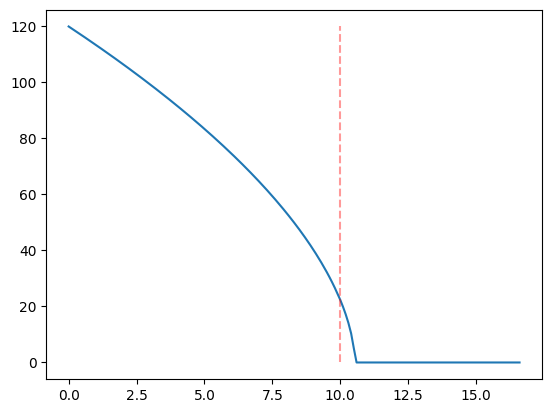

In [91]:
plt.figure()
#trimming the gap

print(y2)
y1 = list(y1)
y2 = list(y2)
for i in y2:
    y1.append(i)
print(y1)
x_i = np.arange(0,len(y1)/10,0.1)
plt.plot(x_i,y1)
plt.vlines(10,0,max(y),linestyles="dashed", color = "r", alpha = 0.4)

making this into a new funciton

In [92]:
def RhoRhoRhoYourBoat():
    # Some model parameters
    p = 1.77;
    alpha = 0.0022;
    beta = 0.012;
    
    # Beam energy
    eZero = 80;
    
    res = 0.1; #resolution
    
    #Densities
    rho0 = 997 #water
    rho1 = 1116; #Skin
    rho2 = 900; #Fat
    rho3 = 1084; #Muscle
    rho4 = 1900; #Bone
    rho5 = 394; #Lung
    
    #Proportions
    prop1 = 1116/rho0; #Skin
    prop2 = 900/rho0; #Fat
    prop3 = 1084/rho0; #Muscle
    prop4 = 1900/rho0; #Bone
    prop5 = 394/rho0; #Lung
    
    #effective eZero's
    eZero1 = prop1*eZero 
    eZero2 = prop2*eZero
    eZero3 = prop3*eZero
    eZero4 = prop4*eZero 
    eZero5 = prop5*eZero
    
    
    #Displacment of the Density Changes
    phi1Lim = 0.3;
    phi2Lim = 1.8;
    phi3Lim = 3.2;
    phi4Lim = 4;
    phi5Lim = 16;
    
    x0 = np.arange(0,16,res)
    x1 = np.arange(0,phi1Lim,res)
    x2 = np.arange(phi1Lim,phi2Lim,res)
    x3 = np.arange(phi2Lim,phi3Lim,res)
    x4 = np.arange(phi3Lim,phi4Lim,res)
    x5 = np.arange(phi4Lim,phi5Lim,res)
    
    
    y0 = FunctionbRho(x0,eZero,rho0);
    plt.plot(x0,y0,linestyle = ":", color = "k", label = "control")
    y1 = FunctionbRho(x1,eZero1,rho0);
    plt.plot(x1,y1,color = "b")
##    e1 = EnergyLeft(phi1Lim, eZero, alpha,p);
#     disp(e1)
    y2 = FunctionbRho(x2, eZero2,rho0);
    plt.plot(x2,y2,color = "g")
#     e2 = EnergyLeft(phi2Lim, eZero,alpha,p);
#     disp(e2)
    y3 = FunctionbRho(x3,eZero3,rho0);
    plt.plot(x3,y3,color = "b")
#     e3 = EnergyLeft(phi3Lim, eZero,alpha,p);
#     disp(e3)
    y4 = FunctionbRho(x4,eZero4,rho0);
    plt.plot(x4,y4,color = "g")
#     e4 = EnergyLeft(phi4Lim, eZero,alpha,p);
#     disp(e4)
    y5 = FunctionbRho(x5,eZero5,rho0);
    plt.plot(x5,y5,color = "b")
    
#     plot(x0,y0,"k--",x1,y1,x2,y2,x3,y3,x4,y4,x5,y5);
#     xline(phi1Lim,"r--")
#     xline(phi2Lim,"r--")
#     xline(phi3Lim,"r--")
#     xline(phi4Lim,"r--")
#     legend("Uniform water phantom", "Skin", "Fat","Muscle","Bone","Lung")
    plt.title("(Not) Realistic dose profile through skin/fat/muscle/bone/lung")
    #plot(x1,y1)

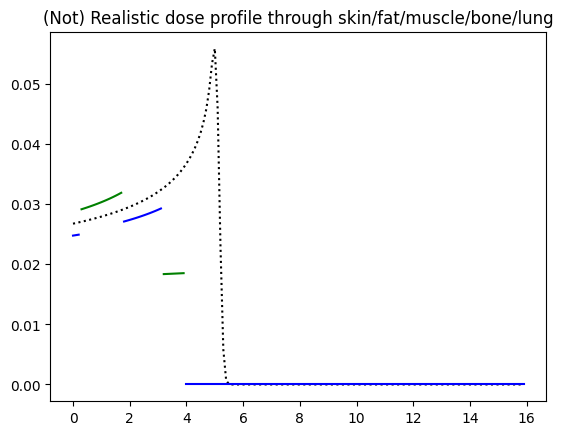

In [93]:
RhoRhoRhoYourBoat()

Leaving the above to be an example of what needs to be different, this is an example of all the eZeros being different (hence differeent p's and alpha's) and therefore the curves should mimic the differences but the curves have massive jumps and that is becuase we arent lining the energy values up correctly. Below is the associated energy values

I need a function that can stitch the curves together correctly now.... 

In [94]:
def JoinEnergyCurves(eZeroList,phiLimList, pList, alphaList):
    
    res = 0.1
    x0 = np.arange(0,30,res) #control 
    
    for i in range(len(eZeroList)):
        y0 = EnergyLeft(x0,eZeroList[i])
        plt.plot(x0,y0, label = str(eZeroList[i]) + "MeV")
    
    #plot energy value lines
    plt.vlines(phiLimList[0],0,max(y),linestyles="dashed", color = "r", alpha = 0.4)
    e1 = EnergyLeft(phiLimList[0],eZeroList[0])
    plt.hlines(e1,0,20,linestyles="dashed", color = "g", alpha = 0.4, label = " energy value at point lim")

    ## second curve aka second density 
    y1 = EnergyLeft(x0,eZeroList[1])
    #plt.plot(x0,y1, label = str(eZeroList[0])+"Mev")
    #find the energy value
    y3 = y1
    target = e1
    y3Target = abs(y3 - target)
    #print("Target",target)
    closestAns = min(y3Target)
    #print("ClostestAns",closestAns)
    for i in range(len(y3)):
        #print("y3[i]",abs(y3[i] - target), end = "                 : ")
        if closestAns == abs(y3[i]-target):
            importantIndexValue = i/10
    #print(y0)
    #print(y1)

    #print(importantIndexValue)
    plt.vlines(importantIndexValue,0,max(y),linestyles="dashed", color = "k", alpha = 1, label = "important index valeu")
    plt.legend(bbox_to_anchor = (1.5,0.5))
    plt.title("both Energy Curves with Valued limits")
    plt.show()
    

################################################
    #all together 
    plt.figure()
    x1 = np.arange(0,phiLimList[0],0.1)
    x2 = np.arange(importantIndexValue,20,0.1)
    y1 = EnergyLeft(x1,eZeroList[0])
    y2 = EnergyLeft(x2,eZeroList[1])
    plt.plot(x1,y1,label = "first density curve ")
    plt.plot(x2,y2, label = "Second density Curve")
    plt.vlines(importantIndexValue,0,max(y),linestyles="dashed", color = "k", alpha = 1,label = "important index value" )
    plt.legend(loc = "best")
    plt.title("Important Parts of the Curves needed to make the total curve")
    plt.show()
################################################
    plt.figure()
    #trimming the gap
    y1 = list(y1)
    y2 = list(y2)
   
    for i in y2:
        y1.append(i)
        
    print(y1)
    x_i = np.arange(0,len(y1)/10,0.1)
    plt.plot(x_i,y1,label = "patched curve")
    plt.vlines(phiLimList[0],0,max(y),linestyles="dashed", color = "r", alpha = 0.4,label = str(phiLimList[0]) )
    plt.legend(loc = "best")
    plt.title("Stitched Curve")

    plt.show()
###############################################
    # now to get the Bragg values 
    plt.figure()
    y1 = HomemadeRho(x1,eZeroList[0],997)
    plt.plot(x1,y1)
    x2 = np.arange(importantIndexValue,20,0.1)
    y2 = HomemadeRho(x2,eZeroList[1],997)
    print("y2",y2)
    print("ImportantIndexValue", importantIndexValue)
    plt.vlines(phiLimList[0],0,max(y2),linestyles="dashed", color = "r", alpha = 0.4)
    plt.plot(x2,y2)
    
    y1 = list(y1)
    y2 = list(y2)
    for i in y2:
        y1.append(i)
    x_i = np.arange(0,len(y1)/10,0.1)
    plt.plot(x_i,y1,label = "patched curve")
    #plt.vlines(phiLimList[0],0,max(y),linestyles="dashed", color = "r", alpha = 0.4,label = str(phiLimList[0]) )
    plt.legend(loc = "best")
    plt.title("Stitched Curve")

    plt.show()

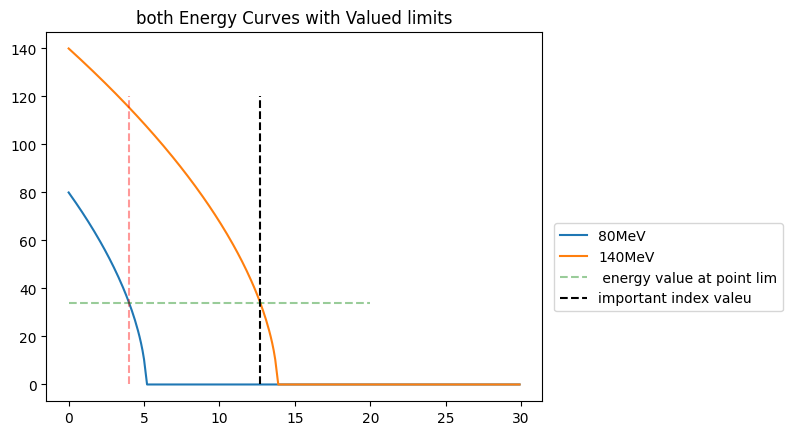

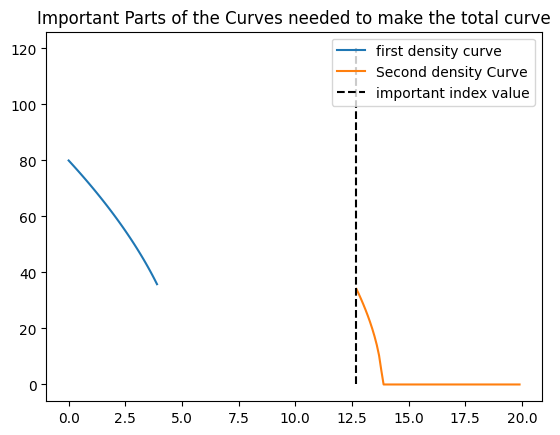

[80.00000000000001, 79.1167650006561, 78.22587145052286, 77.32709582404975, 76.42020329513323, 75.50494691404873, 74.58106670530165, 73.64828867687936, 72.70632372999859, 71.75486645681671, 70.79359381166256, 69.82216363908275, 68.84021303932383, 67.84735654868392, 66.84318410836188, 65.82725879086392, 64.79911424751931, 63.758251833984794, 62.70413736249062, 61.636197419632715, 60.55381517626565, 59.45632560087619, 58.343009968899715, 57.21308953669723, 56.065718218892606, 54.89997406952699, 53.71484931836707, 52.509238650052744, 51.2819253305108, 50.03156467504191, 48.7566642055077, 47.45555964534465, 46.126385629033486, 44.76703962477504, 43.375137036224125, 41.9479546848095, 40.482358757272245, 38.974711636757995, 37.420749491567584, 35.8154185082806, 34.13086303339288, 32.4023763944673, 30.599756751320037, 28.711350622945517, 26.72200679439689, 24.61138280354498, 22.35101477518109, 19.89881923009277, 17.187562921651377, 14.096378112195207, 10.358195763898928, 4.991660344563225, 1e

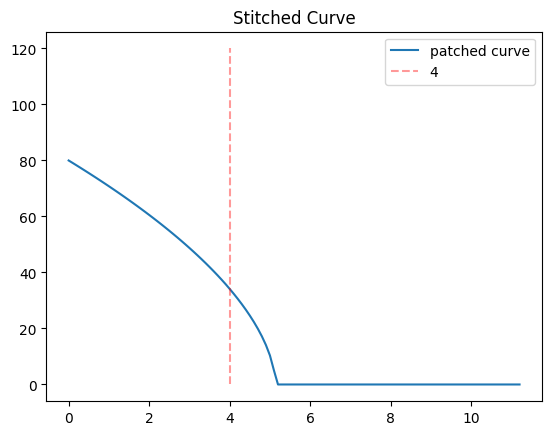

y2 [0.017584975815798595, 0.018647202017492866, 0.019597854942516164, 0.02076834452894862, 0.022222729568182834, 0.023996384516183827, 0.02602789261393482, 0.028071320577480102, 0.029647896949381792, 0.030117929146507152, 0.028907950680622713, 0.025809990645232473, 0.02116710595074246, 0.015791941984118662, 0.010640674274095284, 0.006440811664085927, 0.0034884670666831515, 0.0016856573912628363, 0.0007250875514762313, 0.0002771725516642615, 9.404333868831097e-05, 2.828369075981264e-05, 7.515522845995047e-06, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
ImportantIndexValue 12.7


C:\Users\noelh\AppData\Local\Temp\ipykernel_22868\4178746248.py:32: RuntimeWarning: invalid value encountered in scalar power
  out = math.cos(math.pi*a)* math.exp(-z_square/2)* (-z)**a * asympt + math.sqrt(2.*math.pi) / math.gamma(-a) * (-z)**(-a-1.) * asympt_2;


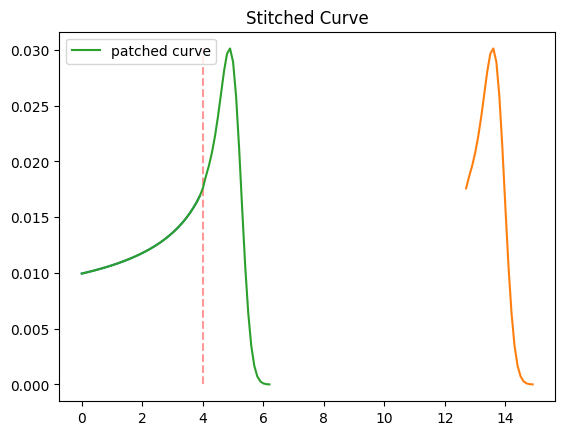

In [95]:
JoinEnergyCurves([80,140],[4,10], [1.77,1.88], [0.0022,0.0044])

Something is not quite right, going to alter the p values and alpha values 

In [96]:
def HomemadeRho2(x,eZero,rho,p,alpha):
    #print("x",x,"eZero",eZero,"rho",rho)
    
    a = []
    b = []
    y = []
    
    e_2 = rho
    
    #secondaryData - variables that have used "primary" unchaning variables (rho included in primary)
    rZero = alpha*(pow(eZero,p))*1
        
    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -x)/sigma
    phiZero = 1 + beta*(rZero)
    
    for i in range(len(eta)):
        a.append(Cyl_Gauss(-1/p,-eta[i]))
        b.append(Cyl_Gauss(((-1/p)-1),(-1*eta[i])))
        curlyD = a[i]
        curlyD2 = b[i]
        #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
        y.append((phiZero)*(sigma**(1/p))*(math.gamma(1/p))*(
        1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
        ((1/sigma)*(Cyl_Gauss(-1/p,-eta[i])))+((beta/p)+(gamma*beta)+epsilon/rZero)*
        Cyl_Gauss(((-1/p)-1),(-1*eta[i]))))
    
    for i in range(len(y)):
        if math.isnan(y[i]):
            y[i] = 0
            
    return(y)

def EnergyLeft2(x,eZero,p,alpha):
    
    rZero = alpha*(pow(eZero,p))
    if type(x) == np.ndarray or type(x) == list:
        y = []
        for i in range(len(x)):
            if rZero>= x[i]:
                e = pow(((rZero- x[i])/alpha),(1/p))
                y.append(e)
            else:
                y.append(0.0000001)
    elif type(x) == int or type(x) == float:
        y =0
        if rZero>= x:
            e = pow(((rZero- x)/alpha),(1/p))
            y=round(e,3)
        else:
            y = 0.0000001
    y = np.array(y)
    return(y)

Testing new function

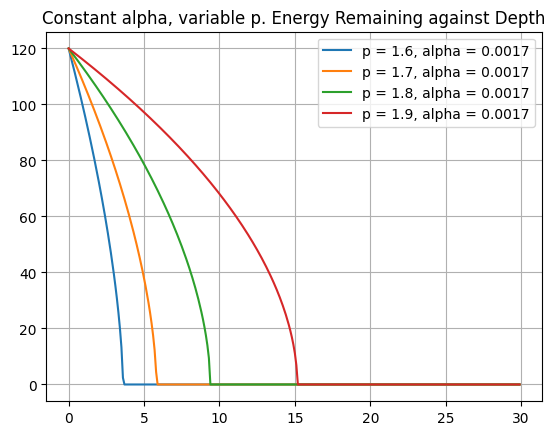

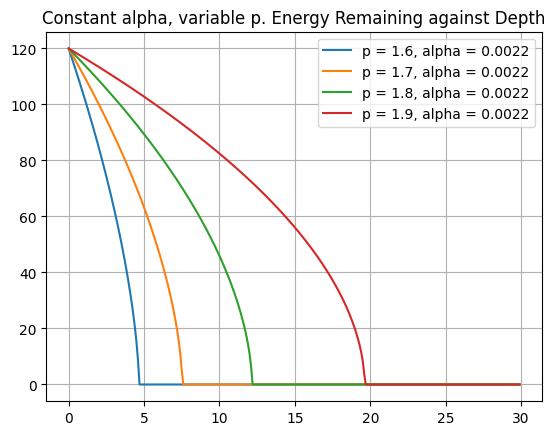

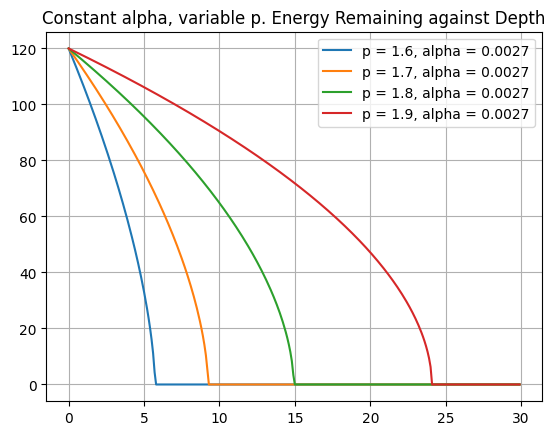

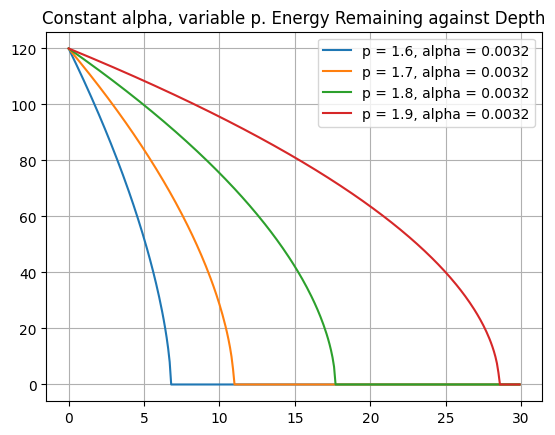

In [97]:
pList = [1.6,1.70,1.80,1.90]
alphaList = [0.0017,0.0022,0.0027,0.0032]
x0 = np.arange(0,30,0.1)

for i in alphaList:
    for j in pList:
        y0 = EnergyLeft2(x0,120,j,i)
        plt.plot(x0,y0,label = "p = "+ str(j) + ", alpha = " + str(i))
    plt.title("Constant alpha, variable p. Energy Remaining against Depth")
    plt.grid(True)
    plt.legend(loc = "best")
    plt.show()

C:\Users\noelh\AppData\Local\Temp\ipykernel_22868\4178746248.py:32: RuntimeWarning: invalid value encountered in scalar power
  out = math.cos(math.pi*a)* math.exp(-z_square/2)* (-z)**a * asympt + math.sqrt(2.*math.pi) / math.gamma(-a) * (-z)**(-a-1.) * asympt_2;


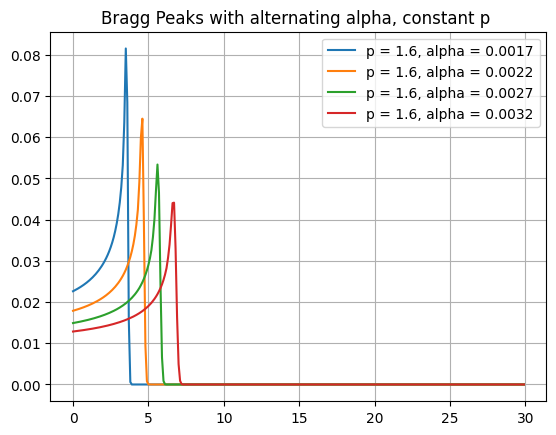

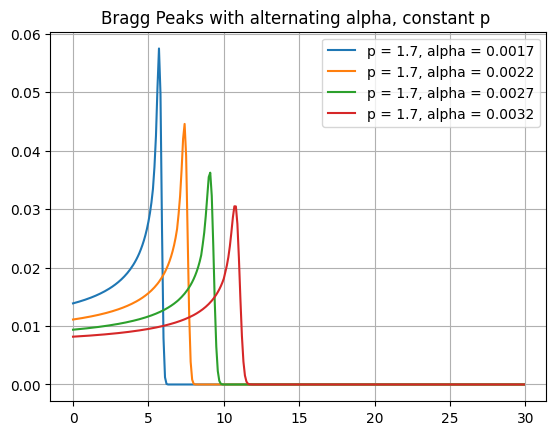

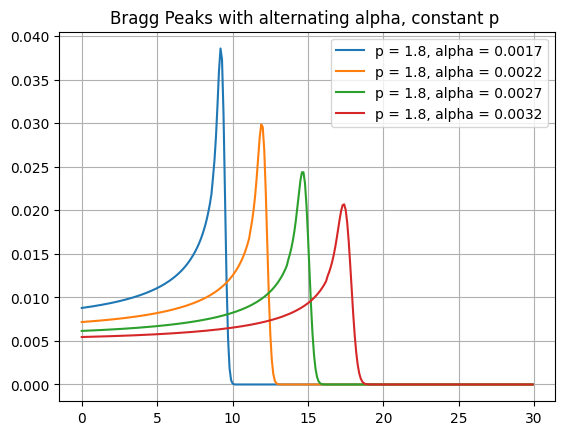

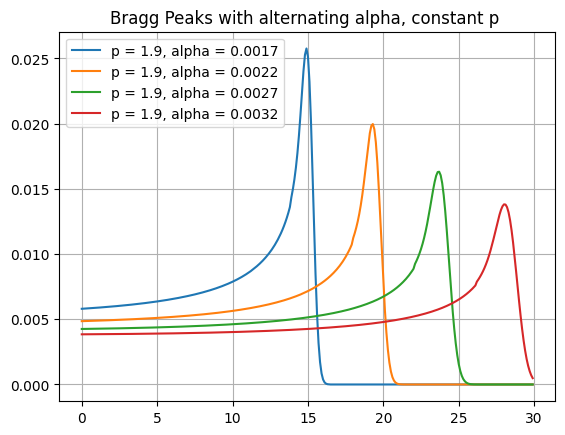

In [98]:
pList = [1.6,1.70,1.80,1.90]
alphaList = [0.0017,0.0022,0.0027,0.0032]
x0 = np.arange(0,30,0.1)

for i in pList:
    for j in alphaList:
        y0 = HomemadeRho2(x0,120,997,i,j)
        plt.plot(x0,y0,label = "p = "+ str(i) + ", alpha = " + str(j))
        plt.title("Bragg Peaks with alternating alpha, constant p ")
        plt.grid(True)
    plt.legend(loc = "best")
    plt.show()

higher density mediums should have lower alpha value and lower p value.


In [99]:
def JoinEnergyCurves2(eZeroList,phiLimList, pList, alphaList,rhoList):
    # first just plot the energy curves
    res = 0.1
    x0 = np.arange(0,30,res) #control 
    
    #Plot every curve
    y_i = []
    for i in range(len(pList)):
        y_i.append(EnergyLeft2(x0,120,pList[i],alphaList[i]))
        plt.plot(x0,y_i[i], label =str(i+1)+  ": p = "+ str(pList[i]) + ", alpha = "+ str(alphaList[i]))
    #Get every E_i
    e_i = []
    for i in range(len(pList)-1):
        e_i.append(EnergyLeft2(phiLimList[i],eZeroList[i],pList[i],alphaList[i]))
        if i %2 == 0:
            plt.hlines(e_i[i],0,20,linestyles="dashed", color = "g", alpha = 0.6, label = "Energy at PhiLim" + str(i+1))
        elif i %2 == 1:
            plt.hlines(e_i[i],0,20,linestyles=":", color = "g", alpha = 0.6, label = "Energy at PhiLim" + str(i+1))

    #plot energy value lines
    for i in range(len(phiLimList)-1):
        if i % 2 == 0:
            plt.vlines(phiLimList[i],0,max(y_i[i]),linestyles="dashed", color = "r", alpha = 0.6,label = "phiLim"+ str(i+1))
        elif i %2 == 1:
            plt.vlines(phiLimList[i],0,max(y_i[i]),linestyles=":", color = "r", alpha = 0.6,label = "phiLim"+ str(i+1))
    
    #find the energy value
    for i in range(len(e_i)):
        
        y = y_i[i+1]
        target = e_i[i]
        yTarget = abs(y - target)
        closestAns = min(yTarget)
        
        for i in range(len(y)):
            if closestAns == abs(y[i]-target):
                importantIndexValue = i/10

        plt.vlines(importantIndexValue,0,max(y),linestyles="dashed", color = "k", alpha = 1, label = "important index valeu")
    plt.legend(bbox_to_anchor = (1.5,0.5))
    plt.title("both Energy Curves with Valued limits")
    plt.show()
        
        ################################################
    #Plotting only the parts i want with gap
    
    plt.figure
    # make the trimmed x's
    x_i = []
    for i in range(len(y_i)): ###### For loop obsolete
        #x_i's 
        if i  == 0:
            x_i.append(np.arange(0,phiLimList[i]+0.1,res))
        else:
            x_i.append(np.arange(importantIndexValue+0.1,20,res))

    print(len(x_i[0]),len(x_i[1]))
    #make the trimmed y's
    yTrim_i = []
    for i in range(len(y_i)):
        yTrim_i.append(EnergyLeft2(x_i[i],eZeroList[i],pList[i],alphaList[i]))
    #Plot
    for i in range(len(y_i)):
        plt.plot(x_i[i],yTrim_i[i],label = "Denisty Curve Number "+ str(i))
        
    plt.vlines(phiLimList[0],0,max(yTrim_i[0]), color = "r", linestyles=":",label = "Change of Density")
    plt.vlines(importantIndexValue,0,max(yTrim_i[0]),linestyles="dashed", color = "k", alpha = 1,label = "important index value" )
    plt.legend(loc = "best")
    plt.title("Important Parts of the Curves needed to make the total curve")
    plt.show()
    plt.figure()
    ###############################################
    #trimming the gap
    y_I = [list(i) for i in yTrim_i]
    #print(type(yTrim_i[0]))
    y = y_I[0]
    for i in y_I[1]:
        y.append(i)
    
    x_j = np.arange(0,len(y)/10,0.1)
    print(y)
    plt.plot(x_j,y,label = "patched curve")
    plt.vlines(phiLimList[0],0,max(y),linestyles="dashed", color = "r", alpha = 0.4,label = str(phiLimList[0]) )
    plt.legend(loc = "best")
    plt.title("Stitched Curve")

    plt.show()
    
    ###############################################
    # now to get the Bragg values 
    plt.figure()
    yBragg_i = []
    for i in range(len(y_i)):
        yBragg_i.append(HomemadeRho2(x_i[i],eZeroList[i],rhoList[i],pList[i],alphaList[i]))
    for i in range(len(yBragg_i)):
        plt.plot(x_i[i],yBragg_i[i])
    plt.title("Stitched Curve with gap")
    plt.show()
    plt.figure()

    y1 = list(yBragg_i[0])
    y2 = list(yBragg_i[1])
    #print(len(y1),len(y2))
    
    for i in y2:
        y1.append(i)
    x_i = np.arange(0,len(y1)/10,0.1)
    #print((x_i))
    
    plt.vlines(phiLimList[0],0,max(y1),linestyles="dashed", color = "r", alpha = 0.4, label = "Change Of Density")    
    plt.plot(x_i,y1,label = "Patched Curve")
    plt.legend(loc = "best")
    plt.title("Stitched Curve")

    plt.show()
    
    
    return(True)

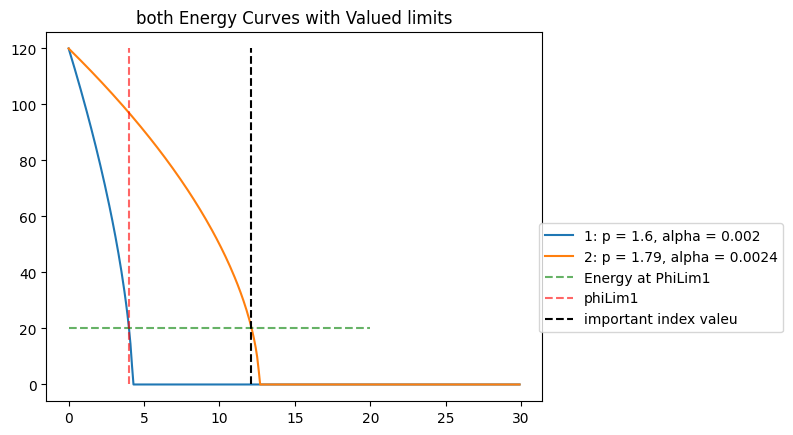

41 78


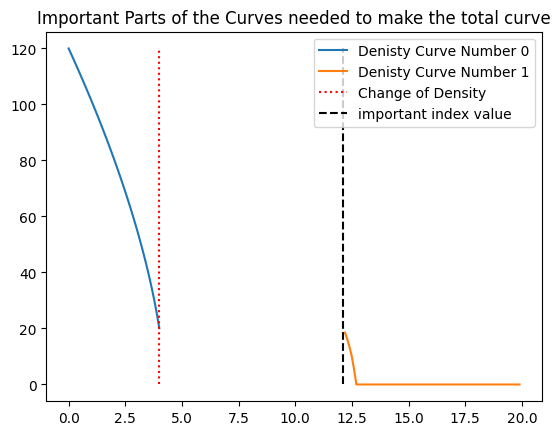

[120.00000000000003, 118.22467882219989, 116.43321546260213, 114.6250583325982, 112.79962245510029, 110.95628651713031, 109.09438957603744, 107.21322736795007, 105.31204815776579, 103.39004805867538, 101.44636573539951, 99.48007638833478, 97.49018489481344, 95.4756179575626, 93.43521507773806, 91.36771812864454, 89.27175925380813, 87.14584674586182, 84.98834847583878, 82.79747232913486, 80.57124295505054, 78.3074739378593, 76.00373422917927, 73.65730731533856, 71.2651410867013, 68.82378566380257, 66.32931541754303, 63.77722993953558, 61.16232651823188, 58.47853333175724, 55.71868735195244, 52.87423257766738, 49.934800307950596, 46.88760916646559, 43.71657925891276, 40.40097229752918, 36.91320169295861, 33.21508672365566, 29.25092117620755, 24.93319325397372, 20.108152456972388, 18.51603144568154, 16.066321659186443, 13.276811347135764, 9.916620952224019, 5.192195631875126, 1e-07, 1e-07, 1e-07, 1e-07, 1e-07, 1e-07, 1e-07, 1e-07, 1e-07, 1e-07, 1e-07, 1e-07, 1e-07, 1e-07, 1e-07, 1e-07, 1e

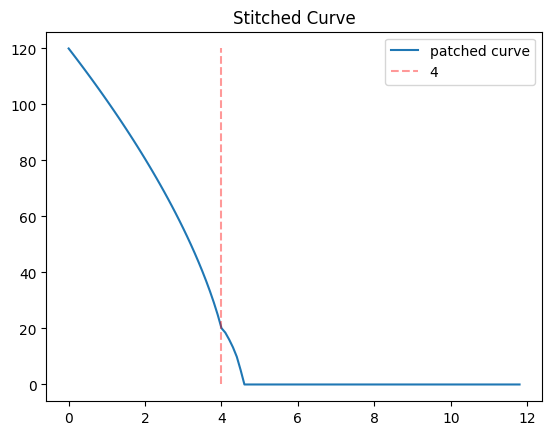

C:\Users\noelh\AppData\Local\Temp\ipykernel_22868\4178746248.py:32: RuntimeWarning: invalid value encountered in scalar power
  out = math.cos(math.pi*a)* math.exp(-z_square/2)* (-z)**a * asympt + math.sqrt(2.*math.pi) / math.gamma(-a) * (-z)**(-a-1.) * asympt_2;


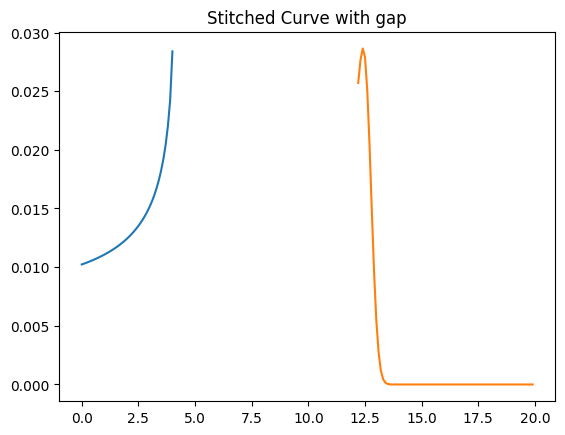

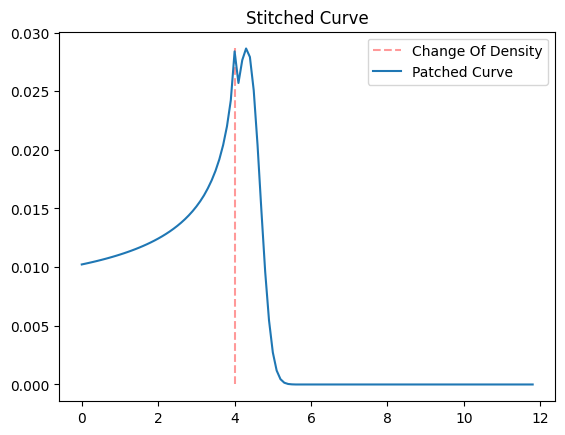

True

In [100]:
JoinEnergyCurves2([120,120],[4,5],[1.6,1.79],[0.0020,0.0024],[1900,997])

In [101]:
# def RhoRhoRhoYourBoat(eZeroList,phiLimList, pList, alphaList,rhoList):
#     # first just plot the energy curves
#     res = 0.1
#     x0 = np.arange(0,30,res) #control 
    
#     #Plot every curve
#     y_i = []
#     for i in range(len(pList)):
#         y_i.append(EnergyLeft2(x0,eZeroList[i],pList[i],alphaList[i]))
#         plt.plot(x0,y_i[i], label =str(i+1)+  ": p = "+ str(pList[i]) + ", alpha = "+ str(alphaList[i]))
#     #Get every E_i
#     e_i = []
#     for i in range(len(pList)-1):
#         e_i.append(EnergyLeft2(phiLimList[i],eZeroList[i],pList[i],alphaList[i]))
#         if i %2 == 0:
#             plt.hlines(e_i[i],0,20,linestyles="dashed", color = "g", alpha = 0.6, label = "Energy at PhiLim" + str(i+1))
#         elif i %2 == 1:
#             plt.hlines(e_i[i],0,20,linestyles=":", color = "g", alpha = 0.6, label = "Energy at PhiLim" + str(i+1))

#     #plot energy value lines
#     for i in range(len(phiLimList)-1):
#         if i % 2 == 0:
#             plt.vlines(phiLimList[i],0,max(y_i[0]),linestyles="dashed", color = "r", alpha = 0.6,label = "phiLim"+ str(i+1))
#         elif i %2 == 1:
#             plt.vlines(phiLimList[i],0,max(y_i[0]),linestyles=":", color = "r", alpha = 1,label = "phiLim"+ str(i+1))
    
#     #find the energy value
#     impIndexVal_i = []
    
#     for i in range(len(e_i)): #for every energy 
        
#         y = y_i[i+1]
#         target = e_i[i]
#         yTarget = abs(y - target)
#         closestAns = min(yTarget)
        
#         for j in range(len(y)): # for the particular energy curve 
#             #find value 
#             if closestAns == abs(y[j]-target): 
#                 importantIndexValue = j/10
#                 impIndexVal_i.append(importantIndexValue)
#                 print("ImpIndexValFound!!",impIndexVal_i,j)
#         plt.vlines(impIndexVal_i[i],0,max(y),linestyles="dashed", color = "k", alpha = 1, label = "important index value")
#     plt.legend(bbox_to_anchor = (1.5,0.5))
#     plt.title("Multiple Energy Curves with Valued limits")
#     plt.ylim([60,80])
#     plt.xlim([0,10])
#     plt.show()
        
#         ################################################
#     #Plotting only the parts i want with gap
    
#     plt.figure
#     # make the trimmed x's
#     x_i = []
#     for i in range(len(y_i)): ###### For loop obsolete
#         #x_i's 
#         if i  == 0:
#             x_i.append(np.arange(0,phiLimList[i]+0.1,res))
#         else:
#             x_i.append(np.arange(importantIndexValue+0.1,20,res))

#     #make the trimmed y's
#     yTrim_i = []
#     for i in range(len(y_i)):
#         yTrim_i.append(EnergyLeft2(x_i[i],eZeroList[i],pList[i],alphaList[i]))
#     #Plot
#     for i in range(len(y_i)):
#         plt.plot(x_i[i],yTrim_i[i],label = "Denisty Curve Number "+ str(i))
        
#     plt.vlines(phiLimList[0],0,max(yTrim_i[0]), color = "r", linestyles=":",label = "Change of Density")
#     plt.vlines(importantIndexValue,0,max(yTrim_i[0]),linestyles="dashed", color = "k", alpha = 1,label = "important index value" )
#     plt.legend(loc = "best")
#     plt.title("Important Parts of the Curves needed to make the total curve")
#     plt.xlim([0,10])
#     plt.show()
#     plt.figure()
    
#     ###############################################
#     #trimming the gap
#     y_I = [list(i) for i in yTrim_i]
#     #print(type(yTrim_i[0]))
#     y = y_I[0]
#     for i in y_I[1]:
#         y.append(i)
    
#     x_j = np.arange(0,len(y)/10,0.1)
#     #print(y)
#     plt.plot(x_j,y,label = "patched curve")
#     plt.vlines(phiLimList[0],0,max(y),linestyles="dashed", color = "r", alpha = 0.4,label = str(phiLimList[0]) )
#     plt.legend(loc = "best")
#     plt.title("Stitched Curve")

#     plt.show()
    
#     ###############################################
#     # now to get the Bragg values 
#     plt.figure()
#     yBragg_i = []
#     for i in range(len(y_i)):
#         yBragg_i.append(HomemadeRho2(x_i[i],eZeroList[i],rhoList[i],pList[i],alphaList[i]))
#     for i in range(len(yBragg_i)):
#         plt.plot(x_i[i],yBragg_i[i])
#     plt.title("Stitched Curve with gap")
#     plt.show()
#     plt.figure()
    
#     yMaster = yBragg_i[0]
#     for i in range(1,len(yBragg_i)):
#         for i in range(len(yBragg_i[i])):
#             y1.append(i)
#     #print(y1)
#     x_i = np.arange(0,len(y1)/10,0.1)
#     #print((x_i))

#     #y1 = list(yBragg_i[0])
#     #y2 = list(yBragg_i[1])
#     #print(len(y1),len(y2))
    
#     for i in y2:
#         y1.append(i)
#     x_i = np.arange(0,len(y1)/10,0.1)
#     #print((x_i))
    
#     plt.vlines(phiLimList[0],0,max(y1),linestyles="dashed", color = "r", alpha = 0.4, label = "Change Of Density")    
#     plt.plot(x_i,y1,label = "Patched Curve")
#     plt.legend(loc = "best")
#     plt.title("Stitched Curve")

#     plt.show()
    
    
#     return(True)

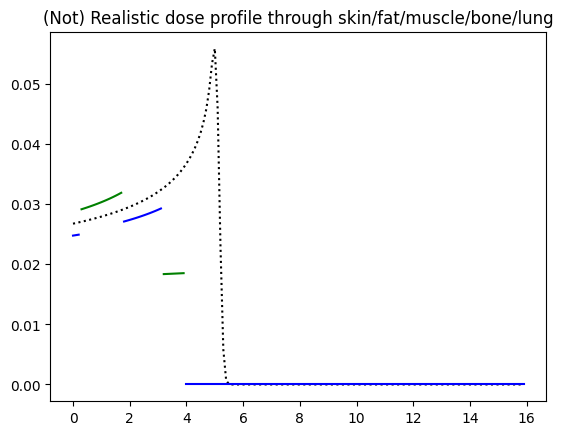

In [102]:
eZeroList = [];phiLimList =[]; pList =[];alphaList =[];rhoList = []

for i in range(5):
    eZeroList.append(80)
    
alphaList = list(np.arange(0.0020,0.006,0.0008))
pList = list(np.arange(1.74,1.89,0.03))
rhoList = [1116,900,1084,1900,394]
phiLimList = [0.3,1.8,3.2,4,16]

#all the arguments are now correct 
RhoRhoRhoYourBoat() #eZeroList,phiLimList,pList,alphaList,rhoList
#print(len(phiLimList))
#print(alphaList)
#print(pList)

# Issue
Dead space must be removed before calculating next important limit

In [103]:
def RhoRhoRhoYourBoat4(eZeroList,phiLimList, pList, alphaList,rhoList):
    
    res = 0.1
    endVal = 20
    x0 = np.arange(0,endVal,res) #control 
    yTrim_i = []
    xTrim_i = []
    
    
    ################################################
    # first just plot the energy curves
    y_i = [] # list of all the full y's (Remaining Energy)
    for i in range(len(pList)):
        y_i.append(EnergyLeft2(x0,eZeroList[i],pList[i],alphaList[i]))
        plt.plot(x0,y_i[i], label =str(i+1)+  ": p = "+ str(pList[i]) + ", alpha = "+ str(alphaList[i]))
    plt.legend(bbox_to_anchor=(1.4,1))
    plt.title("All Represented Densitiy Energy Val Curves")
    plt.show()
    ################################################
    #Now Plot two curves at a time 
    # for each pair evaluate the Important index, plot the relavant v/hlines and show
    e_i = []
    impIndexVal_i =[]
    for i in range(len(y_i)-1): # for all the curves
        
        #plot the two Energy Curves
        
        plt.figure()
        plt.plot(x0,y_i[i], label = "i'th Curve")
        plt.plot(x0,y_i[i+1], label = "i+1'th  Curve")

        #density Lim Line
        
        plt.vlines(phiLimList[i],0,max(y_i[i]),linestyles="--",color = "r", label = str(phiLimList[i]))
        if i > 1:
            plt.vlines(phiLimList[i-1],0,max(y_i[i]),linestyles="--",color = "pink", label = str(phiLimList[i-1]))
        plt.vlines(phiLimList[i+1],0,max(y_i[i]),linestyles="--",color = "pink", label = str(phiLimList[i+1]))

        #Energy Line at point PhiLimList[i]
        
        e_i.append(EnergyLeft2(phiLimList[i],eZeroList[i],pList[i],alphaList[i]))
        print("e_i",e_i)
        plt.hlines(e_i[i],0,max(x0),linestyles="--",color = "g", label = "e_i["+ str(i)+ "]")
        
        #ImportantIndexValue Line
        
        target = e_i[i]
        y_subject = y_i[i+1] 
        yTargetArray = abs(y_subject-target)
        closestAnsValue = min(yTargetArray)
        #print("ClosestAnsValue",closestAnsValue)
        #print(abs(y_subject-target))
        if closestAnsValue != 0:
            for j in range(len(y_subject)): # for the particular y 
                if abs(y_subject[j] - target) == min(abs(y_subject - target)): # if min and hence e

                    impIndexVal_i.append(j/10)
         #           print("ImpIndexValFound!!",impIndexVal_i,j)
        else:
            impIndexVal_i.append(phiLimList[i])
          #  print("ImpIndexValFound!!",impIndexVal_i,j)
        plt.vlines(impIndexVal_i[i],0,max(y_i[i]),linestyles="--",color = "k", label = "impIndexTrim_i["+ str(i)+ "]")
        #Details
        plt.legend(bbox_to_anchor =(1.5,1))
        plt.title(str(i+1)+"'st/nd/rd/th pair of curves")
        plt.show()
        
        ##############################################
        #Now removing the deadspace 
        #Must Calculate the Split x's and y's before plots 
    #return(phiLimList,impIndexVal_i)
    
    
    
        # make the trimmed x's
    for i in range(len(phiLimList)+1):
        #print("len(impIndexVal_i)",len(impIndexVal_i))
        #print("impIndexVal_i[i]",impIndexVal_i[i])
        #print("i",i)
        #print("impIndexVal_i[i]",impIndexVal_i[i])
        #print("phiLimList[i]",phiLimList[i-1])
        if i  == 0:
            xTrim_i.append(np.arange(0,phiLimList[i]+res,res))
        elif i >= 1 and i < len(impIndexVal_i):
            
            xTrim_i.append(np.arange(impIndexVal_i[i-1],phiLimList[i],res))

            print("cond")
            print(xTrim_i[i])
            print("lower",impIndexVal_i[i-1])
            print("upper",phiLimList[i-1])

#             if impIndexVal_i[i-1] < phiLimList[i-1]:
#                 xTrim_i.append(np.arange(impIndexVal_i[i-1],phiLimList[i-1],res))
#                 print("cond")
#                 print(xTrim_i[i])
#                 print("lower",impIndexVal_i[i-1])
#                 print("upper",phiLimList[i-1])
                
#             else:
#                 xTrim_i.append(np.arange(phiLimList[i-1],impIndexVal_i[i-1],res)) 
#                 # need to make sure the yTrim is lowered in this case

#                 print(" inv cond")
#                 print(xTrim_i[i])
#                 print("lower",phiLimList[i-1])
#                 print("upper",impIndexVal_i[i-1])


        elif i == len(impIndexVal_i):
            xTrim_i.append(np.arange(impIndexVal_i[i-1],endVal,res))
            #print("i == len(impVal_i)-1")
            
        #make the trimmed y's#####################################################
    #print("e_i",e_i)
    #print(phiLimList[i-1])
    print("xTRim",xTrim_i)
    plt.figure()
    for i in range(len(xTrim_i)):
        yTrim_i.append(EnergyLeft2(xTrim_i[i],eZeroList[i],pList[i],alphaList[i]))
        
#         if i > 0 and xTrim_i[i][0] > phiLimList[i-1]:
#             e = np.array(EnergyLeft2(xTrim_i[i],eZeroList[i],pList[i],alphaList[i]))-e_i[i-1]
#             yTrim_i.append(e)
#         else:
#             yTrim_i.append(EnergyLeft2(xTrim_i[i],eZeroList[i],pList[i],alphaList[i]))
        plt.plot(xTrim_i[i],yTrim_i[i])
        
    
    for i in range(len(phiLimList)):
        plt.vlines(phiLimList[i],0,max(yTrim_i[0]),linestyle = "dashed", color = "r", alpha = 0.4)
    for i in range(len(impIndexVal_i)):
        plt.vlines(impIndexVal_i[i],0,max(yTrim_i[0]),linestyle = "dashed", color = "k", alpha = 0.4)
    for i in range(len(e_i)):
        plt.hlines(e_i[i],0,max(xTrim_i[len(xTrim_i)-1]),linestyle = "dashed", color = "g", alpha = 0.4)
    plt.title("Test")
    plt.xticks(np.arange(0,max(xTrim_i[len(xTrim_i)-1])))
    plt.xlim([0,9])
    plt.show()
    
##############################################################################
        #Plot
    print(len(yTrim_i))
    for i in range(len(yTrim_i)-1):
        print(i)
        print(yTrim_i[i])
        plt.figure()
        plt.plot(xTrim_i[i],yTrim_i[i],label = "Denisty Curve Number "+ str(i+1))
        plt.plot(xTrim_i[i+1],yTrim_i[i+1],label = "Denisty Curve Number "+ str(i+2))
#         plt.legend(bbox_to_anchor=(1.4,1))
#         plt.show()
        
        #density Lim Line
        
        plt.vlines(phiLimList[i],min(yTrim_i[i+1]),max(yTrim_i[i]),linestyles="--",color = "r", label = str(phiLimList[i]))
        
        #Energy Line at point PhiLimList[i]
        
        plt.hlines(e_i[i],0,min(xTrim_i[i+1]),linestyles="--",color = "g", label = "e_i["+ str(i)+ "]")
        
        #ImportantIndexValue Line
        
        plt.vlines(impIndexVal_i[i],min(yTrim_i[i+1]),max(yTrim_i[i]),linestyles="--",color = "k", label = "impIndexTrim_i["+ str(i)+ "]")
        
        #Details
        plt.legend(bbox_to_anchor =(1.5,1))
        plt.title(str(i+1)+"'st/nd/rd/th pair of curves")
        plt.show()
        ###############################################
        #Test
    yTrimList_i = [list(k) for k in yTrim_i]
    #print("yTrimList_i", type(yTrimList_i), yTrimList_i, end = ":::::::::::::::::::::::::::")
    yAns = []
    print(yTrim_i)
    for lst in yTrimList_i:
        for val in lst:
            yAns.append(val)
    print("yAns",yAns)
    
    #trimming the gap
    
    #plt.plot(yAns)
    #return(True)
    #flat_list = [item for sublist in yTrimList_i for item in sublist]
    #print("flat_list",type(flat_list),flat_list)
    
    
    xStitched = np.linspace(0,len(yAns)/10,len(yAns))
    print("xStitched",len(xStitched),xStitched)
    plt.plot(xStitched,yAns)
    for i in range(len(phiLimList)):
        plt.vlines(phiLimList[i],0,max(yAns),linestyles = "--", color = "r", label = str(phiLimList[i]))
    plt.xticks(ticks = np.arange(0,max(xStitched)))
    plt.legend(bbox_to_anchor=(1.4,1))
    plt.figure()
    plt.plot(xStitched,yAns)
    plt.xticks(ticks = np.arange(0,max(xStitched)))
    plt.legend(bbox_to_anchor=(1.4,1))
    
    print(xTrim_i)
 #   return(True)
        
        
        
#         for j in range(len(y_I)):
#             for k in y_I[j]:
#                 y.append(k)

#         x_j = np.arange(0,len(y)/10,0.1)
#         print(y)
#         plt.plot(x_j,y,label = "patched curve")
#         plt.vlines(phiLimList[0],0,max(y),linestyles="dashed", color = "r", alpha = 0.4,label = str(phiLimList[0]) )
#         plt.legend(loc = "best")
#         plt.title("Stitched Curve")

#         plt.show()

#         ###############################################
#         return(True)
    
#     #Get every E_i
#     e_i = []
#     for i in range(len(pList)-1):
#         e_i.append(EnergyLeft2(phiLimList[i],eZeroList[i],pList[i],alphaList[i]))
#         if i %2 == 0:
#             plt.hlines(e_i[i],0,20,linestyles="dashed", color = "g", alpha = 0.6, label = "Energy at PhiLim" + str(i+1))
#         elif i %2 == 1:
#             plt.hlines(e_i[i],0,20,linestyles=":", color = "g", alpha = 0.6, label = "Energy at PhiLim" + str(i+1))

#     #plot energy value lines
#     for i in range(len(phiLimList)-1):
#         if i % 2 == 0:
#             plt.vlines(phiLimList[i],0,max(y_i[0]),linestyles="dashed", color = "r", alpha = 0.6,label = "phiLim"+ str(i+1))
#         elif i %2 == 1:
#             plt.vlines(phiLimList[i],0,max(y_i[0]),linestyles=":", color = "r", alpha = 1,label = "phiLim"+ str(i+1))
    
#     #find the energy value
#     impIndexVal_i = []
    
#     for i in range(len(e_i)):
        
#         y = y_i[i+1]
#         target = e_i[i]
#         yTarget = abs(y - target)
#         closestAns = min(yTarget)
        
#         for j in range(len(y)):
#             if closestAns == abs(y[j]-target):
#                 importantIndexValue = j/10
#                 impIndexVal_i.append(importantIndexValue)
#         print(impIndexVal_i,i)
#         plt.vlines(impIndexVal_i[i],0,max(y),linestyles="dashed", color = "k", alpha = 1, label = "important index valeu")
#     plt.legend(bbox_to_anchor = (1.5,0.5))
#     plt.title("Multiple Energy Curves with Valued limits")
#     plt.ylim([60,80])
#     plt.xlim([0,10])
#     plt.show()
        
#         ################################################
#     #Plotting only the parts i want with gap
    
#     plt.figure
#     # make the trimmed x's
#     xTrim_i = []
#     for i in range(len(y_i)): 
#         #xTrim_i's 
#         if i  == 0:
#             xTrim_i.append(np.arange(0,phiLimList[i]+0.1,res))
#         else:
#             xTrim_i.append(np.arange(importantIndexValue+0.1,20,res))

#     #make the trimmed y's
#     yTrim_i = []
#     for i in range(len(y_i)):
#         yTrim_i.append(EnergyLeft2(xTrim_i[i],eZeroList[i],pList[i],alphaList[i]))
#     #Plot
#     for i in range(len(yTrim_i)):
#         plt.plot(xTrim_i[i],yTrim_i[i],label = "Denisty Curve Number "+ str(i+1))
        
#     plt.vlines(phiLimList[0],0,max(yTrim_i[0]), color = "r", linestyles=":",label = "Change of Density")
#     plt.vlines(importantIndexValue,0,max(yTrim_i[0]),linestyles="dashed", color = "k", alpha = 1,label = "important index value" )
#     plt.legend(loc = "best")
#     plt.title("Important Parts of the Curves needed to make the total curve")
#     plt.xlim([0,10])
#     plt.show()
#     plt.figure()
    
#     ###############################################
#     #trimming the gap
#     y_I = [list(i) for i in yTrim_i]
#     #print(type(yTrim_i[0]))
#     y = y_I[0]
#     for i in y_I[1]:
#         y.append(i)
    
#     x_j = np.arange(0,len(y)/10,0.1)
#     #print(y)
#     plt.plot(x_j,y,label = "patched curve")
#     plt.vlines(phiLimList[0],0,max(y),linestyles="dashed", color = "r", alpha = 0.4,label = str(phiLimList[0]) )
#     plt.legend(loc = "best")
#     plt.title("Stitched Curve")

#     plt.show()
    
#     ###############################################
#     # now to get the Bragg values 
#     plt.figure()
#     yBragg_i = []
#     for i in range(len(y_i)):
#         yBragg_i.append(HomemadeRho2(xTrim_i[i],eZeroList[i],rhoList[i],pList[i],alphaList[i]))
#     for i in range(len(yBragg_i)):
#         plt.plot(xTrim_i[i],yBragg_i[i])
#     plt.title("Stitched Curve with gap")
#     plt.show()
#     plt.figure()
    
#     yMaster = yBragg_i[0]
#     for i in range(1,len(yBragg_i)):
#         for i in range(len(yBragg_i[i])):
#             y1.append(i)
#     #print(y1)
#     xTrim_i = np.arange(0,len(y1)/10,0.1)
#     #print((xTrim_i))

#     #y1 = list(yBragg_i[0])
#     #y2 = list(yBragg_i[1])
#     #print(len(y1),len(y2))
    
#     for i in y2:
#         y1.append(i)
#     xTrim_i = np.arange(0,len(y1)/10,0.1)
#     #print((xTrim_i))
    
#     plt.vlines(phiLimList[0],0,max(y1),linestyles="dashed", color = "r", alpha = 0.4, label = "Change Of Density")    
#     plt.plot(xTrim_i,y1,label = "Patched Curve")
#     plt.legend(loc = "best")
#     plt.title("Stitched Curve")

#     plt.show()
    
    
#     return(True)

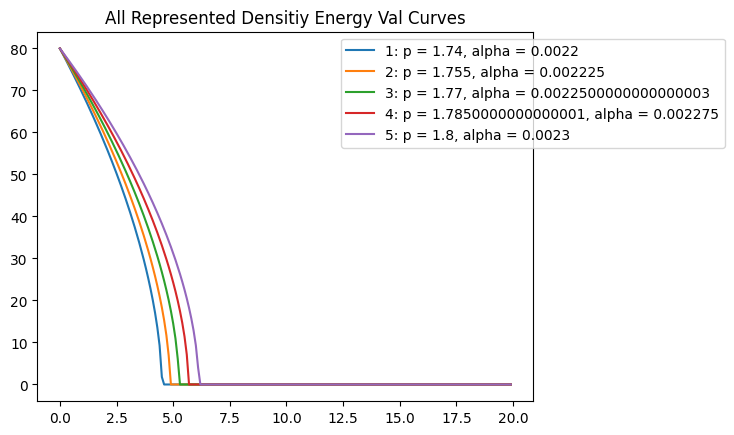

e_i [array(76.894)]


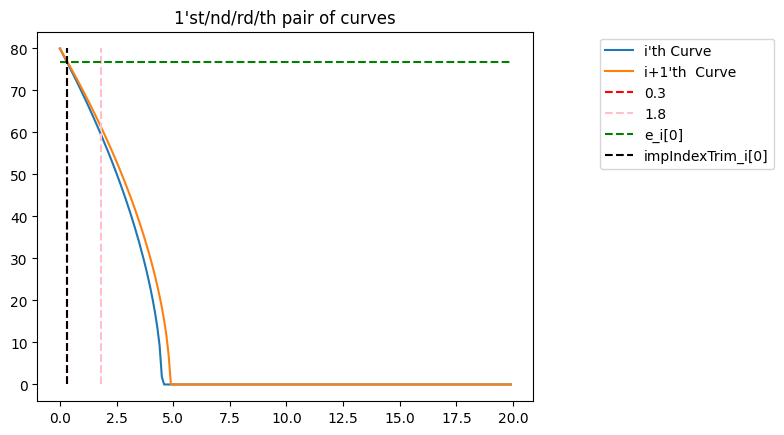

e_i [array(76.894), array(61.491)]


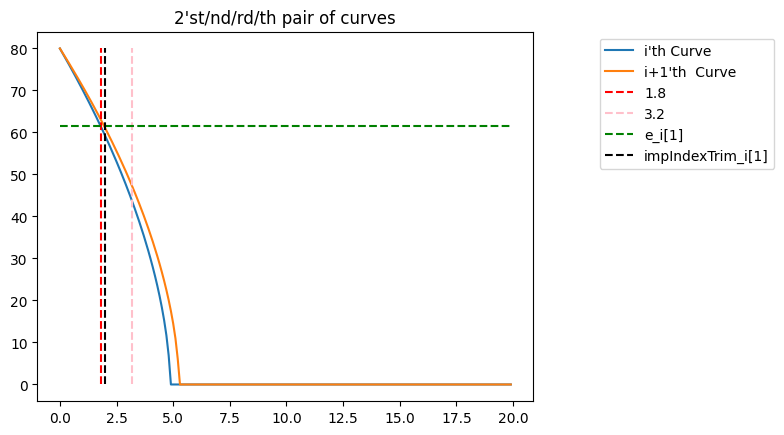

e_i [array(76.894), array(61.491), array(47.075)]


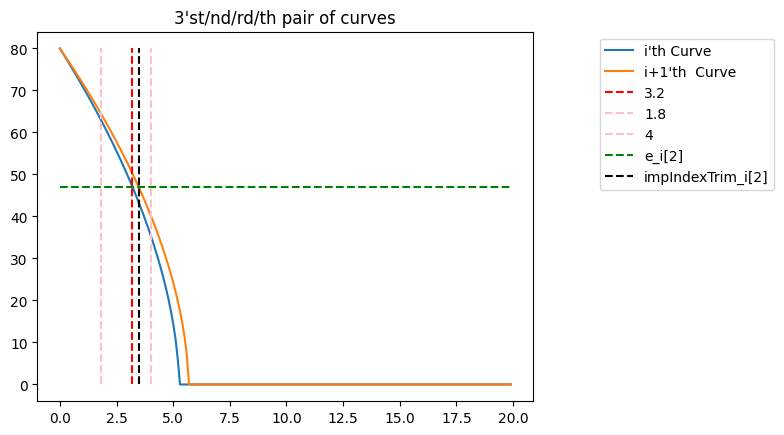

e_i [array(76.894), array(61.491), array(47.075), array(40.387)]


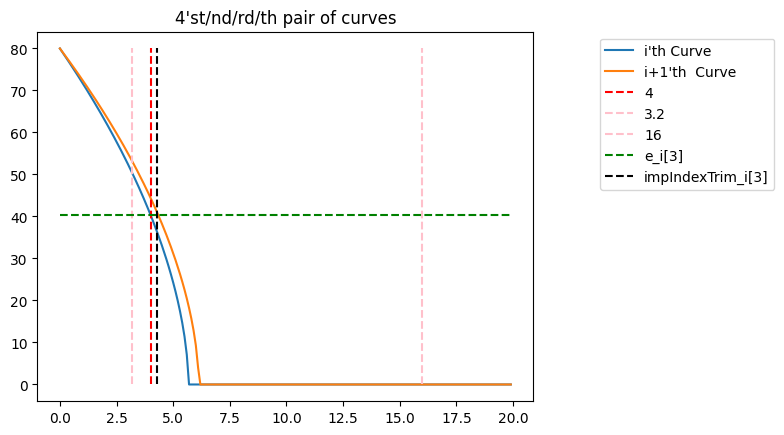

cond
[0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7]
lower 0.3
upper 0.3
cond
[2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2]
lower 2.0
upper 1.8
cond
[3.5 3.6 3.7 3.8 3.9]
lower 3.5
upper 3.2
xTRim [array([0. , 0.1, 0.2, 0.3]), array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5,
       1.6, 1.7]), array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2]), array([3.5, 3.6, 3.7, 3.8, 3.9]), array([ 4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,
        5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,
        6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,
        7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,
        8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,
        9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8,
       10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9,
       12. , 12.1, 12.2, 12.3, 12.4, 12.5

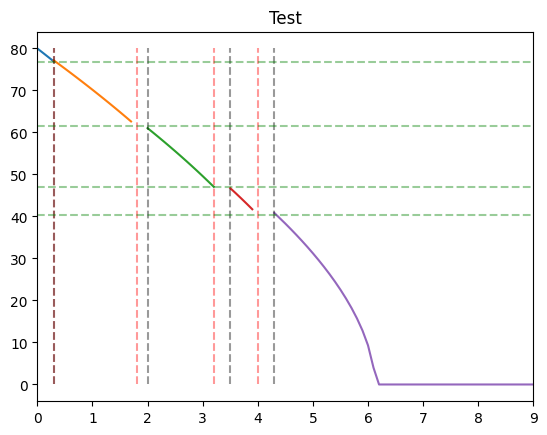

5
0
[80.         78.97480162 77.93965879 76.89424067]


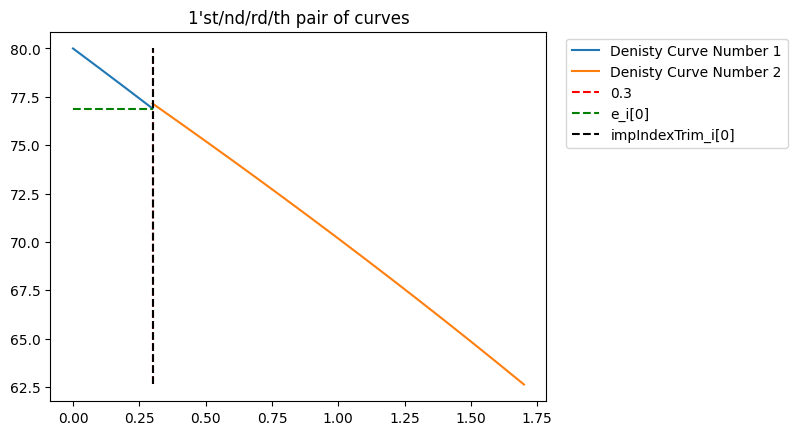

1
[77.15176965 76.18458596 75.20804154 74.22182827 73.22562035 72.2190729
 71.20182031 70.17347444 69.13362262 68.08182538 67.01761396 65.94048746
 64.84990962 63.74530522 62.62605595]


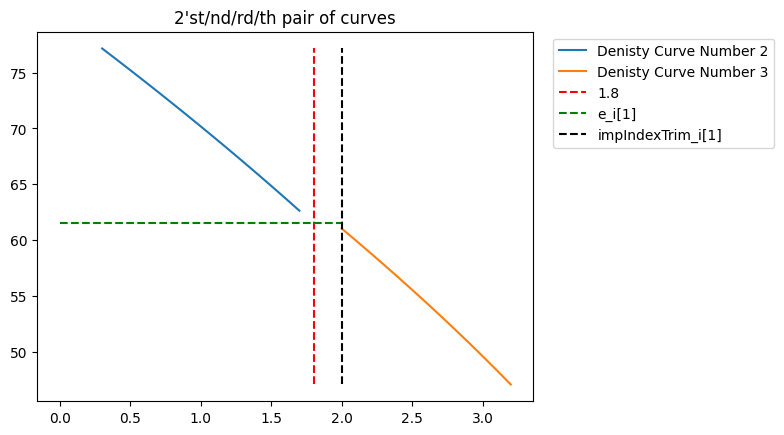

2
[61.03669835 59.97041182 58.88932241 57.79272979 56.67987547 55.54993576
 54.40201357 53.23512884 52.04820727 50.84006703 49.60940289 48.35476725
 47.07454718]


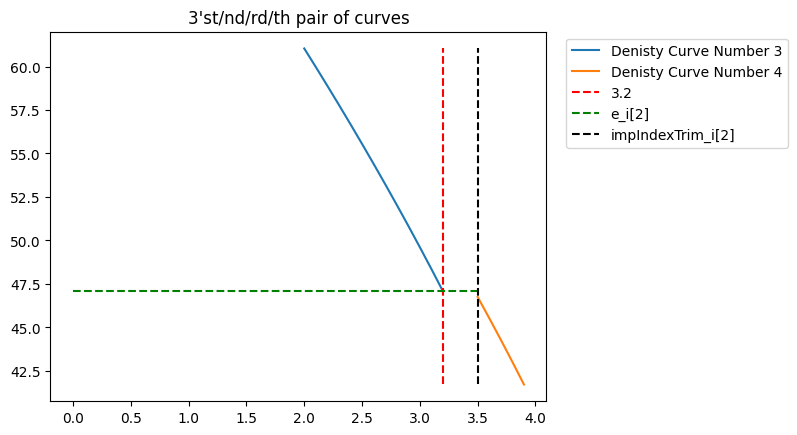

3
[46.74993849 45.53356018 44.29111952 43.02069402 41.72010784]


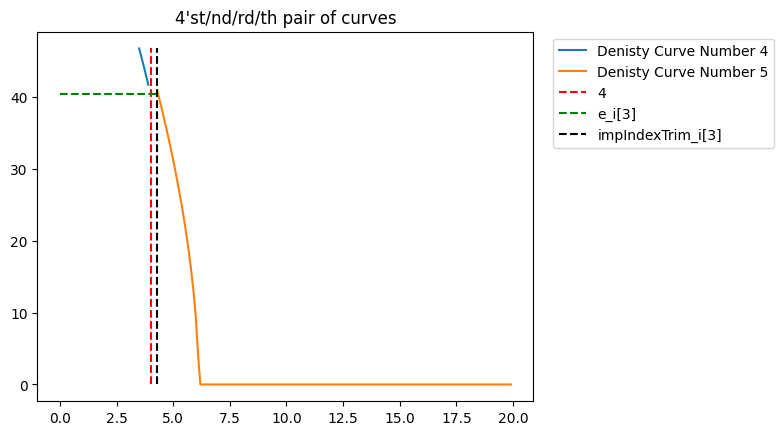

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[array([80.        , 78.97480162, 77.93965879, 76.89424067]), array([77.15176965, 76.18458596, 75.20804154, 74.22182827, 73.22562035,
       72.2190729 , 71.20182031, 70.17347444, 69.13362262, 68.08182538,
       67.01761396, 65.94048746, 64.84990962, 63.74530522, 62.62605595]), array([61.03669835, 59.97041182, 58.88932241, 57.79272979, 56.67987547,
       55.54993576, 54.40201357, 53.23512884, 52.04820727, 50.84006703,
       49.60940289, 48.35476725, 47.07454718]), array([46.74993849, 45.53356018, 44.29111952, 43.02069402, 41.72010784]), array([4.08502931e+01, 3.95930056e+01, 3.83029306e+01, 3.69771143e+01,
       3.56121227e+01, 3.42039233e+01, 3.27477263e+01, 3.12377683e+01,
       2.96670067e+01, 2.80266798e+01, 2.63056491e+01, 2.44893744e+01,
       2.25582373e+01, 2.04846148e+01, 1.82273261e+01, 1.57198060e+01,
       1.28401866e+01, 9.30981950e+00, 3.97623232e+00, 1.00000000e-07,
       1.00000000e-07, 1.00000000e-07, 1.00000000e-07, 1.00000000e-07,
       1.00000000e-07, 1.000

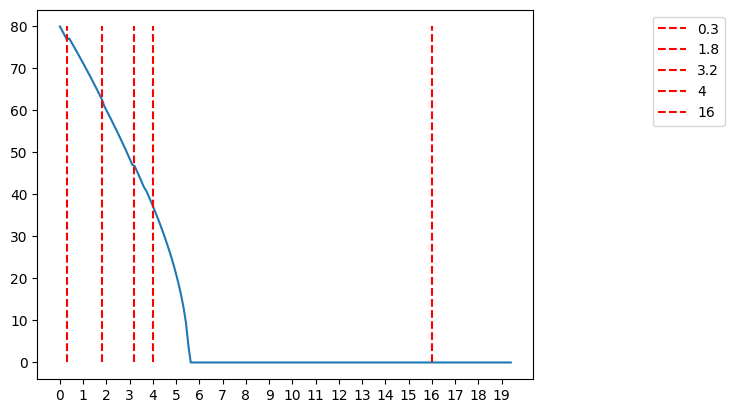

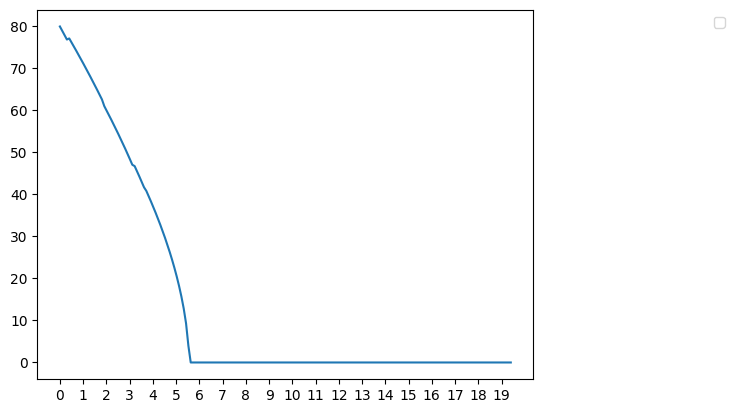

In [104]:
eZeroList = [];phiLimList =[]; pList =[];alphaList =[];rhoList = []

for i in range(5):
    eZeroList.append(80)
    
alphaList = list(np.linspace(0.0022,0.0023,5))
pList = list(np.linspace(1.74,1.8,5))
rhoList = [1116,900,1084,1900,394]
phiLimList = [0.3,1.8,3.2,4,16]


#all the arguments are now correct 
RhoRhoRhoYourBoat4(eZeroList,phiLimList,pList,alphaList,rhoList)
#print(len(phiLimList))
#print(alphaList)
#print(pList)

In [105]:
# eZeroList = [];phiLimList =[]; pList =[];alphaList =[];rhoList = []

# for i in range(5):
#     eZeroList.append(80)
    
# alphaList = list(np.linspace(0.0022,0.008,5))
# pList = list(np.linspace(1.74,1.741,5))
# rhoList = [1116,900,1084,1900,394]
# phiLimList = [0.3,1.8,3.2,4,16]


# #all the arguments are now correct 
# RhoRhoRhoYourBoat4(eZeroList,phiLimList,pList,alphaList,rhoList)
# #print(len(phiLimList))
# #print(alphaList)
# #print(pList)

In [106]:
def EvaluateDeadSpace(curve_index,phiLimValue,impIndexValue):
        print(curve_index,phiLimValue,impIndexValue)
        diff = abs(impIndexValue-phiLimValue)
        

In [107]:
def RhoRhoRhoYourBoat5(eZeroList,phiLimList,pList,alphaList,rhoList):
    res = 0.1
    endVal = 50
    x0 = np.arange(0,endVal,res) #control 
    yTrim_i = []
    xTrim_i = []
    
    
    ################################################
    # first just plot the energy curves
    y_i = [] # list of all the full y's (Remaining Energy)
    for i in range(len(pList)):
        y_i.append(EnergyLeft2(x0,eZeroList[i],pList[i],alphaList[i]))
        plt.plot(x0,y_i[i], label =str(i+1)+  ": p = "+ str(pList[i]) + ", alpha = "+ str(alphaList[i]))
    plt.legend(bbox_to_anchor=(1.4,1))
    plt.xlim([0,30])
    plt.title("All Represented Densitiy Energy Val Curves")
    plt.show()
   

    ################################################
    #Now Plot two curves at a time 
    # for each pair evaluate the Important index, plot the relavant v/hlines and show
    e_i = []
    impIndexVal_i =[]
    cumulativeTrim = 0
    for i in range(len(y_i)-1): # for all the curves
        
        #plot the two Energy Curves
        
        plt.figure()
        plt.plot(x0,y_i[i], label = "i'th Curve")
        plt.plot(x0,y_i[i+1], label = "i+1'th  Curve")

        #density Lim Line
        
        plt.vlines(phiLimList[i],0,max(y_i[i]),linestyles="--",color = "r", label = str(phiLimList[i]))
        if i > 1:
            plt.vlines(phiLimList[i-1],0,max(y_i[i]),linestyles="--",color = "pink", label = str(phiLimList[i-1]))
        plt.vlines(phiLimList[i+1],0,max(y_i[i]),linestyles="--",color = "pink", label = str(phiLimList[i+1]))

        #Energy Line at point PhiLimList[i]
        
        e_i.append(EnergyLeft2(phiLimList[i],eZeroList[i],pList[i],alphaList[i]))
        print("e_i",e_i)
        plt.hlines(e_i[i],0,max(x0),linestyles="--",color = "g", label = "e_i["+ str(i)+ "]")
        
        #ImportantIndexValue Line
        
        target = e_i[i]
        y_subject = y_i[i+1] 
        yTargetArray = abs(y_subject-target)
        closestAnsValue = min(yTargetArray)
        #print("ClosestAnsValue",closestAnsValue)
        #print(abs(y_subject-target))
        if closestAnsValue != 0:
            for j in range(len(y_subject)): # for the particular y 
                if abs(y_subject[j] - target) == min(abs(y_subject - target)): # if min and hence e

                    impIndexVal_i.append(j/10)
         #           print("ImpIndexValFound!!",impIndexVal_i,j)
        else:
            impIndexVal_i.append(phiLimList[i])
          #  print("ImpIndexValFound!!",impIndexVal_i,j)
        plt.vlines(impIndexVal_i[i],0,max(y_i[i]),linestyles="--",color = "k", label = "impIndexTrim_i["+ str(i)+ "]")
        #Details
        plt.legend(bbox_to_anchor =(1.5,1))
        plt.title(str(i+1)+"'st/nd/rd/th pair of curves")
        plt.xlim([0,30])
        plt.show()
        
        ##############################################################################################
        
        #Now removing the deadspace 
        #Must Calculate the Split x's and y's before plots 
        if i == 0: # first bit 
            print("phiLimList[i]",phiLimList[i])
            print("impIndexVal_i[i]",impIndexVal_i[i])
            xAns1 = np.arange(0,phiLimList[i]-res,res)
            yAns1 = list(EnergyLeft2(xAns1,eZeroList[i],pList[i],alphaList[i]))
            xAns2 = np.arange(impIndexVal_i[i],endVal,res)
            yAns2 = list(EnergyLeft2(xAns2,eZeroList[i],pList[i+1],alphaList[i+1]))
            print("yAns1[len(yAns1)-1]","yAns2[0]")
            print(yAns1[len(yAns1)-1],yAns2[0])
            y_master = yAns1
            cumulativeTrim = abs(phiLimList[i] - impIndexVal_i[i])
            for j in yAns2:
                y_master.append(j)
                
            plt.plot(y_master)
            #plt.xlim([0,6])
            plt.xlim([0,300])
            plt.xlabel("displacement in mm")
            plt.ylabel("Energy Remaining")
            plt.title("Energy Remaining against displacment - Initial  Curve")
            plt.show()
            
            
        
            
        else: # little bits 
            
            
            #new plot
            plt.figure()
            #previous calculated curve form 0 to philim_i - cumulativeTrim 
            yAns1 = y_master[0:int(math.floor((phiLimList[i]- cumulativeTrim)*10))-1] # Definitely Correct
            
            #display value of the calculated intercept x value and cumulateiveTrim
            print("impIndexVal_i[i]",impIndexVal_i[i])
            print("cumulativeTrim",cumulativeTrim)
            
            #Correct the Caluclated intercept x value
                        
            diff = abs(phiLimList[i] - impIndexVal_i[i]) # dont think i want abs here in general case, but leave for now 
            #impIndexVal_i = np.array(impIndexVal_i) - diff # this is the correction 
            
            cumulativeTrim = cumulativeTrim + diff
            #impIndexVal_i = list(impIndexVal_i)
            
            #display Corrected intercept x value
            #print("impIndexVal_i[i] after Trim",impIndexVal_i[i])
            
            #Calculate the range of x values from the calculated Value start point to the end 
            xAns2 = np.arange(impIndexVal_i[i],endVal,res)
            #xAns2 = np.arange(phiLimList[i],endVal,res)

            yAns2 = list(EnergyLeft2(xAns2,eZeroList[i],pList[i+1],alphaList[i+1]))
            y_master = yAns1
            print("yAns1[len(yAns1)-1]","yAns2[0]")
            print(yAns1[len(yAns1)-1],yAns2[0])
            for j in yAns2:
                y_master.append(j)
                #print(y_master)
            plt.plot(y_master)
            plt.xlim([0,300])
            plt.xlabel("displacement in mm")
            plt.ylabel("Energy Remaining")
            plt.title("Energy Remaining against displacment - "+str(i+1) +" Stitched Curves")
            plt.grid(True)
            plt.show()
    return(True)
               
    

# Current 010822

In [108]:
# eZeroList = [];phiLimList =[]; pList =[];alphaList =[];rhoList = []

# for i in range(5):
#     eZeroList.append(80)
    
# alphaList = list(np.linspace(0.0022,0.008,5))
# pList = list(np.linspace(1.74,1.741,5))
# rhoList = [1116,900,1084,1900,394]
# phiLimList = [0.3,1.8,3.2,4,16]


# #all the arguments are now correct 
# RhoRhoRhoYourBoat5(eZeroList,phiLimList,pList,alphaList,rhoList)
# #print(len(phiLimList))
# #print(alphaList)
# #print(pList)

In [109]:
# eZeroList = [];phiLimList =[]; pList =[];alphaList =[];rhoList = []

# for i in range(5):
#     eZeroList.append(80)
    
# alphaList = list(np.linspace(0.0022,0.008,5))
# pList = list(np.linspace(1.74,1.741,5))
# rhoList = [1116,900,1084,1900,394]
# phiLimList = [0.3,1.8,3.2,4,16]


# #all the arguments are now correct 
# RhoRhoRhoYourBoat5(eZeroList,phiLimList,pList,alphaList,rhoList)
# #print(len(phiLimList))
# #print(alphaList)
# #print(pList)

# 6

In [110]:
def RhoRhoRhoYourBoat6(eZeroList,phiLimList,pList,alphaList,rhoList):
    res = 0.1
    endVal = 50
    x0 = np.arange(0,endVal,res) #control 
    yTrim_i = []
    xTrim_i = []
    
    
    ################################################
    # first just plot the energy curves
    y_i = [] # list of all the full y's (Remaining Energy)
    
    for i in range(len(pList)): # for all curves yet to be made 
        y_i.append(EnergyLeft2(x0,eZeroList[i],pList[i],alphaList[i]))
        plt.plot(x0,y_i[i], label =str(i+1)+  ": p = "+ str(pList[i]) + ", alpha = "+ str(alphaList[i]))
    plt.legend(bbox_to_anchor=(1.4,1))
    plt.xlim([0,30])
    plt.title("All Represented Densitiy Energy Val Curves")
    plt.show()
   

    ################################################
    #Now Plot two curves at a time 
    # for each pair evaluate the Important index, plot the relavant v/hlines and show
    e_i = []
    impIndex =[]
    cumulativeTrim = 0
    yBraggMaster = []
    cumulativeTrimList = []
    phiLimListAmmended = phiLimList
    
    for i in range(len(phiLimList)): # for all the density limits
        
        print(phiLimList[i])
        print(phiLimListAmmended[i])
        #if i != len(phiLimList)-1:
        print(impIndex)
        print(" ================================================================== ")
        print(i,len(y_i))
        print(" ================================================================== ")
        
        
        #plot the two Energy Curves
        plt.figure()
        plt.plot(x0,y_i[i], label = "i'th Curve")
        plt.plot(x0,y_i[i+1], label = "i+1'th  Curve")

        #density Lim Line
        plt.vlines(phiLimList[i],0,max(y_i[i]),linestyles="--",color = "r", label = str(phiLimList[i]))
        
        if i > 0: # if there is a phi earlier on
            plt.vlines(phiLimList[i-1],0,max(y_i[i]),linestyles="--",color = "pink", label = str(phiLimList[i-1]))
        
        if i != len(phiLimList)-1:  # if there is a phi further on 
            plt.vlines(phiLimList[i+1],0,max(y_i[i]),linestyles="--",color = "pink", label = str(phiLimList[i+1]))

        #Energy Line at point PhiLimList[i]
        
        e_i.append(EnergyLeft2(phiLimList[i],eZeroList[i],pList[i],alphaList[i]))
        print("e_i",e_i)
        plt.hlines(e_i[i],0,max(x0),linestyles="--",color = "g", label = "e_i["+ str(i)+ "]")
        
        #ImportantIndexValue Line
        
        target = e_i[i]
        
        if i == len(phiLimList)-1:
            print("last curve segment...")

        #find the "answer"
        y_subject = y_i[i+1] 
        yTargetArray = abs(y_subject-target)
        closestAnsValue = min(yTargetArray)

        #find the index of the "answer"
        if closestAnsValue != 0:
            for j in range(len(y_subject)): # for the particular y 
                if abs(y_subject[j] - target) == min(abs(y_subject - target)): # if min and hence e
                    impIndex.append(j/10) # store index

        #
            plt.vlines(impIndex[i],0,max(y_i[i]),linestyles="--",color = "k", label = "impIndex["+ str(i)+ "]")
        #Details
        plt.legend(bbox_to_anchor =(1.5,1))
        plt.title("n curves, n = "+ str(i+1))
        plt.xlim([0,30])
        plt.show()
        #print(len(impIndex)) # impIndex Length always 1 less than phiLimList length 
        ##############################################################################################
        #display 
        print(phiLimList[i])
        print(phiLimListAmmended[i])
        #if i != len(phiLimList)-1:
        print(impIndex)
        print(" ================================================================== ")
        print(i,len(y_i))
        print(" ================================================================== ")
        
        ##############################################################################################
        #Now removing the deadspace 
        #Must Calculate the Split x's and y's before plots 
        if i == 0: # first bit 
            print("phiLimList[i]",phiLimList[i])
            print("impIndex[i]",impIndex[i])
            
            
            #calc deadSpace
            if phiLimList[i] < impIndex[i]:
                deadSpace = impIndex[i] - phiLimList[i]
            else:
                deadSpace = phiLimList[i] - impIndex[i]
            
            #append deadSpace
            cumulativeTrimList.append(deadSpace)  
            
            #quickly ammend next phi value 
            phiLimListAmmended[i+1] = phiLimListAmmended[i+1] + cumulativeTrimList[i]
            
            
            #calculating the segments of the curve 
            xAns1 = np.arange(0,phiLimList[i]-res,res) # 0 to phi i 
            yAns1 = list(EnergyLeft2(xAns1,eZeroList[i],pList[i],alphaList[i])) 
            
            xAns2 = np.arange(impIndex[i]+ deadSpace,endVal,res)
            yAns2 = list(EnergyLeft2(xAns2,eZeroList[i],pList[i+1],alphaList[i+1]))
            
            #display some data 
            print("yAns1[len(yAns1)-1]","yAns2[0]")
            print(yAns1[len(yAns1)-1],yAns2[0])
            
            #appending the second part of the curve to the first 
            y_master = yAns1
            cumulativeTrim = abs(phiLimList[i] - impIndex[i])
            cumulativeTrimList.append(cumulativeTrim)
            for j in yAns2:
                y_master.append(j)
                
            #plotting
            plt.plot(y_master)
            #plt.xlim([0,6])
            plt.xlim([0,300])
            plt.xlabel("displacement in mm")
            plt.ylabel("Energy Remaining")
            plt.title("Energy Remaining against displacment - Initial  Curve")
            plt.show()
            
            
            #############################################################
            # bragg part
            plt.figure()
            
            #xBragg1 = np.arange(0,phiLimList[i]-res,res)
            yBragg1 = HomemadeRho2(xAns1,eZeroList[i],rhoList[i],pList[i],alphaList[i])
            #xBragg2 = np.arange(impIndex[i],endVal*10,res)
            yBragg2 = HomemadeRho2(xAns2,eZeroList[i],rhoList[i],pList[i],alphaList[i])
            
            yBraggMaster = yBragg1
            
            for j in yBragg2:
                yBraggMaster.append(j)
            
            plt.plot(yBraggMaster)
            plt.xlim([0,300])
            plt.xlabel("displacement in mm")
            plt.ylabel("Dose Per Fluence")
            plt.title("Dose Per Fluence against displacment - Initial Curve")
            plt.grid(True)
            
            
        else: # all parts of the curve apart from the initial 
            
            plt.figure()
            #previous calculated curve form 0 to philim_i - cumulativeTrim 
            #yAns1 = y_master[0:int(math.floor((phiLimList[i]- cumulativeTrim)*10))-1] # Definitely Correct
            yAns1 = y_master[0:int(phiLimList[i]*10)]
            #display value of the calculated intercept x value and cumulateiveTrim
            if i != len(phiLimList)-1: # if not last 
                print("if not last - - - - - -")
                
                #calc deadSpace
                if phiLimList[i] < impIndex[i]:
                    deadSpace = impIndex[i] - phiLimList[i]
                else:
                    deadSpace = phiLimList[i] - impIndex[i]
                    

                #append deadSpace
                cumulativeTrimList.append(deadSpace)  
            
                #quickly ammend next phi value 
                phiLimListAmmended[i+1] = phiLimListAmmended[i+1] + cumulativeTrimList[i]
                
            #Correct the Caluclated intercept x value
                        
            #impIndex = np.array(impIndex) - diff # this is the correction 
            
            

            #impIndex = list(impIndex)
            
            #display Corrected intercept x value
            #print("impIndex[i] after Trim",impIndex[i])
            
            #Calculate the range of x values from the calculated Value start point to the end 
                xAns2 = np.arange(impIndex[i]+deadSpace,endVal,res)
            #xAns2 = np.arange(phiLimList[i],endVal,res)

            yAns2 = list(EnergyLeft2(xAns2,eZeroList[i],pList[i],alphaList[i]))
            y_master = yAns1
            print("yAns1[len(yAns1)-1]","yAns2[0]")
            print(yAns1[len(yAns1)-1],yAns2[0])
            for j in yAns2:
                y_master.append(j)
                #print(y_master)
            plt.plot(y_master)
            plt.xlim([0,300])
            plt.xlabel("displacement in mm")
            plt.ylabel("Energy Remaining")
            plt.title("Energy Remaining against displacment - "+str(i+1) +" Stitched Curves")
            plt.grid(True)
            for j in range(i+1):
                plt.vlines((phiLimList[j]- cumulativeTrimList[j])*10,0,max(y_master),linestyle = "dashed", color = "r", alpha = 0.4)
            
            plt.show()
            #############################################################
            plt.figure()
            yBragg1 = yBraggMaster[0:int(math.floor((phiLimList[i]- cumulativeTrim)*10))-1] # Definitely Correct
            xBragg2 = np.arange(impIndex[i],endVal*10,res)
            yBragg2 = HomemadeRho2(xBragg2,eZeroList[i],rhoList[i],pList[i],alphaList[i])
            yBraggMaster = yBragg1
            for j in yBragg2:
                yBraggMaster.append(j)
            plt.plot(yBraggMaster)
            plt.xlim([0,300])
            plt.xlabel("displacement in mm")
            plt.ylabel("Dose Per Fluence")
            plt.title("Dose Per Fluence against displacment - "+str(i+1) +" Stitched Curves")
            plt.grid(True)
            for j in range(i+1):
                plt.vlines((phiLimList[j])*10-1,0,max(yBraggMaster),linestyle = "dashed", color = "r", alpha = 0.4)
                print("phiLimList[j]",phiLimList[j])
                print("cumulativeTrimList[j]",cumulativeTrimList[j])
            plt.show()
            
            
            
            
            
            
    return(cumulativeTrimList)
               
    

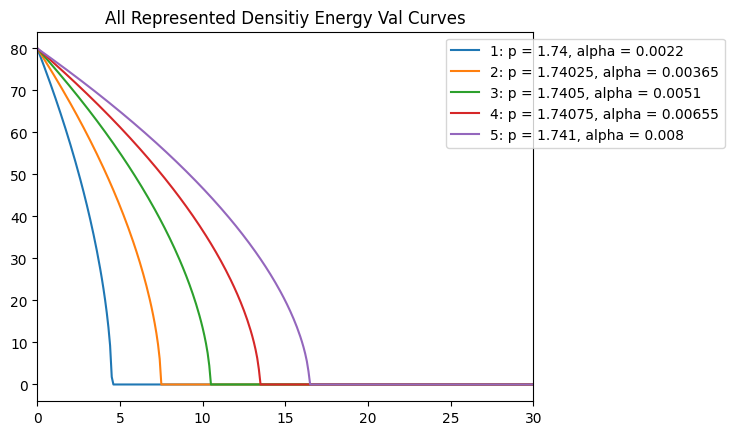

0.3
0.3
[]
0 5
e_i [array(76.894)]


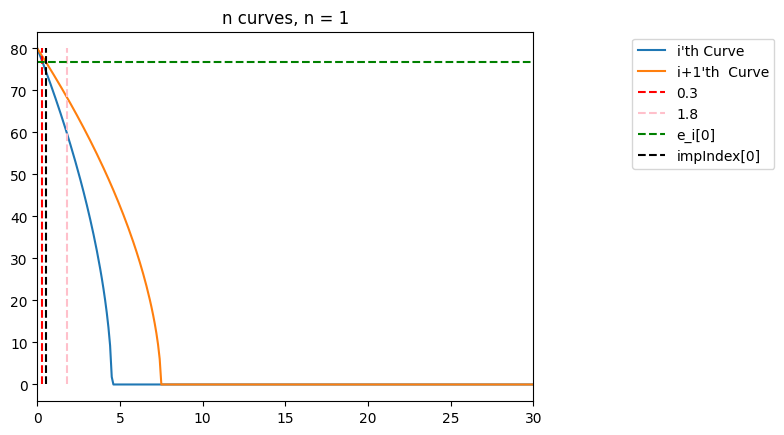

0.3
0.3
[0.5]
0 5
phiLimList[i] 0.3
impIndex[i] 0.5
yAns1[len(yAns1)-1] yAns2[0]
78.97480162063331 75.61080746378954


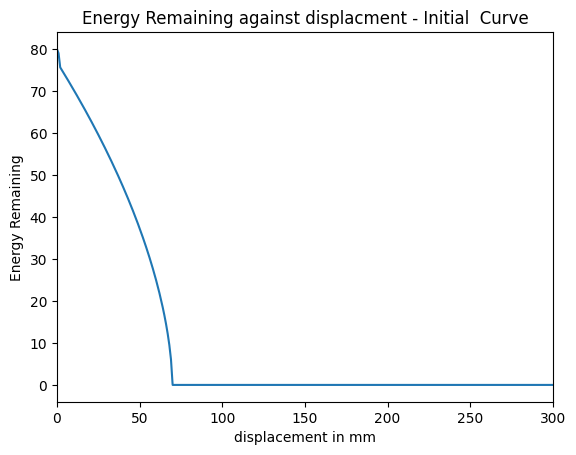

2.0

C:\Users\noelh\AppData\Local\Temp\ipykernel_22868\4178746248.py:32: RuntimeWarning: invalid value encountered in scalar power
  out = math.cos(math.pi*a)* math.exp(-z_square/2)* (-z)**a * asympt + math.sqrt(2.*math.pi) / math.gamma(-a) * (-z)**(-a-1.) * asympt_2;



2.0
[0.5]
1 5
e_i [array(76.894), array(66.911)]


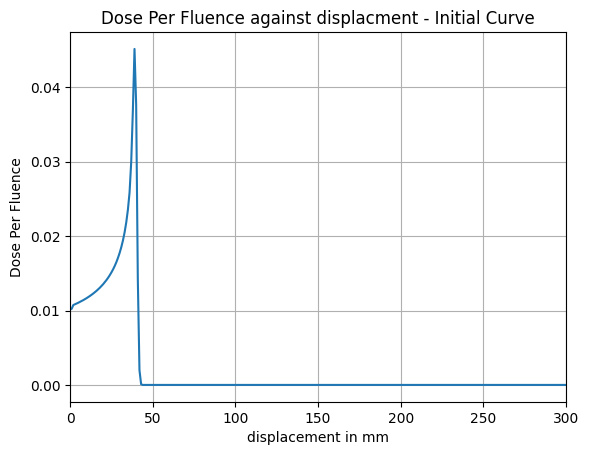

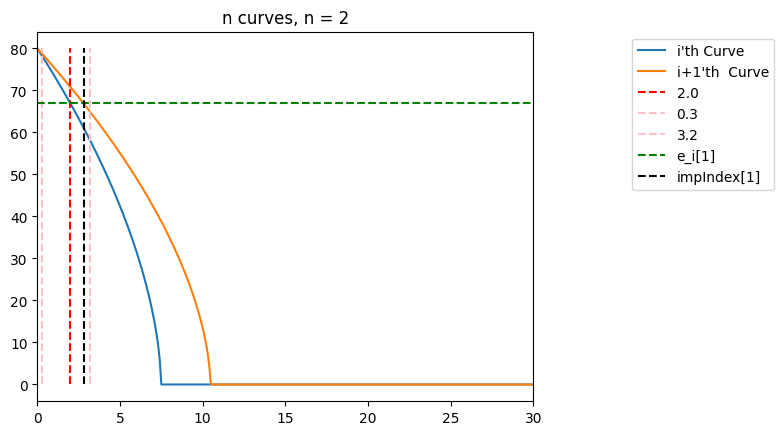

2.0
2.0
[0.5, 2.8]
1 5
if not last - - - - - -
yAns1[len(yAns1)-1] yAns2[0]
64.06140692066909 54.879491641801486


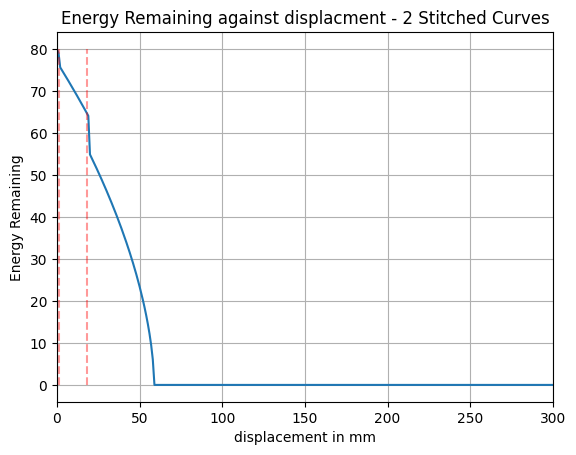

In [ ]:
eZeroList = [];phiLimList =[]; pList =[];alphaList =[];rhoList = []

for i in range(5):
    eZeroList.append(80)
    
alphaList = list(np.linspace(0.0022,0.008,5))
pList = list(np.linspace(1.74,1.741,5))
rhoList = [1116,900,1084,1900,394]
phiLimList = [0.3,1.8,3.2,4]


#all the arguments are now correct 
RhoRhoRhoYourBoat6(eZeroList,phiLimList,pList,alphaList,rhoList)
#print(len(phiLimList))
#print(alphaList)
#print(pList)

In [ ]:
def PlotEnergyCurves(eZeroList,pList,alphaList,x0): #rhoList,phiLimList
    y_i = [] # list of all the full y's (Remaining Energy)
    
    for i in range(len(pList)): # for all curves yet to be made 
        y_i.append(EnergyLeft2(x0,eZeroList[i],pList[i],alphaList[i]))
        plt.plot(x0,y_i[i], label =str(i+1)+  ": p = "+ str(pList[i]) + ", alpha = "+ str(alphaList[i]))
    plt.legend(bbox_to_anchor=(1.4,1))
    plt.xlim([0,30])
    plt.title("All Represented Densitiy Energy Val Curves")
    plt.show()
    return(y_i)
    
def FindValueReturnIndex(closestAnsValue,y_subject,target,impIndex):
    if closestAnsValue != 0:
            for j in range(len(y_subject)): # for the particular y 
                if abs(y_subject[j] - target) == min(abs(y_subject - target)): # if min and hence e
                    impIndex.append(j/10) # store index
    else:
        for j in range(len(y_subject)): # for the particular y 
                if abs(y_subject[j] - target) == min(abs(y_subject - target)): # if min and hence e
                    impIndex.append(j+10/10) # store index
    return(impIndex)

In [ ]:
# FindValueReturnIndex(0,)

In [ ]:
def RhoRhoRhoYourBoat7(eZeroList,phiLimList,pList,alphaList,rhoList):
    res = 0.1
    endVal = 50
    x0 = np.arange(0,endVal,res) #control 
    yTrim_i = []
    xTrim_i = []
    
    ################################################
    # first just plot the energy curves
    y_i = PlotEnergyCurves(eZeroList,pList,alphaList,x0)
    
    ################################################
    #Now Plot two curves at a time 
    # for each pair evaluate the Important index, plot the relavant v/hlines and show
    e_i = []
    impIndex =[]
    cumulativeTrim = 0
    yBraggMaster = []
    cumulativeTrimList = []
    phiLimListAmmended = phiLimList
    
    for i in range(len(phiLimList)): # for all the density limits
            
        #plot the two Energy Curves
        plt.figure()
        plt.plot(x0,y_i[i], label = "i'th Curve")
        plt.plot(x0,y_i[i+1], label = "i+1'th  Curve")

        #density Lim Line
        plt.vlines(phiLimList[i],0,max(y_i[i]),linestyles="--",color = "r", label = str(phiLimList[i]))
        
        if i > 0: # if there is a phi earlier on
            plt.vlines(phiLimList[i-1],0,max(y_i[i]),linestyles="--",color = "pink", label = str(phiLimList[i-1]))
        
        if i != len(phiLimList)-1:  # if there is a phi further on 
            plt.vlines(phiLimList[i+1],0,max(y_i[i]),linestyles="--",color = "pink", label = str(phiLimList[i+1]))

        
        #Energy Line at point PhiLimList[i]
        
        e_i.append(EnergyLeft2(phiLimList[i],eZeroList[i],pList[i],alphaList[i]))
        plt.hlines(e_i[i],0,max(x0),linestyles="--",color = "g", label = "e_i["+ str(i)+ "]")
        
        
        #ImportantIndexValue Line
        
        target = e_i[i]
        
        if i == len(phiLimList)-1: # if last curve 
            print("last curve segment...")
        if i != len(phiLimList)-1:
            print("len(phiLimList)-1")
            print(len(phiLimList)-1)
            print(len(impIndex)-1)
            #find the "answer"
            y_subject = y_i[i+1] 
            yTargetArray = abs(y_subject-target)
            closestAnsValue = min(yTargetArray)

            #find the index of the "answer"

            impIndex = FindValueReturnIndex(closestAnsValue,y_subject,target,impIndex)
            print(impIndex)
            plt.vlines(impIndex[i],0,max(y_i[i]),linestyles="--",color = "k", label = "impIndex["+ str(i)+ "]")

            #Details
            plt.legend(bbox_to_anchor =(1.5,1))
            plt.title("n curves, n = "+ str(i+1))
            plt.xlim([0,30])
            plt.show()
        ##############################################################################################
            #display 
            print(phiLimList[i])
            print(phiLimListAmmended[i])
            #if i != len(phiLimList)-1:
            print(impIndex)
            print(" ================================================================== ")
            print(i,len(y_i))
            print(" ================================================================== ")

            ##############################################################################################
            #Now removing the deadspace 
            #Must Calculate the Split x's and y's before plots 
            if i == 0: # first bit 
                print("phiLimList[i]",phiLimList[i])
                print("impIndex[i]",impIndex[i])


                #calc deadSpace
                if phiLimList[i] < impIndex[i]:
                    deadSpace = impIndex[i] - phiLimList[i]
                else:
                    deadSpace = phiLimList[i] - impIndex[i]

                #append deadSpace
                cumulativeTrimList.append(deadSpace)  

                #quickly ammend next phi value 
                phiLimListAmmended[i+1] = phiLimListAmmended[i+1] + cumulativeTrimList[i]


                #calculating the segments of the curve 
                xAns1 = np.arange(0,phiLimList[i]-res,res) # 0 to phi i 
                yAns1 = list(EnergyLeft2(xAns1,eZeroList[i],pList[i],alphaList[i])) 

                xAns2 = np.arange(impIndex[i]+ deadSpace,endVal,res)
                yAns2 = list(EnergyLeft2(xAns2,eZeroList[i],pList[i+1],alphaList[i+1]))

                #display some data 
                print("yAns1[len(yAns1)-1]","yAns2[0]")
                print(yAns1[len(yAns1)-1],yAns2[0])

                #appending the second part of the curve to the first 
                y_master = yAns1
                cumulativeTrim = abs(phiLimList[i] - impIndex[i])
                cumulativeTrimList.append(cumulativeTrim)
                for j in yAns2:
                    y_master.append(j)

                #plotting
                plt.plot(y_master)
                #plt.xlim([0,6])
                plt.xlim([0,300])
                plt.xlabel("displacement in mm")
                plt.ylabel("Energy Remaining")
                plt.title("Energy Remaining against displacment - Initial  Curve")
                plt.show()


                #############################################################
                # bragg part
                plt.figure()

                #xBragg1 = np.arange(0,phiLimList[i]-res,res)
                yBragg1 = HomemadeRho2(xAns1,eZeroList[i],rhoList[i],pList[i],alphaList[i])
                #xBragg2 = np.arange(impIndex[i],endVal*10,res)
                yBragg2 = HomemadeRho2(xAns2,eZeroList[i],rhoList[i],pList[i],alphaList[i])

                yBraggMaster = yBragg1

                for j in yBragg2:
                    yBraggMaster.append(j)

                plt.plot(yBraggMaster)
                plt.xlim([0,300])
                plt.xlabel("displacement in mm")
                plt.ylabel("Dose Per Fluence")
                plt.title("Dose Per Fluence against displacment - Initial Curve")
                plt.grid(True)


            else: # all parts of the curve apart from the initial 

                plt.figure()
                #previous calculated curve form 0 to philim_i - cumulativeTrim 
                #yAns1 = y_master[0:int(math.floor((phiLimList[i]- cumulativeTrim)*10))-1] # Definitely Correct
                yAns1 = y_master[0:int(phiLimList[i]*10)]
                #display value of the calculated intercept x value and cumulateiveTrim
                if i != len(phiLimList)-1: # if not last 
                    print("if not last - - - - - -")

                    #calc deadSpace
                    if phiLimList[i] < impIndex[i]:
                        deadSpace = impIndex[i] - phiLimList[i]
                    else:
                        deadSpace = phiLimList[i] - impIndex[i]


                    #append deadSpace
                    cumulativeTrimList.append(deadSpace)  

                    #quickly ammend next phi value 
                    phiLimListAmmended[i+1] = phiLimListAmmended[i+1] + cumulativeTrimList[i]

                #Correct the Caluclated intercept x value

                #impIndex = np.array(impIndex) - diff # this is the correction 



                #impIndex = list(impIndex)

                #display Corrected intercept x value
                #print("impIndex[i] after Trim",impIndex[i])

                #Calculate the range of x values from the calculated Value start point to the end 
                    xAns2 = np.arange(impIndex[i]+cumulativeTrimList[i],endVal,res)
                #xAns2 = np.arange(phiLimList[i],endVal,res)

                yAns2 = list(EnergyLeft2(xAns2,eZeroList[i],pList[i],alphaList[i]))
                y_master = yAns1
                print("yAns1[len(yAns1)-1]","yAns2[0]")
                print(yAns1[len(yAns1)-1],yAns2[0])
                for j in yAns2:
                    y_master.append(j)
                    #print(y_master)
                plt.plot(y_master)
                plt.xlim([0,300])
                plt.xlabel("displacement in mm")
                plt.ylabel("Energy Remaining")
                plt.title("Energy Remaining against displacment - "+str(i+2) +" Stitched Curves")
                plt.grid(True)
                for j in range(i+1):
                    plt.vlines((phiLimList[j]- cumulativeTrimList[j])*10,0,max(y_master),linestyle = "dashed", color = "r", alpha = 0.4)

                plt.show()
                #############################################################
                plt.figure()
                yBragg1 = yBraggMaster[0:int(math.floor((phiLimList[i]- cumulativeTrim)*10))-1] # Definitely Correct
                xBragg2 = np.arange(impIndex[i],endVal*10,res)
                yBragg2 = HomemadeRho2(xBragg2,eZeroList[i],rhoList[i],pList[i],alphaList[i])
                yBraggMaster = yBragg1
                for j in yBragg2:
                    yBraggMaster.append(j)
                plt.plot(yBraggMaster)
                plt.xlim([0,300])
                plt.xlabel("displacement in mm")
                plt.ylabel("Dose Per Fluence")
                plt.title("Dose Per Fluence against displacment - "+str(i+2) +" Stitched Curves")
                plt.grid(True)
                for j in range(i+2):
                    plt.vlines((phiLimList[j])*10-1,0,max(yBraggMaster),linestyle = "dashed", color = "r", alpha = 0.4)
                    print("phiLimList[j]",phiLimList[j])
                    print("cumulativeTrimList[j]",cumulativeTrimList[j])
                plt.show()
            
            
            
            
            
            
    return(cumulativeTrimList)
               
    

In [ ]:
eZeroList = [];phiLimList =[]; pList =[];alphaList =[];rhoList = []

for i in range(6):
    eZeroList.append(80)
    
alphaList = list(np.linspace(0.0022,0.003,6))
pList = list(np.linspace(1.74,1.741,6))
rhoList = [1116,900,1084,1900,394,997]
phiLimList = [0.3,1.8,3.2,4,16]


#all the arguments are now correct 
RhoRhoRhoYourBoat7(eZeroList,phiLimList,pList,alphaList,rhoList)
#print(len(phiLimList))
#print(alphaList)
#print(pList)

In [ ]:
eZeroList = [];phiLimList =[]; pList =[];alphaList =[];rhoList = []

for i in range(6):
    eZeroList.append(80)
    
alphaList = list(np.linspace(0.0022,0.0033,6))
pList = list(np.linspace(1.74,1.741,6))
rhoList = [1116,900,1084,1900,394,997]
phiLimList = [0.3,1.8,3.2,4,16]


#all the arguments are now correct 
RhoRhoRhoYourBoat7(eZeroList,phiLimList,pList,alphaList,rhoList)
#print(len(phiLimList))
#print(alphaList)
#print(pList)

In [ ]:
for i in range(5):
    print(i)

In [ ]:
def HomemadeRho3(x,eZero,p,alpha):
    #print("x",x,"eZero",eZero,"rho",rho)
    
    a = []
    b = []
    y = []
    
    e_2 = 1000
    
    #secondaryData - variables that have used "primary" unchaning variables (rho included in primary)
    rZero = alpha*(pow(eZero,p))*1
        
    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -x)/sigma
    phiZero = 1 + beta*(rZero)
    
    for i in range(len(eta)):
        a.append(Cyl_Gauss(-1/p,-eta[i]))
        b.append(Cyl_Gauss(((-1/p)-1),(-1*eta[i])))
        curlyD = a[i]
        curlyD2 = b[i]
        #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
        y.append((phiZero)*(sigma**(1/p))*(math.gamma(1/p))*(
        1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
        ((1/sigma)*(Cyl_Gauss(-1/p,-eta[i])))+((beta/p)+(gamma*beta)+epsilon/rZero)*
        Cyl_Gauss(((-1/p)-1),(-1*eta[i]))))
    
    for i in range(len(y)):
        if math.isnan(y[i]):
            y[i] = 0
            
    return(y)

In [ ]:
eZeroList = [];phiLimList =[]; pList =[];alphaList =[];rhoList = []

for i in range(6):
    eZeroList.append(80)
    
alphaList = list(np.flip(np.linspace(0.0022,0.0033,6)))
pList = list(np.flip(np.linspace(1.74,1.741,6)))
rhoList = [1116,900,1084,1900,394,997]
phiLimList = [0.3,1.8,3.2,4,16]


#all the arguments are now correct 
RhoRhoRhoYourBoat7(eZeroList,phiLimList,pList,alphaList,rhoList)
#print(len(phiLimList))
#print(alphaList)
#print(pList)

# now to find the corresponding alpha and p values to some density 

In [ ]:
# alphaList = list(np.arange(0.0022,0.0088+0.0001,0.0001))
# pList = list(np.linspace(1.74,1.84,len(alphaList)))

# alphaList = [round(x,4) for x in alphaList]
# alphaList

# p = 1.77
# alpha = 1.0022
# x = np.arange(0,30,0.1)
# yAim = np.array(HomemadeRho(x,80,997))

# yTrialList = []
# smList = []

# for i in range(len(alphaList)):
#     for j in range(len(pList)):
#         print(pList[j])
#         yTrial = np.array(HomemadeRho3(x,80,pList[j],alphaList[i]))
#         yTrialList.append(yTrial)
#         yNormMinusTarget = abs(yTrial- yAim)
#         sm = sum(yNormMinusTarget)
#         smList.append(sm)

# Simplified Lung Phantom Example - This model shll be used in all further density optimisations

In [ ]:
def ReturnMirrorAppened(List):
    z = list(np.flip(np.array(List)))
    z = z[1:len(z)]
    for i in z:
        List.append(i)
    return(List)

In [ ]:
def RhoRhoRhoYourBoat8(eZeroList,phiLimList,pList,alphaList,rhoList):
    
    test = phiLimList.copy()
    res = 0.1
    endVal = 50
    x0 = np.arange(0,endVal,res) #control 
    yTrim_i = []
    xTrim_i = []
    
    ################################################
    # first just plot the energy curves
    y_i = PlotEnergyCurves(eZeroList,pList,alphaList,x0)

    ################################################
    #Now Plot two curves at a time 
    # for each pair evaluate the Important index, plot the relavant v/hlines and show
    e_i = []
    impIndex =[]
    cumulativeTrim = 0
    yBraggMaster = []
    cumulativeTrimList = []
    phiLimListAmmended = phiLimList.copy()
    
    for i in range(len(phiLimList)): # for all the density limits
            
        #plot the two Energy Curves
        plt.figure()
        plt.plot(x0,y_i[i], label = "i'th Curve")
        plt.plot(x0,y_i[i+1], label = "i+1'th  Curve")

        #density Lim Line
        plt.vlines(phiLimList[i],0,max(y_i[i]),linestyles="--",color = "r", label = str(phiLimList[i]))
        
        if i > 0: # if there is a phi earlier on
            plt.vlines(phiLimList[i-1],0,max(y_i[i]),linestyles="--",color = "pink", label = str(phiLimList[i-1]))
        
        if i != len(phiLimList)-1:  # if there is a phi further on 
            plt.vlines(phiLimList[i+1],0,max(y_i[i]),linestyles="--",color = "pink", label = str(phiLimList[i+1]))

        
        #Energy Line at point PhiLimList[i]
        
        e_i.append(EnergyLeft2(phiLimList[i],eZeroList[i],pList[i],alphaList[i]))
        plt.hlines(e_i[i],0,max(x0),linestyles="--",color = "g", label = "e_i["+ str(i)+ "]")
        
        
        #ImportantIndexValue Line
        
        target = e_i[i]
        if i != len(phiLimList)-1:
            #find the "answer"
            y_subject = y_i[i+1] 
            yTargetArray = abs(y_subject-target)
            closestAnsValue = min(yTargetArray)

            #find the index of the "answer"

            impIndex = FindValueReturnIndex(closestAnsValue,y_subject,target,impIndex)
            #print(impIndex)
            #print(i)
            #print(closestAnsValue,y_subject,target,impIndex)
            plt.vlines(impIndex[i],0,max(y_i[i]),linestyles="--",color = "k", label = "impIndex["+ str(i)+ "]")

            #Details
            plt.legend(bbox_to_anchor =(1.5,1))
            plt.title("n curves, n = "+ str(i+1))
            plt.xlim([0,30])
            plt.show()
            ##############################################################################################
            #Now removing the deadspace 
            #Must Calculate the Split x's and y's before plots 
            print(phiLimList)
            if i == 0: # first bit 
                
                #calc deadSpace
                if phiLimList[i] < impIndex[i]:
                    deadSpace = impIndex[i] - phiLimList[i]
                else:
                    deadSpace = phiLimList[i] - impIndex[i]

                #append deadSpace
                cumulativeTrimList.append(deadSpace)  

                #quickly ammend next phi value 
                phiLimListAmmended[i+1] = phiLimListAmmended[i+1] + cumulativeTrimList[i]


                #calculating the segments of the curve 
                xAns1 = np.arange(0,phiLimList[i]-res,res) # 0 to phi i 
                yAns1 = list(EnergyLeft2(xAns1,eZeroList[i],pList[i],alphaList[i])) 

                xAns2 = np.arange(impIndex[i]+ deadSpace,endVal,res)
                yAns2 = list(EnergyLeft2(xAns2,eZeroList[i],pList[i+1],alphaList[i+1]))

                #appending the second part of the curve to the first 
                y_master = yAns1
                cumulativeTrim = abs(phiLimList[i] - impIndex[i])
                cumulativeTrimList.append(cumulativeTrim)
                for j in yAns2:
                    y_master.append(j)

                #plotting
                plt.plot(y_master)
                #plt.xlim([0,6])
                plt.xlim([0,300])
                plt.xlabel("displacement in mm")
                plt.ylabel("Energy Remaining")
                plt.title("Energy Remaining against displacment - Initial  Curve")
                plt.show()


                #############################################################
                # bragg part
                plt.figure()

                #xBragg1 = np.arange(0,phiLimList[i]-res,res)
                yBragg1 = HomemadeRho2(xAns1,eZeroList[i],rhoList[i],pList[i],alphaList[i])
                #xBragg2 = np.arange(impIndex[i],endVal*10,res)
                yBragg2 = HomemadeRho2(xAns2,eZeroList[i],rhoList[i],pList[i],alphaList[i])

                yBraggMaster = yBragg1

                for j in yBragg2:
                    yBraggMaster.append(j)

                plt.plot(yBraggMaster)
                plt.xlim([0,300])
                plt.xlabel("displacement in mm")
                plt.ylabel("Dose Per Fluence")
                plt.title("Dose Per Fluence against displacment - Initial Curve")
                plt.grid(True)


            else: # all parts of the curve apart from the initial 
        
                plt.figure()
                print("ELSE STATEMENT", "Y_,MASTER = ", y_master)
                yAns1 = y_master[0:int(phiLimList[i]*10)]
                #display value of the calculated intercept x value and cumulateiveTrim
                if i != len(phiLimList)-1: # if not last 
                    
                    #calc deadSpace
                    if phiLimList[i] < impIndex[i]:
                        deadSpace = impIndex[i] - phiLimList[i]
                    else:
                        deadSpace = phiLimList[i] - impIndex[i]


                    #append deadSpace
                    cumulativeTrimList.append(deadSpace)  

                    #quickly ammend next phi value 
                    phiLimListAmmended[i+1] = phiLimListAmmended[i+1] + cumulativeTrimList[i]
                
                #Calculate the range of x values from the calculated Value start point to the end 
                    xAns2 = np.arange(impIndex[i]+cumulativeTrimList[i],endVal,res)
                #xAns2 = np.arange(phiLimList[i],endVal,res)

                yAns2 = list(EnergyLeft2(xAns2,eZeroList[i],pList[i],alphaList[i]))
                y_master = yAns1

                for j in yAns2:
                    y_master.append(j)
                    
                    ##########
                plt.plot(y_master)
                plt.xlim([0,300])
                plt.xlabel("displacement in mm")
                plt.ylabel("Energy Remaining")
                plt.title("Energy Remaining against displacment - "+str(i+2) +" Stitched Curves")
                plt.grid(True)
                
                for j in range(i+1):
                    plt.vlines((phiLimList[j]- cumulativeTrimList[j])*10,0,max(y_master),linestyle = "dashed", color = "r", alpha = 0.4)

                plt.show()
                #############################################################

                plt.figure()
                yBragg1 = yBraggMaster[0:int(math.floor((phiLimList[i]- cumulativeTrim)*10))-1] # Definitely Correct
                xBragg2 = np.arange(impIndex[i],endVal*10,res)
                yBragg2 = HomemadeRho2(xBragg2,eZeroList[i],rhoList[i],pList[i],alphaList[i])
                yBraggMaster = yBragg1
                for j in yBragg2:
                    yBraggMaster.append(j)
                plt.plot(yBraggMaster)
                plt.xlim([0,300])
                plt.xlabel("displacement in mm")
                plt.ylabel("Dose Per Fluence")
                plt.title("Dose Per Fluence against displacment - "+str(i+2) +" Stitched Curves")
                plt.grid(True)
                for j in range(i+2):
                    if j == i+1:
                        plt.vlines((phiLimList[j])*10-1,0,max(yBraggMaster),linestyle = "dashed", color = "b", alpha = 0.4, label = "next limit")
                    plt.vlines((phiLimList[j])*10-1,0,max(yBraggMaster),linestyle = "dashed", color = "r", alpha = 0.4)
                    
                plt.legend(loc="best")
                plt.show()
                
            
            
    plt.figure()
    plt.plot(yBraggMaster)
    plt.xlim([0,300])
    plt.xlabel("displacement in mm")
    plt.ylabel("Dose Per Fluence")
    plt.title("Dose Per Fluence against displacment - "+str(i+2) +" Stitched Curves")
    plt.grid(True)
    for i in test:
        plt.vlines((i*10)-1,0,max(yBraggMaster),color= "r", linestyles="--", label = "PhiLim = "+ str(i*10), alpha = 0.3)
    plt.legend(bbox_to_anchor = (1.2,1))
    plt.show()
    
            
            
    return(phiLimList)
               
    

In [ ]:
eZeroList = [];phiLimList =[]; pList =[];alphaList =[];rhoList = []

# skin, adipose tissue, muscle, bone, lung, tumour, lung, bone, muscle, adipose tissue, skin 
phiLimList = [0.3,1.8,3.3,4,10,13,16,16.7,18.2,19.7]
rhoList =[1090,920,1040,1850,300,1000,300,1850,1040,920,1090]

for i in range(12):
    eZeroList.append(80)
    
alphaList = list(np.linspace(0.0022,0.0033,6))
pList = list(np.linspace(1.74,1.741,6))

print(len(alphaList))
#making the correct mirror of pList
alphaList = ReturnMirrorAppened(alphaList)
pList = ReturnMirrorAppened(pList)

#phiLimList
y = RhoRhoRhoYourBoat8(eZeroList,phiLimList,pList,alphaList,rhoList)
#len(pList)

In [ ]:
eZeroList = [];phiLimList =[]; pList =[];alphaList =[];rhoList = []

# skin, adipose tissue, muscle, bone, lung, tumour, lung, bone, muscle, adipose tissue, skin 
phiLimList = [1,2,3,4]
rhoList =[997,1200,900,997,997]

for i in range(4):
    eZeroList.append(80)
    
alphaList = list(np.linspace(0.0022,0.0033,5))
pList = list(np.linspace(1.74,1.741,5))

print(len(alphaList))
#making the correct mirror of pList
alphaList = ReturnMirrorAppened(alphaList)
pList = ReturnMirrorAppened(pList)

#phiLimList
y = RhoRhoRhoYourBoat8(eZeroList,phiLimList,pList,alphaList,rhoList)
#len(pList)

In [ ]:
# eZeroList = [];phiLimList =[]; pList =[];alphaList =[];rhoList = []

# for i in range(6):
#     eZeroList.append(80)
    
# alphaList = list(np.linspace(0.0022,0.0033,6))
# pList = list(np.linspace(1.74,1.741,6))
# rhoList = [1116,900,1084,1900,394,997]
# phiLimList = [0.3,1.8,3.2,4,16]


# #all the arguments are now correct 
# RhoRhoRhoYourBoat7(eZeroList,phiLimList,pList,alphaList,rhoList)
# #print(len(phiLimList))
# #print(alphaList)
# #print(pList)

In [ ]:
#         #print("yAns1",yAns1)
#         #print("yAns2",yAns2)
        
# #         return(True)
# #         print(y_master)
# #         for index in range(len(y_i)):
# #             if index == 0:
# #                 True
# #             elif index != 0 and index != len(y_i)-1:
# #                 True
        
        
        
        
# #         for curve_index in range(len(y_i)): # for one of the curves in all the curves, 
# #             if curve_index == 0: # if first curve 
# #                 xTrim_i.append(np.arange(0,phiLimList[0],res)) # add 0 to lim 0 
# #                 True
# #             elif curve_index == len(y_i) -1: # if last curve 
# #                 EvaluateDeadSpace(x0,phiLimList[curve_index],impIndexVal_i) # evaluate dead space and remove 
# #                 #xTrim_i.append(np.arrange(phiLimList[len(phiLimList)-1]),endVal,res) # add last lim to endVal
# #             else: # any little curve in between 
# #                 True
# #                 #EvaluateDeadSpace() # get deadspace and remove 
# #                 #xTrim_i.append() # append the space in between 
                
            
    
#         # make the trimmed x's
#     for i in range(len(phiLimList)+1):
#         o = 0
#         #print("len(impIndexVal_i)",len(impIndexVal_i))
#         #print("impIndexVal_i[i]",impIndexVal_i[i])
#         #print("i",i)
#         #print("impIndexVal_i[i]",impIndexVal_i[i])
#         #print("phiLimList[i]",phiLimList[i-1]
#         if i  == 0:
#             xTrim_i.append(np.arange(0,phiLimList[i]+res,res))
#         elif i >= 1 and i < len(impIndexVal_i):
            
#             xTrim_i.append(np.arange(impIndexVal_i[i-1],phiLimList[i],res))

#             print("cond")
#             print(xTrim_i[i])
#             print("lower",impIndexVal_i[i-1])
#             print("upper",phiLimList[i-1])

# #             if impIndexVal_i[i-1] < phiLimList[i-1]:
# #                 xTrim_i.append(np.arange(impIndexVal_i[i-1],phiLimList[i-1],res))
# #                 print("cond")
# #                 print(xTrim_i[i])
# #                 print("lower",impIndexVal_i[i-1])
# #                 print("upper",phiLimList[i-1])
                
# #             else:
# #                 xTrim_i.append(np.arange(phiLimList[i-1],impIndexVal_i[i-1],res)) 
# #                 # need to make sure the yTrim is lowered in this case

# #                 print(" inv cond")
# #                 print(xTrim_i[i])
# #                 print("lower",phiLimList[i-1])
# #                 print("upper",impIndexVal_i[i-1])


#         elif i == len(impIndexVal_i):
#             xTrim_i.append(np.arange(impIndexVal_i[i-1],endVal,res))
#             #print("i == len(impVal_i)-1")
            
#         #make the trimmed y's#####################################################
#     #print("e_i",e_i)
#     #print(phiLimList[i-1])
#     print("xTRim",xTrim_i)
#     plt.figure()
#     for i in range(len(xTrim_i)):
#         yTrim_i.append(EnergyLeft2(xTrim_i[i],eZeroList[i],pList[i],alphaList[i]))
        
# #         if i > 0 and xTrim_i[i][0] > phiLimList[i-1]:
# #             e = np.array(EnergyLeft2(xTrim_i[i],eZeroList[i],pList[i],alphaList[i]))-e_i[i-1]
# #             yTrim_i.append(e)
# #         else:
# #             yTrim_i.append(EnergyLeft2(xTrim_i[i],eZeroList[i],pList[i],alphaList[i]))
#         plt.plot(xTrim_i[i],yTrim_i[i])
        
    
#     for i in range(len(phiLimList)):
#         plt.vlines(phiLimList[i],0,max(yTrim_i[0]),linestyle = "dashed", color = "r", alpha = 0.4)
#     for i in range(len(impIndexVal_i)):
#         plt.vlines(impIndexVal_i[i],0,max(yTrim_i[0]),linestyle = "dashed", color = "k", alpha = 0.4)
#     for i in range(len(e_i)):
#         plt.hlines(e_i[i],0,max(xTrim_i[len(xTrim_i)-1]),linestyle = "dashed", color = "g", alpha = 0.4)
#     plt.title("Test")
#     plt.xticks(np.arange(0,max(xTrim_i[len(xTrim_i)-1])))
#     plt.xlim([0,9])
#     plt.show()
    
# ##############################################################################
#         #Plot
#     print(len(yTrim_i))
#     for i in range(len(yTrim_i)-1):
#         print(i)
#         print(yTrim_i[i])
#         plt.figure()
#         plt.plot(xTrim_i[i],yTrim_i[i],label = "Denisty Curve Number "+ str(i+1))
#         plt.plot(xTrim_i[i+1],yTrim_i[i+1],label = "Denisty Curve Number "+ str(i+2))
# #         plt.legend(bbox_to_anchor=(1.4,1))
# #         plt.show()
        
#         #density Lim Line
        
#         plt.vlines(phiLimList[i],min(yTrim_i[i+1]),max(yTrim_i[i]),linestyles="--",color = "r", label = str(phiLimList[i]))
        
#         #Energy Line at point PhiLimList[i]
        
#         plt.hlines(e_i[i],0,min(xTrim_i[i+1]),linestyles="--",color = "g", label = "e_i["+ str(i)+ "]")
        
#         #ImportantIndexValue Line
        
#         plt.vlines(impIndexVal_i[i],min(yTrim_i[i+1]),max(yTrim_i[i]),linestyles="--",color = "k", label = "impIndexTrim_i["+ str(i)+ "]")
        
#         #Details
#         plt.legend(bbox_to_anchor =(1.5,1))
#         plt.title(str(i+1)+"'st/nd/rd/th pair of curves")
#         plt.show()
#         ###############################################
#         #Test
#     yTrimList_i = [list(k) for k in yTrim_i]
#     #print("yTrimList_i", type(yTrimList_i), yTrimList_i, end = ":::::::::::::::::::::::::::")
#     yAns = []
#     print(yTrim_i)
#     for lst in yTrimList_i:
#         for val in lst:
#             yAns.append(val)
#     print("yAns",yAns)
    
#     #trimming the gap
    
#     #plt.plot(yAns)
#     #return(True)
#     #flat_list = [item for sublist in yTrimList_i for item in sublist]
#     #print("flat_list",type(flat_list),flat_list)
    
    
#     xStitched = np.linspace(0,len(yAns)/10,len(yAns))
#     print("xStitched",len(xStitched),xStitched)
#     plt.plot(xStitched,yAns)
#     for i in range(len(phiLimList)):
#         plt.vlines(phiLimList[i],0,max(yAns),linestyles = "--", color = "r", label = str(phiLimList[i]))
#     plt.xticks(ticks = np.arange(0,max(xStitched)))
#     plt.legend(bbox_to_anchor=(1.4,1))
#     plt.figure()
#     plt.plot(xStitched,yAns)
#     plt.xticks(ticks = np.arange(0,max(xStitched)))
#     plt.legend(bbox_to_anchor=(1.4,1))
    
#     print(xTrim_i)
#  #   return(True)
        
        
        
# #         for j in range(len(y_I)):
# #             for k in y_I[j]:
# #                 y.append(k)

# #         x_j = np.arange(0,len(y)/10,0.1)
# #         print(y)
# #         plt.plot(x_j,y,label = "patched curve")
# #         plt.vlines(phiLimList[0],0,max(y),linestyles="dashed", color = "r", alpha = 0.4,label = str(phiLimList[0]) )
# #         plt.legend(loc = "best")
# #         plt.title("Stitched Curve")

# #         plt.show()

# #         ###############################################
# #         return(True)
    
# #     #Get every E_i
# #     e_i = []
# #     for i in range(len(pList)-1):
# #         e_i.append(EnergyLeft2(phiLimList[i],eZeroList[i],pList[i],alphaList[i]))
# #         if i %2 == 0:
# #             plt.hlines(e_i[i],0,20,linestyles="dashed", color = "g", alpha = 0.6, label = "Energy at PhiLim" + str(i+1))
# #         elif i %2 == 1:
# #             plt.hlines(e_i[i],0,20,linestyles=":", color = "g", alpha = 0.6, label = "Energy at PhiLim" + str(i+1))

# #     #plot energy value lines
# #     for i in range(len(phiLimList)-1):
# #         if i % 2 == 0:
# #             plt.vlines(phiLimList[i],0,max(y_i[0]),linestyles="dashed", color = "r", alpha = 0.6,label = "phiLim"+ str(i+1))
# #         elif i %2 == 1:
# #             plt.vlines(phiLimList[i],0,max(y_i[0]),linestyles=":", color = "r", alpha = 1,label = "phiLim"+ str(i+1))
    
# #     #find the energy value
# #     impIndexVal_i = []
    
# #     for i in range(len(e_i)):
        
# #         y = y_i[i+1]
# #         target = e_i[i]
# #         yTarget = abs(y - target)
# #         closestAns = min(yTarget)
        
# #         for j in range(len(y)):
# #             if closestAns == abs(y[j]-target):
# #                 importantIndexValue = j/10
# #                 impIndexVal_i.append(importantIndexValue)
# #         print(impIndexVal_i,i)
# #         plt.vlines(impIndexVal_i[i],0,max(y),linestyles="dashed", color = "k", alpha = 1, label = "important index valeu")
# #     plt.legend(bbox_to_anchor = (1.5,0.5))
# #     plt.title("Multiple Energy Curves with Valued limits")
# #     plt.ylim([60,80])
# #     plt.xlim([0,10])
# #     plt.show()
        
# #         ################################################
# #     #Plotting only the parts i want with gap
    
# #     plt.figure
# #     # make the trimmed x's
# #     xTrim_i = []
# #     for i in range(len(y_i)): 
# #         #xTrim_i's 
# #         if i  == 0:
# #             xTrim_i.append(np.arange(0,phiLimList[i]+0.1,res))
# #         else:
# #             xTrim_i.append(np.arange(importantIndexValue+0.1,20,res))

# #     #make the trimmed y's
# #     yTrim_i = []
# #     for i in range(len(y_i)):
# #         yTrim_i.append(EnergyLeft2(xTrim_i[i],eZeroList[i],pList[i],alphaList[i]))
# #     #Plot
# #     for i in range(len(yTrim_i)):
# #         plt.plot(xTrim_i[i],yTrim_i[i],label = "Denisty Curve Number "+ str(i+1))
        
# #     plt.vlines(phiLimList[0],0,max(yTrim_i[0]), color = "r", linestyles=":",label = "Change of Density")
# #     plt.vlines(importantIndexValue,0,max(yTrim_i[0]),linestyles="dashed", color = "k", alpha = 1,label = "important index value" )
# #     plt.legend(loc = "best")
# #     plt.title("Important Parts of the Curves needed to make the total curve")
# #     plt.xlim([0,10])
# #     plt.show()
# #     plt.figure()
    
# #     ###############################################
# #     #trimming the gap
# #     y_I = [list(i) for i in yTrim_i]
# #     #print(type(yTrim_i[0]))
# #     y = y_I[0]
# #     for i in y_I[1]:
# #         y.append(i)
    
# #     x_j = np.arange(0,len(y)/10,0.1)
# #     #print(y)
# #     plt.plot(x_j,y,label = "patched curve")
# #     plt.vlines(phiLimList[0],0,max(y),linestyles="dashed", color = "r", alpha = 0.4,label = str(phiLimList[0]) )
# #     plt.legend(loc = "best")
# #     plt.title("Stitched Curve")

# #     plt.show()
    
# #     ###############################################
# #     # now to get the Bragg values 
# #     plt.figure()
# #     yBragg_i = []
# #     for i in range(len(y_i)):
# #         yBragg_i.append(HomemadeRho2(xTrim_i[i],eZeroList[i],rhoList[i],pList[i],alphaList[i]))
# #     for i in range(len(yBragg_i)):
# #         plt.plot(xTrim_i[i],yBragg_i[i])
# #     plt.title("Stitched Curve with gap")
# #     plt.show()
# #     plt.figure()
    
# #     yMaster = yBragg_i[0]
# #     for i in range(1,len(yBragg_i)):
# #         for i in range(len(yBragg_i[i])):
# #             y1.append(i)
# #     #print(y1)
# #     xTrim_i = np.arange(0,len(y1)/10,0.1)
# #     #print((xTrim_i))

# #     #y1 = list(yBragg_i[0])
# #     #y2 = list(yBragg_i[1])
# #     #print(len(y1),len(y2))
    
# #     for i in y2:
# #         y1.append(i)
# #     xTrim_i = np.arange(0,len(y1)/10,0.1)
# #     #print((xTrim_i))
    
# #     plt.vlines(phiLimList[0],0,max(y1),linestyles="dashed", color = "r", alpha = 0.4, label = "Change Of Density")    
# #     plt.plot(xTrim_i,y1,label = "Patched Curve")
# #     plt.legend(loc = "best")
# #     plt.title("Stitched Curve")

# #     plt.show()
    
    
# #     return(True)

# Extra Testing 

In [ ]:
endVal = 20
phiLimList = [8,9,17,18]
y1 = list(np.flip(np.arange(11,endVal)))
y2 = list(np.flip(np.arange(3,12)))
y3 = list(np.flip(np.arange(0,4)))

x1 = list((np.arange(0,len(y1))))
x2 = list((np.arange(len(y1),len(y1)+len(y2))))
x3 = list((np.arange(len(y1)+len(y2),len(y1)+len(y2)+len(y3))))

y = []
y.append(y1)
y.append(y2)
y.append(y3)
print(y)
x = []
x.append(x1)
x.append(x2)
x.append(x3)
print(x)
for i in range(len(y)):
    plt.plot(x[i],y[i], label = "y"+str(i))

yi =[]

for i in y:
    for j in i:
        yi.append(j) 

#print(y)
#print(yi)
#plt.plot(yi, label = "curve")
for i in range(len(phiLimList)):
    if i == 0:
        plt.vlines(phiLimList[i],0,endVal, color = "r", linestyles="--", label = "Lim")
    else:
        plt.vlines(phiLimList[i],0,endVal, color = "r", linestyles="--")
plt.yticks(np.arange(0,endVal))
plt.xticks(np.arange(0,len(yi)))
plt.legend( bbox_to_anchor= (1.2,1))
plt.grid(True)

# Old Function

In [ ]:
#RhoBasic()

In [ ]:
# leZero,ueZero = FindBestLowerUpperEZeros(12,15)
# x = np.arange(leZero,ueZero+2,2) 
# OptimiseLAb(12,15,1,x)

In [ ]:
# df = pd.read_csv("SOBP_Tristan.csv")
# data = df.iloc[:,[1,2]]
# eZero = int(str(df.columns[2][0:3]))
# #eZero = 120
# x = data.iloc[:,[0]]
# x = x.dropna()
# y1 = data.iloc[1:,[1]]

# x = x.to_numpy()
# y1 = y1.to_numpy()
# plt.plot(x,y1, label = "Panos Raw Data", color = "r")
# plt.title(str(df.columns[2][0:3])+ "Mev")

# y2 = np.array(HomemadeRho(x,eZero,997))
# y2 = y2/380
# plt.plot(x,y2,label = "Bortfeld General Model Eq. 26")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title("Bortfield General Model vs Panos Raw Data Plot With New Curly D ")
# plt.show()

# Fleunece Work


In [ ]:
def CalcFluence(z,eZero):
    p = 1.77;beta = 0.012; rZero = alpha*(eZero**p)
    fluence =  1 + beta*(rZero - z)
    return(fluence)
z = np.arange(0,20)
CalcFluence(z,120)


In [ ]:

def Functionb3(x,eZero, rho):
    a = []
    b = []
    y = []
    
    e_2 = rho
    
    #secondaryData - variables that have used "primary" unchaning variables (rho included in primary)
    rZero = alpha*(pow(eZero,p))*1
        
    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -x)/sigma
    phiZero = 1 + beta*(rZero)
    
    for i in range(len(eta)):
        a.append(Cyl_Gauss(-1/p,-eta[i]))
        b.append(Cyl_Gauss(((-1/p)-1),(-1*eta[i])))
        curlyD = a[i]
        curlyD2 = b[i]
        #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
        #print("Functionb, CylGaus:",Cyl_Gauss(((-1/p)-1),(-eta[i])))
        y.append((phiZero)*(sigma**(1/p))*(math.gamma(1/p))*(
        1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
        ((1/sigma)*(Cyl_Gauss(-1/p,-eta[i])))+((beta/p)+(gamma*beta)+epsilon/rZero)*
        Cyl_Gauss(((-1/p)-1),(-eta[i]))))
    f = CalcFluence(x,eZero)
    
    return(f*y)

In [ ]:
z = np.arange(0,20,0.1)

plt.plot(z,Functionb3(z,120,997))

# from panos

# Fluka gives Dose as GeV/g/primary. If you multiply by 1.60217646E-7 you can convert it in Gy/primary.

# Find the Variables that are related to the density of water, get a better value from google, plot.

# Messing with p

In [ ]:
p = 1.77
x = np.arange(0,20,0.1)
y = Functionb(x,120,997)

plt.plot(x,y,label = "p = "+ str(p))

p = 1.78
x = np.arange(0,20,0.1)
y = Functionb(x,120,997)


plt.plot(x,y, label = "p = "+ str(p))
plt.legend()

pList = np.arange(1.7,1.9,0.01)

for i in pList:
    
    p = i
    x = np.arange(0,20,0.1)
    y = Functionb(x,120,997)


    plt.plot(x,y, label = "p = "+ str(p))
plt.legend(loc = "center", bbox_to_anchor = (1.5,1))

# Working out Dose 

In [ ]:
def CalculateDose(eZero,x_i,eR):
    #eR = energy Remaining - Dose Per Fluence
    #eD = energy Dose 
    eR = EnergyLeft(x_i,eZero)
    eD = eZero - eR
    return(eD)

In [ ]:

def Functionb4(x,eZero, rho):
    a = []
    b = []
    y = []
    
    e_2 = rho
    
    #secondaryData - variables that have used "primary" unchaning variables (rho included in primary)
    rZero = alpha*(pow(eZero,p))*1
        
    sigE0 = 0.01*eZero
    sigMono = beta*(pow(rZero,0.935))
    sigma = math.sqrt(sigMono**2 + (sigE0**2)*(alpha**2)*(p**2)*((eZero)**(2*p-2)))
    eta = (rZero -x)/sigma
    phiZero = 1 + beta*(rZero)
    
    for i in range(len(eta)):
        
        a.append(Cyl_Gauss(-1/p,-eta[i]))
        b.append(Cyl_Gauss(((-1/p)-1),(-1*eta[i])))
        curlyD = a[i]
        curlyD2 = b[i]
        #curve = CalculateCurve(eZero,rZero,sigE0,sigMono,sigma,eta,phiZero,curlyD,curlyD2)
        #print("Functionb, CylGaus:",Cyl_Gauss(((-1/p)-1),(-eta[i])))
        y.append((phiZero)*(sigma**(1/p))*(math.gamma(1/p))*(
        1/(math.sqrt(2*math.pi)*e_2*p*(alpha**(1/p))*(1 + beta*rZero)))*(
        ((1/sigma)*(Cyl_Gauss(-1/p,-eta[i])))+((beta/p)+(gamma*beta)+epsilon/rZero)*
        Cyl_Gauss(((-1/p)-1),(-eta[i]))))
    
    return(y)

In [ ]:
p = 1.77
E0 = 120; rho = 997
x = np.arange(0,20,0.1)
DosePerFluence = Functionb(x,E0,rho)
y = CalculateDose(E0,x,DosePerFluence)

plt.plot(x,y)

In [ ]:
CalcFluence(12,120)

# making dose calculator via multiplying by fluence at depth

In [ ]:
y = 120 - Functionb3(z,120,997)*1.60217646*(10**-7)
y2 = 120 - Functionb3(z,120,1900)*1.60217646*(10**-7)
plt.plot(x,y)
plt.plot(x,y2)

## From Eq 2 in Bortfeld, we see that Dose is related to Rate of Change of Energy Fluence. Hence 

###  Dose $\propto$ Rate Of Change of Energy

In [ ]:
RhoAdv()